# Quadrotor Deep Kalman Filter (DKF) Implementation

In [1]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from torch.distributions import Normal, MultivariateNormal, Independent, kl_divergence
from collections import namedtuple
from math import e, cos, sin, pi, atan2, asin, sqrt, tan

### Quadrotor Dynamical Data Generator

In [11]:
class Quadrotor_Dynamics_Generator():

  def __init__(self,
               x_size=26,
               y_size=12,
               traj_length=2,
               normalize=True,
               xy_offset=20,
               min_Z=0,
               max_Z=50,
               xydot_offset=60.0,
               min_Zdot = -30,
               max_Zdot = 30,
               min_accel_xy = -30,
               max_accel_xy = 30,
               min_accel_z = -30,
               max_accel_z = 30, 
               min_omega=-80,
               max_omega=80,
               min_omegadot=-80,
               max_omegadot=80,
               min_rp = -pi/2 + 0.1,
               max_rp = pi/2 - 0.1,
               min_rotor_rps = 0,
               max_rotor_rps = 1000,
               perturb_rps=10,
               ground_effect=False,
               wind_vel_offset = 25,
               Z_thresh=2,
               quad_mass=20
              ):

    self.x_size = x_size
    self.y_size = y_size
    self.traj_length = traj_length
    self.normalize = normalize
    self.xy_offset = xy_offset
    self.min_Z = min_Z
    self.max_Z = max_Z
    self.xydot_offset = xydot_offset

    self.min_rp = min_rp
    self.max_rp = max_rp
    self.min_rotor_bound = min_rotor_rps
    self.max_rotor_bound = max_rotor_rps
    self.perturb_rps = perturb_rps
    self.ground_effect = ground_effect
    self.Z_thresh = Z_thresh
    self.m = quad_mass
    self.constants = self.constants_init()

    # Initialize minmax data needed for relavent simulation parameters
    self.minmax_data = torch.tensor([[-self.xydot_offset, self.xydot_offset],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [min_Zdot, max_Zdot],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_z, max_accel_z],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot],
                                    [0, 0], #dt
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [0, 0],
                                    [0, 0],
                                    [0, 0],
                                    [0, 0],
                                    [0, 0],
                                    [0, 0],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [min_Zdot, max_Zdot],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_z, max_accel_z],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot]])
    

  # Evolves the dynamics of quadrotor
  def eqn_mtn(self, state_vec, uu, dt, V_w, rotor_disturbances=False, rotor_spike_bound=100, linvel_offset=torch.zeros([3,]), angvel_offset=torch.zeros([3,])):

    ########     NESTED FUNCTION     ########

    # Verify boundness of Euler angles
    def theta_check(theta):
      # Parsing euler angles
      roll = theta[0]
      pitch = theta[1]
      yaw = theta[2]

      # Ensuring euler angles remain within [-pi, pi]
      roll_offset = torch.abs(torch.floor(roll / (2*pi)))
      pitch_offset = torch.abs(torch.floor(pitch / (2*pi)))
      yaw_offset = torch.abs(torch.floor(yaw / (2*pi)))

      if roll > pi:
        roll -= roll_offset * (2*pi)
      elif roll < -pi:
        roll += roll_offset * (2*pi)

      if pitch > pi:
        pitch -= pitch_offset * (2*pi)
      elif pitch < -pi:
        pitch += pitch_offset * (2*pi)

      if yaw > pi:
        yaw -= yaw_offset * (2*pi)
      elif yaw < -pi:
        yaw += yaw_offset * (2*pi)

      theta_transformed = torch.tensor([roll, pitch, yaw])
      return theta_transformed
    
    ###########   END OF NESTED FUNCTION   ###########
    
    # Parsing positional and velocity states
    x = state_vec[:3]
    theta = state_vec[3:6]
    xdot = state_vec[6:9]
    thetadot = state_vec[9:12]
    omega = state_vec[12:15]
    omegadot = state_vec[15:18]
    a = state_vec[18:]
    
    # Checking if current altitude is at ground effect threshold  
    if x[2] <= 2 and x[2] > 0:
      self.ground_effect = True
    else:
      self.ground_effect = False  
      
    #print(f'EQN_MTN BEFORE: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}')


    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']


    # Incorporating rotor spiking (if applicable)
    if rotor_disturbances == True:
      uu_observed = uu.clone()
      uu = self.perturb_rv(uu_observed, rotor_spike_bound=rotor_spike_bound)

    # Integrating body rates
    omega = omega + dt * omegadot

    # Ensuring commanded velocities keep quadrotor within defined state space
    if linvel_offset.any():
      xdot = linvel_offset
    else:
      xdot = xdot + dt * a
      
    if angvel_offset.any():
      thetadot = angvel_offset
    else: 
      thetadot = self.omega2thetadot(omega, theta)

    # Integrating positional states
    theta = theta + dt * thetadot
    x = x + dt * xdot

    # Ensuring euler angles lie within appropriate bounds
    theta = theta_check(theta)
    
    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates from updated euler data
    omega = self.thetadot2omega(thetadot, theta)
    
    # Computing forces and moments from external perturbations
    V_w, F_w = self.inject_wind_peturb(V_w, dt)
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(z=x[2],z_thresh=2)
    else:
      Fg = torch.zeros_like(F_bf)

    # Computing exogenous disturbances
    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    
    # Compute linear and angular accelerations.
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd, F_aero, prev_a=a)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero, prev_ωdot=omegadot)

    # Updating state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)
    #print(f'EQN_MTN AFTER: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}, V_w: {V_w}')
    
    return state_vec, V_w, F_aero, tau_aero
  
  ####   QUADROTOR PHYSICS FUNCTIONS   ####
  
  # Compute translational accelerations
  def acceleration(self, inputs, angles, xdot, m, g, kf, kd, F_aero, prev_a=torch.zeros([3,])):
    gravity = torch.tensor([0,0,-g])
    R = self.rotation(angles)
    T = R @ self.thrust(inputs, kf)
    Fd = -kd * xdot
    a = gravity + (1/m) * (T + Fd + F_aero) - kd * prev_a
    return a

  # Compute angular accelerations
  def angular_acceleration(self, inputs, omega, I, I_r, L, b, km, tau_aero, prev_ωdot=torch.zeros([3,])):
    tau_m = self.motor_torques(inputs, L, b, km)
    tau_g = self.gyroscopic_torques(inputs, omega, I_r)
    
    #print(f'tau_m: {tau_m}, tau_aero: {tau_aero}, tau_g: {tau_g}\n')
    tau = (tau_m + tau_aero - tau_g)
    omegadot = torch.inverse(I) @ (tau - torch.linalg.cross(omega, I @ omega)) - km * prev_ωdot
    return omegadot
  
  # Compute torques, given current inputs, length of arm, drag coefficient, and moment coefficient.
  def motor_torques(self, inputs, L, b, km):
    # Inputs are values for ${\omega_i}^2$
    tau = torch.tensor([
        L * km * (inputs[0] - inputs[2]),
        L * km * (inputs[1] - inputs[3]),
        b * (inputs[0] - inputs[1] + inputs[2] - inputs[3])
    ])
    return tau
  
  # Compute thrust given current inputs and thrust coefficient.
  def thrust(self, inputs, kf):
    # Inputs are values for ${\omega_i}^2$
    T = torch.tensor([0, 0, kf * torch.sum(inputs)])
    return T

  # Compute gyroscopic torques on quadrotor
  def gyroscopic_torques(self, inputs, omega, I_r):
    # Parsing body rates
    pp = omega[0]
    qq = omega[1]
    
    # Untransforming squared inputs
    inputs = torch.sqrt(inputs)
    
    # Computing gyroscopic torques
    tau_g = torch.zeros([3,])
    tau_g[0] = I_r*qq*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    tau_g[1] = -I_r*pp*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    
    return tau_g

  ####    END OF PHYSICS FUNCTIONS     ####


  ####  PERTURBATION/NOISE FUNCTIONS   ####

  def perturb_rv(self, uu, rotor_spike_bound=100):

    # High: perturb_rps minmax = -100, 100
    # Medium: perturb_rps_minmax = -50, 50

    max_rotor_perturb_rps = rotor_spike_bound
    min_rotor_perturb_rps = -rotor_spike_bound
    
    # Sampling rotor spiking values
    dω1 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω2 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω3 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω4 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    
    # Applying spiking values to rotor velocities
    uu[0] += dω1
    uu[1] += dω2
    uu[2] += dω3
    uu[3] += dω4

     # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    return uu
  
  def model_rotor_vels(self, uu, noise_bias=10, noise_std=15):
    
    # Sampling noise vector to perturb rotor velocities in realistic manner
    noise_uu = torch.normal(mean=torch.tensor(noise_bias), std=torch.tensor(noise_std), size=[4,])
    
    # Applying noise to rotor velocities
    uu += noise_uu
    
    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    # Applying quantization step
    uu = torch.round(uu)
    
    return uu


  def compute_rotor_linvels(self, xdot, theta, omega, d_array, V_w):
    # VECTORIZE
    
    # Computing rotation matrix for  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing rotor linear velocities for each rotor
    Vr_array = torch.zeros([4,3])
    for rotor in range(4):
      Vr_array[rotor,:] = R.T @ (xdot - V_w) + torch.linalg.cross(omega, d_array[rotor,:])
    
    return Vr_array
    

  def inject_blade_flapping_force(self, theta, uu, Vr_array):
    # VECTORIZE
    
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Ca = 5e-4
    Cb = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of blade flapping forces coming from all rotors
    F_bf = torch.zeros([3,])
    F_bf_array = torch.zeros([4,3])
    mat = torch.tensor([[Ca,-Cb,0],
                        [Cb,Ca,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_bf = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_bf += rotor_F_bf
      F_bf_array[rotor,:] = rotor_F_bf

    return F_bf, F_bf_array

  def inject_induced_drag_force(self, theta, uu, Vr_array):
    # VECTORIZE
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Cdx = 5e-4
    Cdy = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of induced drag forces from all rotors
    F_id = torch.zeros(3,)
    F_id_array = torch.zeros([4,3]) 
    mat = torch.tensor([[Cdx,0,0],
                        [0,Cdy,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_id = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_id += rotor_F_id
      F_id_array[rotor,:] = rotor_F_id

    return F_id, F_id_array
  
  def inject_ground_effect(self, z, z_thresh):
  
    # Defining needed aerodynamic coefficient
    Cg = 1e-3

    # Computing ground effect force
    Fg_coeff = Cg / (4*z**2) - Cg / (z_thresh - z) ** 2
    Fg = Fg_coeff * torch.tensor([0,0,1])
    
    # Computing maximum allowed ground effect force based on quadrotor weight
    Fg_max = 0.4 * (self.m * 9.8)
    
    # Constraining ground effect force to be within realistic bounds
    if Fg[2] > Fg_max:
      Fg[2] = Fg_max
    elif Fg[2] < -Fg_max:
      Fg[2] = -Fg_max

    return Fg


  def inject_torque_perturb(self, F_bf_array, F_id_array, d_array):
    # VECTORIZE
    def skew_symmetric(d):
      Sd = torch.tensor([[0,-d[2],d[1]],
                        [d[2],0,-d[0]],
                        [-d[1],d[0],0]])
      return Sd

    tau_perturb = torch.zeros([3,])
    for rotor in range(4):
      d = d_array[rotor,:]
      F_bf = F_bf_array[rotor,:]
      F_id = F_id_array[rotor,:] 

      Sd = skew_symmetric(d)

      tau_perturb += Sd @ (F_bf + F_id)
    
    return tau_perturb
  
  def inject_wind_peturb(self, V_w, dt):
  
    # Computing matrices needed for wind update
    w_array1 = torch.tensor([80,75,24], dtype=torch.float32)
    w_array1 = torch.diag(w_array1)

    w_array2 = torch.tensor([1.65,1.5,1.9])
    w_array2 = torch.inverse(torch.diag(w_array2))

    # Computing updated wind force
    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
                  ])

    # Computing updated wind velocity
    w_d = torch.normal(mean=0, std=0.2, size=[3,])
    V_wdot = w_array2 @ (-V_w + w_array1 @ w_d)

    V_w += V_wdot * dt
    
    return V_w, F_w
  

  def apply_mm_gaussian_noise(self, xdot, a, ω, ωdot, V_w, max_num_peaks=5, num_points=500, gps_err_bias1=5e-2, gps_err_std1=1e-2, gyro_err_bias1=1e-2, gyro_err_std1=5e-2, 
                              gps_err_bias2=5e-1, gps_err_std2=6e-1, gyro_err_bias2=5e-1, gyro_err_std2=1.0):

    # Large Noise: gps_err_bias=0.2, gps_err_std=0.6, gyro_err_bias=5e-1, gyro_err_std=1e-3
    # Medium Noise: gps_err_bias=5e-2, gps_err_std=6e-3, gyro_err_bias=1e-2, gyro_err_std=1e-3

    # Preventing in-place computations
    xdot = xdot.clone()
    a = a.clone()
    ω = ω.clone()
    ωdot = ωdot.clone()

    num_peaks = random.randint(2,max_num_peaks)
    peak_weights = torch.rand([num_peaks,])
    peak_weights /= torch.sum(peak_weights)

    for i in range(num_peaks):
      
      # Computing sample size for noise peak
      N = int(torch.ceil(num_points * peak_weights[i])) if int(torch.ceil(num_points * peak_weights[i])) > 3 else 3

      # Sampling sensor noise characteristics
      gps_err_bias = random.random() * (gps_err_bias2 - gps_err_bias1) + gps_err_bias1
      gps_err_std = random.random() * (gps_err_std2 - gps_err_std1) + gps_err_std1
      gyro_err_bias = random.random() * (gyro_err_bias2 - gyro_err_bias1) + gyro_err_bias1
      gyro_err_std = random.random() * (gyro_err_std2 - gyro_err_std1) + gyro_err_std1
      V_w_err_bias = random.random() * (1 - 0.1) + 0.1
      V_w_err_std = random.random() * (1 - 1e-2) + 1e-2

      # Instantiating zero-mean gaussian noise for linear and angular data
      noise_xdot = torch.normal(mean=torch.tensor(gps_err_bias), std=torch.tensor(gps_err_std), size=[N,])
      noise_a = torch.normal(mean=torch.tensor(gps_err_bias*1.15), std=torch.tensor(gps_err_std*1.15), size=[N,])
      noise_ω = torch.normal(mean=torch.tensor(gyro_err_bias), std=torch.tensor(gyro_err_std), size=[N,])
      noise_ωdot = torch.normal(mean=torch.tensor(gyro_err_bias*1.15), std=torch.tensor(gyro_err_std*1.15), size=[N,])
      noise_V_w = torch.normal(mean=torch.tensor(V_w_err_bias), std=torch.tensor(V_w_err_std), size=[N,])

      # Shuffle the elements of the multimodal distribution
      shuffled_dist_xdot = noise_xdot[torch.randperm(len(noise_xdot))]
      shuffled_dist_a = noise_a[torch.randperm(len(noise_a))]
      shuffled_dist_ω = noise_ω[torch.randperm(len(noise_ω))]
      shuffled_dist_ωdot = noise_ωdot[torch.randperm(len(noise_ωdot))]
      shuffled_dist_V_w = noise_V_w[torch.randperm(len(noise_V_w))]

      # Parsing multimodal gaussian noise to disrupt sensor data
      noise_xdot = shuffled_dist_xdot[torch.randperm(3)]
      noise_a = shuffled_dist_a[torch.randperm(3)]
      noise_ω = shuffled_dist_ω[torch.randperm(3)]
      noise_ωdot = shuffled_dist_ωdot[torch.randperm(3)]
      noise_V_w = shuffled_dist_V_w[torch.randperm(3)]


    # Applying additive noise to positional signals
    xdot += noise_xdot
    a += noise_a
    ω += noise_ω
    ωdot += noise_ωdot
    V_w += noise_V_w

    return xdot, a, ω, ωdot, V_w
  
  ####   END OF PERTURBATION/NOISE FUNCTIONS    ####
  

  # Initializing needed constants for simulation
  def constants_init(self):

    m = torch.tensor([self.m])                      # Mass of quadrotor (kg)
    g = 9.806                                       # Gravitational force (m/s^2)
    L = torch.pow((m / 2.5), 1/3)                   # Length of quadrotor arm (rotor-to-center) (m)
    r_prop = L / 4                                  # Radius of quadrotor propellor
    A = pi * r_prop**2                              # Cross-sectional area of propellor

    # Defining inertia tensor of quadrotor (kg*m^2)
    I = torch.zeros([3,3])
    I[0,0] = 0.35 * m
    I[1,1] = 0.35 * m
    I[2,2] = 0.40 * m
    
    # Defining rotor inertia (kg*m^2)
    I_r = 4e-5*m*L**2

    # Defining quadrotor aerodynamic properties
    force_reg = 1e-3
    torque_reg = 5e-4
    rho = 1.225                                                 # Air density (kg/m^3)
    ω_hover = torch.sqrt((m*g) / (4*1e-3))                      # Angular velocity of rotors needed to hover (rad/s)
    km = (2.5*m*g) / (4*ω_hover**2) * torque_reg                # Aerodynamic moment coefficient (N*s^2)
    kf = 5e-3 * force_reg * m                                   # Aerodynamic force coefficient (N*s^2)
    C_d = 1.5                                                   # Aerodynamic drag coefficient

    # Translational and moment drag coefficient
    kd = 0.5 * rho * C_d * A
    b = 0.5 * r_prop**3 * rho * C_d  * A * torque_reg 

    # Defining individual rotor distances to quadrotor center of mass
    d_array = torch.zeros([4,3])
    rotor_angle = torch.tensor([pi/4, 3*pi/4, 5*pi/4, 7*pi/4])
    for rotor in range(d_array.shape[0]):
      d_array[rotor,0] = L * sin(rotor_angle[rotor])
      d_array[rotor,1] = L * cos(rotor_angle[rotor])
      d_array[rotor,2] = 0.2 * L

    # Updating internal quadrotor inertial properties
    constants = {'I':I, 'I_r':I_r, 'g':g, 'm':m, 'L':L, 'b':b, 'kf':kf, 'km':km, 'kd':kd, 'd_array':d_array}
    return constants


  # Computing ZYZ rotation matrix (Body -> Inertial)
  def rotation(self, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]
    yaw = theta[2]

    # Computing rotation matrix
    R = torch.tensor([[cos(roll)*cos(yaw) - cos(pitch)*sin(roll)*sin(yaw), -cos(yaw)*sin(roll) - cos(roll)*cos(pitch)*sin(yaw), sin(pitch)*sin(yaw)],
                      [cos(pitch)*cos(yaw)*sin(roll) + cos(roll)*sin(yaw), cos(roll)*cos(pitch)*cos(yaw) - sin(roll)*sin(yaw), -cos(yaw)*sin(pitch)],
                      [sin(roll)*sin(pitch), cos(roll)*sin(pitch), cos(pitch)]])

    return R

  def linvel_control(self, Z):
    # Applying appropriate translational velocity offsets based on
    # quadrotor's current pose outside of defined regions (in m/s)
    linvel_offset = torch.zeros([3,])
  
    # Altitude control.
    if Z > self.max_Z:
      linvel_offset[2] = -10
    elif Z < self.min_Z:
      linvel_offset[2] = 10

    return linvel_offset


  def roll_pitch_control(self, ROLL, PITCH):
    # Applying appropriate roll/pitch velocity offset based on
    # quadrotor's current attitude (in rad/s)
    euler_offset = torch.zeros([3,])

    if ROLL < self.min_rp:
      euler_offset[0] = pi/2
    elif ROLL > self.max_rp:
      euler_offset[0] = -(pi/2)

    if PITCH < self.min_rp:
      euler_offset[1] = pi/2
    elif PITCH > self.max_rp:
      euler_offset[1] = -(pi/2)

    return euler_offset
  

  def sample_quad_states(self, uu):
    # Sample random initial simulation states
    X = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Y = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Z = random.random() * (self.max_Z - self.min_Z) + self.min_Z
    x = torch.tensor([X, Y, Z])
    
    # Ground effect check
    if Z <= self.Z_thresh:
      self.ground_effect=True
    else:
      self.ground_effect=False

    ROLL = random.random() * (pi/2 + pi/2) - pi/2
    PITCH = random.random() * (pi/2 + pi/2) - pi/2
    YAW = random.random() * (pi + pi) - pi
    theta = torch.tensor([ROLL, PITCH, YAW])

    X_dot = random.random() * (5 + 5) - 5
    Y_dot = random.random() * (5 + 5) - 5
    Z_dot = random.random() * (5 + 5) - 5
    xdot = torch.tensor([X_dot, Y_dot, Z_dot])

    ROLL_dot = random.random() * (2*pi + 2*pi) - 2*pi
    PITCH_dot = random.random() * (2*pi + 2*pi) - 2*pi
    YAW_dot = random.random() * (2*pi + 2*pi) - 2*pi
    thetadot = torch.tensor([ROLL_dot, PITCH_dot, YAW_dot])

    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']

    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates
    omega = self.thetadot2omega(thetadot, theta)

    # Computing forces and moments from external perturbations
    V_w = torch.zeros([3,])
    V_w[0] = random.random() * (15 + 15) - 15
    V_w[1] = random.random() * (15 + 15) - 15
    V_w[2] = random.random() * (15 + 15) - 15

    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
    ])
    
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(Z,self.Z_thresh)
    else:
      Fg = torch.zeros_like(F_bf)

    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    
    # Computing translational+rotational accelerations from sampled states
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd, F_aero)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero)
   # print(f'(sampled accel): {a}, omegadot: {omegadot}\n')

    # Saving randomized states into state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)

    return state_vec, V_w


  def state_space_verify(self, Z, ROLL, PITCH):
    # Boolean that checks if quadrotor's states are within defined state space
    state_verified = False

    if Z > self.min_Z and abs(ROLL) < self.max_rp and abs(PITCH) < self.max_rp:

      state_verified = True

    return state_verified
  
  def quad_vel_verify(self, prev_state_vec, next_state_vec, linvel_offset, pitch_offset):
    vel_verified = True
    xdot_prev = prev_state_vec[6:9]
    thetadot_prev = prev_state_vec[9:12]

    xdot_next = next_state_vec[6:9]
    thetadot_next = next_state_vec[9:12]
    
    # Check to prevent offset velocities being included in 'quadout'
    if (xdot_next == linvel_offset).any() or (xdot_prev == linvel_offset).any() or \
      (thetadot_next == pitch_offset).any() or (thetadot_prev == pitch_offset).any():
        vel_verified = False

    return vel_verified

  def thetadot2omega(self, thetadot, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Inertial -> Body)
    R = torch.tensor([[1, 0, -sin(pitch)],
                      [0, cos(roll), cos(pitch)*sin(roll)],
                      [0, -sin(roll), cos(pitch)*cos(roll)]])

    # Computing angular body rates
    omega = R @ thetadot

    return omega


  def omega2thetadot(self, omega, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Body -> Inertial)
    R_inv = torch.tensor([[1, sin(roll)*tan(pitch), cos(roll)*tan(pitch)],
                      [0, cos(roll), -sin(roll)],
                      [0, sin(roll)/cos(pitch), cos(roll)/cos(pitch)]])

    # Computing angular body rates
    thetadot = R_inv @ omega

    return thetadot

  
  def update_controls(self, uu, rotor_rps_bound=20):

    # Computing randomly-selected change in each rotor velocity of quadrotor
    dw1 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw2 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw3 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw4 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound

    # Updating rotor velocities
    uu[0] += dw1
    uu[1] += dw2
    uu[2] += dw3
    uu[3] += dw4

    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20

    return uu
  
  
  def index_data_stacker(self, dataset, noise=False):
    # Parsing relevant data shapes
    num_targets = dataset.shape[0]
    stack_iters = dataset.shape[1]

    # Initializing index data objects needed for computation
    idx = torch.randperm(num_targets)
    idx = torch.unsqueeze(idx, dim=-1)
    idx_tnsr = torch.zeros([num_targets, stack_iters])
    '''
    # Ensuring idx_array.shape == idx_tnsr[:,:,i].shape 
    for _ in range(traj_length):
      idx_array = torch.concat([idx_array, idx], dim=1)
    idx_array = torch.unsqueeze(idx_array, dim=-1)
    '''
    # Updating each dimension of idx_tnsr with idx_array
    for stack in range(stack_iters):
      idx_tnsr[:,stack:stack+1] = idx
      
    if noise:
      noise_idx_tnsr = idx_tnsr[:,:12]
      return idx_tnsr.to(dtype=torch.int64), noise_idx_tnsr.to(dtype=torch.int64)

    return idx_tnsr.to(dtype=torch.int64) # ensure all entries are integers

  
  # Minmax normalization function  
  def minmax_norm(self, dataset):
    # Parsing relevant data shapes
    batch_size = dataset.shape[0]
    dynamical_data_dim = dataset.shape[2]

    dim_skips = [12] + list(range(20,26))

    for batch in range(batch_size):
      for dim in range(dynamical_data_dim):
        # Skipping sampling rate dimension to avoid normalization
        if dim in dim_skips:
          continue

        curr_sequence = dataset[batch,:,dim:dim+1]
        curr_min = self.minmax_data[dim,0]
        curr_max = self.minmax_data[dim,1]

        dataset[batch,:,dim:dim+1] = (curr_sequence - curr_min) / (curr_max - curr_min)

    return dataset

  
  # Minmax unnormalization function
  def minmax_unnorm(self, x, x_pred):

    batch_size = x.shape[0]
    state_dim = x.shape[1]

    # Unnormalizing input array trajectory-by-trajectory
    for batch in range(batch_size):
      for dim in range(state_dim):

        min_value = self.minmax_data[dim, 0]
        max_value = self.minmax_data[dim, 1]

        x[batch,dim] = x[batch,dim] * (max_value - min_value) + min_value
        x_pred[batch,dim] = x_pred[batch,dim] * (max_value - min_value) + min_value

    return x, x_pred
  
  
  # Converting pytorch tensor into seqential (N x data dim) tensor
  def sequential_split(self, dataset):
    
    combined_quad_array = torch.empty([dataset.shape[0]*2, self.x_size+self.y_size])
    for iter,i in enumerate(range(0, 2*dataset.shape[0], 2)):

        added_inputs1 = dataset[iter:iter+1,0,12:26]
        added_inputs2 = dataset[iter:iter+1,1,12:26]

        traj1 = dataset[iter:iter+1,0,:12]
        traj2 = dataset[iter:iter+1,1,:12]
        traj3 = dataset[iter:iter+1,1,26:]

        array1 = torch.concat([traj1,added_inputs1,traj2], dim=-1)
        array2 = torch.concat([traj2,added_inputs2,traj3], dim=-1)

        traj_array = torch.concat([array1, array2], dim=0)
        combined_quad_array[i:i+2,:] = traj_array

    return combined_quad_array
  

  def generate_random_signs(self, size):
    # Generate random integers (0 or 1)
    random_ints = torch.randint(0, 2, (size,))
    
    # Map 0 to -1 and 1 to 1
    signs = 2 * random_ints - 1
    
    return signs
  
  def generate_test_traj(self, seq_length, perturb_params, gaussian_noise=True):
    
    # Initializing quadrotor output array
    quadout = torch.zeros([seq_length, self.traj_length, self.x_size+self.y_size])
    
    # Parsing sensor perturb parameters
    rotor_spike_bound = perturb_params[0]
    wind_profile = perturb_params[1]
    V_w = wind_profile * self.generate_random_signs(size=3)
  
    disturb_quad_at = 1
    disturbance_iter = 0

    # Initializing input trajectory from our controller.
    w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    uu = torch.tensor([w1, w2, w3, w4])
      
    # Sampling initial quadrotor states
    state_vec, V_w = self.sample_quad_states(uu)
    
    # Sampling initial sampling rate
    dt = random.random() * (0.2 - 0.0001) + 0.0001

    # Saving current state as previous one
    prev_state_vec = state_vec
    
    for i in range(seq_length):

      while True:
        
        transition_complete = False
        for j in range(self.traj_length):
          
          # Integrating dynamical states
          if disturbance_iter % disturb_quad_at == 0:
            next_state_vec, _, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w, rotor_disturbances=True, rotor_spike_bound=rotor_spike_bound)

            # Resetting irregular disturbance count
            disturb_quad_at = np.ceil(random.random() * 10)
            disturbance_iter = 0
          else:
            next_state_vec, _, _, _ = self.eqn_mtn(prev_state_vec, uu, dt, V_w)
            
          Z = next_state_vec[2]
          ROLL = next_state_vec[3]
          PITCH = next_state_vec[4]

          # Verifying that candidate next state is within defined state space
          state_verified = self.state_space_verify(Z, ROLL, PITCH)
          
          if not state_verified: 
            
            # Evolving states with forcing terms until quadrotor back in admissible state space
            while True:
              linvel_offset = self.linvel_control(Z)
              rp_offset = self.roll_pitch_control(ROLL, PITCH)
              
              next_state_vec, _, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w=torch.zeros([3,]), 
                                                      linvel_offset=linvel_offset, angvel_offset=rp_offset)
              
              Z = next_state_vec[2]
              ROLL = next_state_vec[3]
              PITCH = next_state_vec[4]
              
              # Verifying that candidate next state is within defined state space
              state_verified = self.state_space_verify(Z, ROLL, PITCH)
              no_vel_offsets = self.quad_vel_verify(prev_state_vec, next_state_vec, linvel_offset, rp_offset)
              
              # Resetting states until quadrotor back in admissible state space
              prev_state_vec = next_state_vec
              
              if state_verified and no_vel_offsets:
                linvel_offset = torch.zeros([3,])
                rp_offset = torch.zeros([3,])
                break
      
            # Reset for loop that was forming current transistion in 'quadout' tensor
            break
          
          else:
            # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
            # of quadrotor
            xdot_prev = prev_state_vec[6:9]
            omega_prev = prev_state_vec[12:15]
            omegadot = prev_state_vec[15:18]
            a = prev_state_vec[18:]
            
            theta_next = next_state_vec[3:6]
            thetadot_next = next_state_vec[9:12]
            xdot_next = next_state_vec[6:9]
            omega_next = next_state_vec[12:15]
            omegadot_next = next_state_vec[15:18]
            a_next = next_state_vec[18:]
            
            # Applying multimodal Gaussian noise to previous states
            if gaussian_noise: xdot_prev, a, omega_prev, omegadot, V_w = self.apply_mm_gaussian_noise(xdot_prev, a, omega_prev, 
                                                                                   omegadot, V_w)
            
            # MODEL INPUTS
            quadout[i,j,:3] = xdot_prev
            quadout[i,j,3:6] = a
            quadout[i,j,6:9] = omega_prev
            quadout[i,j,9:12] = omegadot
            quadout[i,j,12:13] = dt
            quadout[i,j,13:17] = uu
            quadout[i,j,17:20] = V_w
            quadout[i,j,20:23] = theta_next 
            quadout[i,j,23:26] = thetadot_next
            
            # MODEL OUTPUTS
            quadout[i,j,26:29] = xdot_next
            quadout[i,j,29:32] = a_next
            quadout[i,j,32:35] = omega_next
            quadout[i,j,35:] = omegadot_next
            
            # If valid transitions formed, break while loop
            if j == self.traj_length-1: transition_complete = True 
            
            # Setting new states to previous ones
            prev_state_vec = next_state_vec
            
            disturbance_iter += 1
        
        # Updating rotor velocities and sampling next dt
        uu = self.update_controls(uu)
        dt = random.random() * (0.2 - 0.0001) + 0.0001
        
        if transition_complete: break  
    
    # Normalize data entries (if applicable)
    if self.normalize: quadout = self.minmax_norm(quadout)

    return quadout
    
      
  
  def generate_rand_dynamical_dataset(self, sample_size):
    # Initializing quadrotor output array
    quadout = torch.zeros([sample_size, self.traj_length, self.x_size+self.y_size])

    # Setting print checkpoint variable
    print_after = int(sample_size / 50)

    # Implemented try-except catch in case early data generation stoppage
    try:

      # Step through the simulation, updating the state.
      disturbance_iter = 0
      disturb_quad_at = 500
      for i in range(sample_size):

        # Initializing input trajectory from our controller.
        w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        uu = torch.tensor([w1, w2, w3, w4])
        
        # Sampling new inertial constants
        self.constants = self.constants_init()
          
        # Sampling initial quadrotor states
        state_vec, V_w = self.sample_quad_states(uu)

        # Resampling next sampling rate
        dt = random.random() * (0.2 - 0.0001) + 0.0001

        # Saving current state as previous one
        prev_state_vec = state_vec

        while True:
          
          transition_complete = False
          for j in range(self.traj_length):
            
            # Integrating dynamical states
            if disturbance_iter % disturb_quad_at == 0:
              next_state_vec, V_w, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w, rotor_disturbances=True)

              # Resetting irregular disturbance count
              disturb_quad_at = np.ceil(random.random() * 2000)
              disturbance_iter = 0
            else:
              next_state_vec, V_w, _, _ = self.eqn_mtn(prev_state_vec, uu, dt, V_w)
              
            Z = next_state_vec[2]
            ROLL = next_state_vec[3]
            PITCH = next_state_vec[4]

            # Verifying that candidate next state is within defined state space
            state_verified = self.state_space_verify(Z, ROLL, PITCH)
            
            if not state_verified:
              # Sampling new rotor velocities from our controller.
              w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              uu = torch.tensor([w1, w2, w3, w4])
              
              # Sampling new quadrotor states until admissible transistion(s) is received
              state_vec, V_w = self.sample_quad_states(uu)
              prev_state_vec = state_vec
              break
            
            else:
              # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
              # of quadrotor
              xdot_prev = prev_state_vec[6:9]
              omega_prev = prev_state_vec[12:15]
              omegadot = prev_state_vec[15:18]
              a = prev_state_vec[18:]
              
              theta_next = next_state_vec[3:6]
              thetadot_next = next_state_vec[9:12]
              xdot_next = next_state_vec[6:9]
              omega_next = next_state_vec[12:15]
              omegadot_next = next_state_vec[15:18]
              a_next = next_state_vec[18:]
              
              # MODEL INPUTS
              quadout[i,j,:3] = xdot_prev
              quadout[i,j,3:6] = a
              quadout[i,j,6:9] = omega_prev
              quadout[i,j,9:12] = omegadot
              quadout[i,j,12:13] = dt
              quadout[i,j,13:17] = self.model_rotor_vels(uu)
              quadout[i,j,17:20] = V_w
              quadout[i,j,20:23] = theta_next 
              quadout[i,j,23:26] = thetadot_next
              
              # MODEL OUTPUTS
              quadout[i,j,26:29] = xdot_next
              quadout[i,j,29:32] = a_next
              quadout[i,j,32:35] = omega_next
              quadout[i,j,35:] = omegadot_next
              
              # If valid transitions formed, break while loop
              if j == self.traj_length-1: transition_complete = True 
              
              # Updating rotor velocities and sampling next dt
              uu = self.update_controls(uu)
              dt = random.random() * (0.2 - 0.0001) + 0.0001
              
              # Setting new states to previous ones
              prev_state_vec = next_state_vec
              disturbance_iter += 1
          
          if transition_complete: break  
          
        if i % print_after == 0: print(f"Sample {i} reached!\n")
      
      print(f"Sample {i+1} reached. All samples collected!\n")

      # Normalize data entries (if applicable)
      if self.normalize: quadout = self.minmax_norm(quadout.clone())

      return quadout
    
    except KeyboardInterrupt:
      # Printing data generation stoppage message and initializing dataset needed for early stoppage 
      print(f"Data generation stopped at sample {i}. Will need to normalize data separately for model consumption! (use db.minmax_norm(traj_dataset))")
      quadout_early = torch.empty([i, self.traj_length, self.x_size+self.y_size])
      quadout_early = quadout[:i,:,:]
      
      return quadout_early
     


In [4]:
db = Quadrotor_Dynamics_Generator(normalize=False)
quadout = db.generate_rand_dynamical_dataset(sample_size=int(1e6))

Sample 0 reached!

Sample 100000 reached!

Sample 200000 reached!

Sample 300000 reached!

Sample 400000 reached!

Sample 500000 reached!

Sample 600000 reached!

Sample 700000 reached!

Sample 800000 reached!

Sample 900000 reached!

Sample 1000000 reached. All samples collected!



In [5]:
db = Quadrotor_Dynamics_Generator()

db.minmax_data.shape

torch.Size([38, 2])

In [3]:
quadout = torch.from_numpy(np.load('quad_traj_dkf_dataset_1e6_vel_data_high_disturbance_mm_noise.npy'))

quadout[:10,:,:]

tensor([[[-7.2271e-01, -3.2011e+00,  3.5558e+00,  3.3032e+00, -1.7940e+00,
          -4.4427e+00, -1.8450e+00, -6.2556e-01,  1.3998e-01, -6.8454e-01,
           3.0115e+00, -2.2272e-01,  1.4676e-01,  7.1300e+02,  7.5200e+02,
           3.4700e+02,  3.8800e+02,  6.4047e+00, -1.2333e+00, -9.3649e+00,
           1.1019e+00,  4.5513e-01,  1.7112e-01, -2.4084e+00,  2.8322e-02,
          -1.3450e+00, -3.1431e-01, -3.1254e+00,  2.6949e+00,  1.8738e-01,
          -7.9103e-01, -1.2759e+00, -1.5781e+00, -1.0477e+00, -3.4603e-01,
           8.7769e-03,  2.0736e+00,  8.4131e-01],
         [-3.1431e-01, -3.1254e+00,  2.6949e+00,  1.8738e-01, -7.9103e-01,
          -1.2759e+00, -1.5781e+00, -1.0477e+00, -3.4603e-01,  8.7769e-03,
           2.0736e+00,  8.4131e-01,  5.5318e-02,  7.3500e+02,  7.5800e+02,
           3.5500e+02,  4.1700e+02,  6.3770e+00, -2.5055e+00, -8.3742e+00,
           9.7055e-01,  4.5795e-01,  1.0205e-01, -2.3739e+00,  5.1014e-02,
          -1.2487e+00, -5.5562e-01, -3.9089e+00,  

In [6]:
norm_quadout = db.minmax_norm(quadout.clone())

In [10]:
norm_quadout

tensor([[[ 0.4940,  0.4733,  0.5593,  0.5551,  0.4701,  0.4260,  0.4885,
           0.4961,  0.5009,  0.4957,  0.5188,  0.4986,  0.1468,  0.7130,
           0.7520,  0.3470,  0.3880,  0.6281,  0.4753,  0.3127,  1.1019,
           0.4551,  0.1711, -2.4084,  0.0283, -1.3450,  0.4974,  0.4740,
           0.5449,  0.5031,  0.4868,  0.4787,  0.4901,  0.4935,  0.4978,
           0.5001,  0.5130,  0.5053],
         [ 0.4974,  0.4740,  0.5449,  0.5031,  0.4868,  0.4787,  0.4901,
           0.4935,  0.4978,  0.5001,  0.5130,  0.5053,  0.0553,  0.7350,
           0.7580,  0.3550,  0.4170,  0.6275,  0.4499,  0.3325,  0.9706,
           0.4580,  0.1020, -2.3739,  0.0510, -1.2487,  0.4954,  0.4674,
           0.5409,  0.5281,  0.4579,  0.4472,  0.4886,  0.4944,  0.4958,
           0.4998,  0.5118,  0.4958]],

        [[ 0.5019,  0.4729,  0.5560,  0.5047,  0.4571,  0.4407,  0.4933,
           0.4647,  0.4886,  0.5069,  0.5056,  0.4851,  0.0437,  0.7900,
           0.4660,  0.2150,  0.7130,  0.6197, 

In [3]:
def index_data_stacker(dataset, idx):
    num_targets = idx.shape[0]
    traj_length = dataset.shape[2]
    stack_iters = dataset.shape[3]

    idx = torch.tensor(idx)
    idx = torch.unsqueeze(idx, dim=-1)
    idx = torch.unsqueeze(torch.concat([idx, idx], dim=1), dim=-1)
    idx = torch.concat([idx.unsqueeze(dim=1), idx.unsqueeze(dim=1)], dim=1)
    idx_tnsr = torch.zeros([num_targets, 2, traj_length, stack_iters])

    for stack in range(stack_iters):
      idx_tnsr[:,:,:,stack:stack+1] = idx

    return idx_tnsr.to(dtype=torch.int64) # ensure all entries are integers

In [8]:
quadout.shape

torch.Size([1000000, 2, 38])

In [9]:
updated_quadout_idx = []
#train_dataset, test_dataset = traj_dataset
trajs_dataset = quadout.clone()

print_after = 1e5

for iter, sample in enumerate(range(trajs_dataset.shape[0])):
    if iter % print_after == 0:
        print(f"Sample {iter} passed, current quadout size: {len(updated_quadout_idx)}")


    curr_latent_sample = trajs_dataset[sample:sample+1,:,:]
    context_y = curr_latent_sample[:,0:1,26:]
    target_x = curr_latent_sample[:,1:2,:12]

    if (context_y != target_x).any():
        continue
    else:
        updated_quadout_idx.append(sample)


print(f"Sample {iter+1} passed, current quadout size: {len(updated_quadout_idx)}")

idx_tnsr = index_data_stacker(trajs_dataset, idx=torch.tensor(updated_quadout_idx))
updated_quadout = torch.gather(trajs_dataset, dim=0, index=idx_tnsr)

Sample 0 passed, current quadout size: 0
Sample 100000 passed, current quadout size: 80777
Sample 200000 passed, current quadout size: 161540
Sample 300000 passed, current quadout size: 242459


KeyboardInterrupt: 

In [ ]:
np.save('quad_traj_dkf_dataset_8e5_vel_data_unnorm.npy', updated_quadout)

In [ ]:
updated_quadout = torch.from_numpy(np.load('quad_traj_dkf_dataset_1.6e6_vel_data_unnorm2.npy'))

In [ ]:
latent_dim = 0
observed_dim = 1
combined_quad_array = np.empty([updated_quadout.shape[0]*2, 35])
for iter,i in enumerate(range(0, 2*updated_quadout.shape[0], 2)):

    added_inputs1 = updated_quadout[iter:iter+1,latent_dim,0,12:23]
    added_inputs2 = updated_quadout[iter:iter+1,latent_dim,1,12:23]

    traj1 = updated_quadout[iter:iter+1,latent_dim,0,:12]
    traj2 = updated_quadout[iter:iter+1,latent_dim,1,:12]
    traj3 = updated_quadout[iter:iter+1,latent_dim,1,23:]
    #traj4 = updated_quadout[iter:iter+1,observed_dim,0,:12]
    #traj5 = updated_quadout[iter:iter+1,observed_dim,1,:12]
    #traj6 = updated_quadout[iter:iter+1,observed_dim,1,23:]
    array1 = torch.concat([traj1,added_inputs1,traj2], dim=-1)
    array2 = torch.concat([traj2,added_inputs2,traj3], dim=-1)

    traj_array = np.concatenate([array1, array2], axis=0)
    combined_quad_array[i:i+2,:] = traj_array


In [ ]:
data = {'prev_xdot':combined_quad_array[:,0],'prev_ydot':combined_quad_array[:,1],'prev_zdot':combined_quad_array[:,2],
        'prev_wxdot':combined_quad_array[:,3],'prev_wydot':combined_quad_array[:,4],'prev_wzdot':combined_quad_array[:,5],
        'prev_ax':combined_quad_array[:,6],'prev_ay':combined_quad_array[:,7],'prev_az':combined_quad_array[:,8],
        'prev_wx':combined_quad_array[:,9],'prev_wy':combined_quad_array[:,10],'prev_wz':combined_quad_array[:,11],'dt':combined_quad_array[:,12],
        'R1':combined_quad_array[:,13],'R2':combined_quad_array[:,14],'R3':combined_quad_array[:,15],'R4':combined_quad_array[:,16],
        'next_roll':combined_quad_array[:,17],'next_pitch':combined_quad_array[:,18],'next_yaw':combined_quad_array[:,19],
        'next_rolldot':combined_quad_array[:,20],'next_pitchdot':combined_quad_array[:,21],'next_yawdot':combined_quad_array[:,22],
        'next_xdot':combined_quad_array[:,23],'next_ydot':combined_quad_array[:,24],'next_zdot':combined_quad_array[:,25],
        'next_wxdot':combined_quad_array[:,26],'next_wydot':combined_quad_array[:,27],'next_wzdot':combined_quad_array[:,28],
        'next_ax':combined_quad_array[:,29],'next_ay':combined_quad_array[:,30],'next_az':combined_quad_array[:,31],
        'next_wx':combined_quad_array[:,32],'next_wy':combined_quad_array[:,33],'next_wz':combined_quad_array[:,34]}


df = pd.DataFrame(data)

In [ ]:
df

,prev_xdot,prev_ydot,prev_zdot,prev_wxdot,prev_wydot,prev_wzdot,prev_ax,prev_ay,prev_az,prev_wx,...,next_zdot,next_wxdot,next_wydot,next_wzdot,next_ax,next_ay,next_az,next_wx,next_wy,next_wz
0,-3.783210,2.476491,1.561900,-0.598752,0.186620,-0.417252,1.025412,-0.136112,-7.146953,-0.694080,...,1.073165,-0.622973,0.139189,-0.417252,0.726020,-0.216821,-7.052070,-0.502044,-1.999765,-1.873493
1,-3.713089,2.467183,1.073165,-0.622973,0.139189,-0.417252,0.726020,-0.216821,-7.052070,-0.502044,...,1.053904,-0.617377,0.143443,-0.521477,0.694659,-0.213802,-7.141486,-0.494307,-2.001343,-1.875017
2,4.766795,-4.475150,1.619301,-2.867016,0.749201,4.355459,0.867195,0.862164,-2.652335,-0.709050,...,1.154288,-1.991287,-1.216627,4.355459,-2.774684,1.104176,-3.069701,1.741713,-2.447618,-5.385877
3,4.918834,-4.323993,1.154288,-1.991287,-1.216627,4.355459,-2.774684,1.104176,-3.069701,1.741713,...,1.100487,-1.872970,-1.359281,4.437179,-3.035616,1.515313,-3.152229,1.974355,-2.341033,-5.258577
4,-4.377961,-3.655036,-1.221875,0.137237,0.276619,-4.711470,-3.212739,-3.809727,-8.962340,0.001336,...,-1.419592,0.125046,0.276436,-4.711470,-3.260690,-3.726948,-8.796358,0.000286,-0.924048,1.050909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634585,-4.434587,2.965345,2.681971,1.310418,2.574194,-8.214901,-0.197763,-1.786067,-1.750733,-5.835207,...,2.659641,1.361128,2.444375,-7.949070,-0.132517,-1.331980,-1.916892,-5.722546,3.340369,-2.900894
1634586,-3.226651,-0.667009,4.606177,1.128621,-0.011566,-0.193739,0.845061,0.355836,-3.763815,0.691135,...,4.035101,1.684375,0.013996,-0.193739,-4.036130,-1.581416,-5.546094,0.539805,-5.572593,2.377696
1634587,-3.098432,-0.613019,4.035101,1.684375,0.013996,-0.193739,-4.036130,-1.581416,-5.546094,0.539805,...,3.449226,2.107966,0.110471,-0.215194,-5.588532,-1.901380,-9.065574,0.603137,-5.167363,3.132459
1634588,-0.342334,-3.609582,2.198078,1.458649,-3.448405,-3.800789,1.704885,4.862846,-5.271071,7.037161,...,2.156711,1.486346,-3.568685,-3.800788,1.555966,4.741717,-5.099388,6.986861,3.464338,-3.249841


Filtering out data samples with erroneous state values

In [ ]:
df_new = df.copy()
num_samples = df.shape[0]
idx_array = []

for i in range(0,num_samples,2):

    curr_trans = df_new.iloc[i:i+2,:]
    if (np.abs(curr_trans['next_wx']) > 80).any() or (np.abs(curr_trans['next_wy']) > 80).any() or (np.abs(curr_trans['next_wz']) > 80).any() or \
        (np.abs(curr_trans['next_wxdot']) > 80).any() or (np.abs(curr_trans['next_wydot']) > 80).any() or (np.abs(curr_trans['next_wzdot']) > 80).any() or \
        (np.abs(curr_trans['next_rolldot']) > 80).any() or (np.abs(curr_trans['next_pitchdot']) > 80).any() or (np.abs(curr_trans['next_yawdot']) > 80).any():
        idx_array.extend([i, i+1])


df_new.drop(idx_array, inplace=True)

In [ ]:
df_new

,prev_xdot,prev_ydot,prev_zdot,prev_wxdot,prev_wydot,prev_wzdot,prev_ax,prev_ay,prev_az,prev_wx,...,next_zdot,next_wxdot,next_wydot,next_wzdot,next_ax,next_ay,next_az,next_wx,next_wy,next_wz
0,-3.783210,2.476491,1.561900,-0.598752,0.186620,-0.417252,1.025412,-0.136112,-7.146953,-0.694080,...,1.073165,-0.622973,0.139189,-0.417252,0.726020,-0.216821,-7.052070,-0.502044,-1.999765,-1.873493
1,-3.713089,2.467183,1.073165,-0.622973,0.139189,-0.417252,0.726020,-0.216821,-7.052070,-0.502044,...,1.053904,-0.617377,0.143443,-0.521477,0.694659,-0.213802,-7.141486,-0.494307,-2.001343,-1.875017
2,4.766795,-4.475150,1.619301,-2.867016,0.749201,4.355459,0.867195,0.862164,-2.652335,-0.709050,...,1.154288,-1.991287,-1.216627,4.355459,-2.774684,1.104176,-3.069701,1.741713,-2.447618,-5.385877
3,4.918834,-4.323993,1.154288,-1.991287,-1.216627,4.355459,-2.774684,1.104176,-3.069701,1.741713,...,1.100487,-1.872970,-1.359281,4.437179,-3.035616,1.515313,-3.152229,1.974355,-2.341033,-5.258577
4,-4.377961,-3.655036,-1.221875,0.137237,0.276619,-4.711470,-3.212739,-3.809727,-8.962340,0.001336,...,-1.419592,0.125046,0.276436,-4.711470,-3.260690,-3.726948,-8.796358,0.000286,-0.924048,1.050909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634585,-4.434587,2.965345,2.681971,1.310418,2.574194,-8.214901,-0.197763,-1.786067,-1.750733,-5.835207,...,2.659641,1.361128,2.444375,-7.949070,-0.132517,-1.331980,-1.916892,-5.722546,3.340369,-2.900894
1634586,-3.226651,-0.667009,4.606177,1.128621,-0.011566,-0.193739,0.845061,0.355836,-3.763815,0.691135,...,4.035101,1.684375,0.013996,-0.193739,-4.036130,-1.581416,-5.546094,0.539805,-5.572593,2.377696
1634587,-3.098432,-0.613019,4.035101,1.684375,0.013996,-0.193739,-4.036130,-1.581416,-5.546094,0.539805,...,3.449226,2.107966,0.110471,-0.215194,-5.588532,-1.901380,-9.065574,0.603137,-5.167363,3.132459
1634588,-0.342334,-3.609582,2.198078,1.458649,-3.448405,-3.800789,1.704885,4.862846,-5.271071,7.037161,...,2.156711,1.486346,-3.568685,-3.800788,1.555966,4.741717,-5.099388,6.986861,3.464338,-3.249841


In [ ]:
df_new.iloc[0,29:]

next_ax   -0.653962
next_ay   -3.537520
next_az   -1.702273
next_wx   -0.535984
next_wy    0.658068
next_wz    5.308342
Name: 0, dtype: float64

In [ ]:
quadout = torch.empty([int(df_new.shape[0]/2),2,2,35])
for iter,i in enumerate(range(0, df_new.shape[0], 2)):

    curr_sample = torch.from_numpy(df_new.iloc[i:i+2,:].values)
    prev_observed_states = curr_sample[0:1,:12]
    prev_latent_states = curr_sample[0:1,:12]
    prev_add_inputs = curr_sample[0:1,12:23]
    prev_trans_observed_states = curr_sample[0:1,23:]
    prev_trans_latent_states = curr_sample[0:1,23:]
    next_add_inputs = curr_sample[1:2,12:23]
    next_latent_states = curr_sample[1:2,23:]
    next_observed_states = curr_sample[1:2,23:]

    # Storing observed and latent states back into quadout tensor
    quadout[iter,latent_dim,0:1,:12] = prev_latent_states
    quadout[iter,latent_dim,0:1,12:23] = prev_add_inputs
    quadout[iter,latent_dim,0:1,23:] = prev_trans_latent_states
    quadout[iter,latent_dim,1:2,:12] = prev_trans_latent_states
    quadout[iter,latent_dim,1:2,12:23] = next_add_inputs
    quadout[iter,latent_dim,1:2,23:] = next_latent_states

    quadout[iter,observed_dim,0:1,:12] = prev_observed_states
    quadout[iter,observed_dim,0:1,12:23] = prev_add_inputs
    quadout[iter,observed_dim,0:1,23:] = prev_trans_observed_states
    quadout[iter,observed_dim,1:2,:12] = prev_trans_observed_states
    quadout[iter,observed_dim,1:2,12:23] = next_add_inputs
    quadout[iter,observed_dim,1:2,23:] = next_observed_states

In [2]:
import torch
tspan = torch.zeros([])

In [3]:
tspan

tensor(0.)

In [21]:
quadout.shape

torch.Size([100000, 2, 38])

In [ ]:
quadout  = torch.from_numpy(np.load('quad_traj_dkf_dataset_8e5_vel_data_unnorm.npy'))

In [30]:
db = Quadrotor_Dynamics_Generator(normalize=False)

norm_quadout = db.minmax_norm(quadout.clone())

In [39]:
quadout

tensor([[[-2.2020, -1.2972,  0.8294,  ..., -0.9300, -4.8241,  7.1472],
         [-2.1230, -1.1763,  0.3704,  ..., -0.5632, -5.0193,  7.1935]],

        [[ 3.6211, -2.1381, -1.0261,  ..., -0.3421,  0.1948,  3.0324],
         [ 3.6241, -2.1020, -1.1146,  ..., -0.2839, -0.2178,  0.6432]],

        [[-2.8749, -3.5017,  1.9296,  ...,  1.8330, -0.1217, -0.2167],
         [-3.4241, -4.9761, -0.0174,  ...,  1.4594,  0.0216,  0.7867]],

        ...,

        [[ 4.6082, -1.3548, -2.9049,  ...,  1.5922, -1.4407,  0.7957],
         [ 4.7218, -1.9910, -3.7267,  ..., -1.0035, -1.8558, -2.3493]],

        [[ 3.6651,  3.1086,  0.5798,  ...,  6.1714,  5.8919,  6.4011],
         [ 3.7957,  3.0613,  0.5124,  ...,  2.8539,  8.4229,  2.5591]],

        [[-2.8304, -3.7001,  3.8827,  ..., -2.3874,  1.9215, -4.6300],
         [ 1.4687, -5.6723, -1.1571,  ..., -0.3800,  2.2832, -4.9549]]])

In [37]:
norm_quadout

tensor([[[0.4817, 0.4892, 0.5138,  ..., 0.4942, 0.4698, 0.5447],
         [0.4823, 0.4902, 0.5062,  ..., 0.4965, 0.4686, 0.5450]],

        [[0.5302, 0.4822, 0.4829,  ..., 0.4979, 0.5012, 0.5190],
         [0.5302, 0.4825, 0.4814,  ..., 0.4982, 0.4986, 0.5040]],

        [[0.4760, 0.4708, 0.5322,  ..., 0.5115, 0.4992, 0.4986],
         [0.4715, 0.4585, 0.4997,  ..., 0.5091, 0.5001, 0.5049]],

        ...,

        [[0.5384, 0.4887, 0.4516,  ..., 0.5100, 0.4910, 0.5050],
         [0.5393, 0.4834, 0.4379,  ..., 0.4937, 0.4884, 0.4853]],

        [[0.5305, 0.5259, 0.5097,  ..., 0.5386, 0.5368, 0.5400],
         [0.5316, 0.5255, 0.5085,  ..., 0.5178, 0.5526, 0.5160]],

        [[0.4764, 0.4692, 0.5647,  ..., 0.4851, 0.5120, 0.4711],
         [0.5122, 0.4527, 0.4807,  ..., 0.4976, 0.5143, 0.4690]]])

In [31]:
np.save('quad_traj_dataset_1e5_vel_data_dkf_test_pt2.npy', arr=norm_quadout.detach().numpy())

In [32]:
np.save('quad_traj_dataset_1e5_vel_data_dkf_test_unnorm_pt2.npy', arr=quadout.detach().numpy())

In [33]:
norm_quadout.shape

torch.Size([500000, 2, 38])

In [ ]:
norm_quadout[:5,0,:,:]

tensor([[[ 4.6847e-01,  5.2064e-01,  5.2603e-01,  4.9626e-01,  5.0117e-01,
           4.9739e-01,  5.2564e-01,  4.9660e-01,  3.2133e-01,  4.9566e-01,
           4.8781e-01,  4.8854e-01,  6.8384e-02,  3.9015e-02,  4.1004e-01,
           4.9722e-01,  3.9323e-01,  1.4016e+00, -3.1678e-01, -1.6234e+00,
           3.7539e-02,  1.4788e+00, -2.3487e+00,  4.6906e-01,  5.2056e-01,
           5.1789e-01,  4.9611e-01,  5.0087e-01,  4.9739e-01,  5.1815e-01,
           4.9458e-01,  3.2370e-01,  4.9686e-01,  4.8750e-01,  4.8829e-01],
         [ 4.6906e-01,  5.2056e-01,  5.1789e-01,  4.9611e-01,  5.0087e-01,
           4.9739e-01,  5.1815e-01,  4.9458e-01,  3.2370e-01,  4.9686e-01,
           4.8750e-01,  4.8829e-01,  2.7313e-03,  3.4699e-02,  4.2039e-01,
           4.7837e-01,  3.8186e-01,  1.4012e+00, -2.1358e-01, -1.7834e+00,
          -5.9545e-03,  1.5091e+00, -2.3405e+00,  4.6907e-01,  5.2055e-01,
           5.1757e-01,  4.9614e-01,  5.0090e-01,  4.9674e-01,  5.1737e-01,
           4.9465e-01,  

In [ ]:
norm_quadout[:5,1,:,:]

tensor([[[5.5936e-01, 4.5653e-01, 4.2858e-01, 4.9508e-01, 4.9511e-01,
          5.1011e-01, 1.8199e-01, 4.6493e-03, 8.1572e-01, 7.5209e-01,
          5.3915e-01, 5.9442e-01, 4.5827e-01, 4.1312e-01, 4.9620e-01,
          4.9352e-01, 5.0574e-01],
         [5.9442e-01, 4.5827e-01, 4.1312e-01, 4.9620e-01, 4.9352e-01,
          5.0574e-01, 1.0415e-01, 1.1432e-03, 8.2075e-01, 7.7056e-01,
          5.2695e-01, 6.1436e-01, 4.6182e-01, 4.0414e-01, 4.9662e-01,
          4.9317e-01, 5.0323e-01]],

        [[4.9959e-01, 5.0037e-01, 3.9218e-01, 5.1761e-01, 4.7211e-01,
          5.0252e-01, 1.1540e-01, 2.4825e-01, 5.6540e-01, 8.6041e-01,
          1.2818e-04, 5.0147e-01, 5.2753e-01, 3.9033e-01, 5.2270e-01,
          4.7556e-01, 5.1294e-01],
         [5.0147e-01, 5.2753e-01, 3.9033e-01, 5.2270e-01, 4.7556e-01,
          5.1294e-01, 6.0858e-02, 2.5495e-01, 5.7599e-01, 8.6217e-01,
          7.1749e-03, 4.9199e-01, 5.3998e-01, 3.8981e-01, 5.2547e-01,
          4.7914e-01, 5.1751e-01]],

        [[5.2261

In [ ]:
norm_quadout

### DKF Implementation

In [4]:
def combine_latent_predictions(mu_predicted, cov_predicted, mu_q_phi, cov_q_phi):
    # z_predicted: Predicted distribution from transition model, e.g., Gaussian parameters (mean, covariance)
    # q_phi_z_next: Posterior distribution from recognition network, e.g., Gaussian parameters (mean, covariance)

    # Perform Bayesian update to combine latent predictions
    # For Gaussian distributions, the combined distribution can be computed as follows:
    z_mean = ((cov_predicted @ torch.linalg.inv(cov_predicted + cov_q_phi)) @ mu_q_phi.unsqueeze(-1) \
            + (cov_q_phi @ torch.linalg.inv(cov_predicted + cov_q_phi)) @ mu_predicted.unsqueeze(-1)).squeeze(-1)

    P_z = cov_predicted @ torch.linalg.inv(cov_predicted + cov_q_phi)

    # Additional preprocessing needed for covariance to be p.s.d and symmetric
    scale_term = 1.1*torch.ones([P_z.shape[0],6])
    P_z = 0.5 * (P_z + P_z.transpose(-2, -1))
    min_eigen = torch.min(torch.linalg.eigvals(P_z).to(torch.float32))
    if min_eigen < 0: P_z -= min_eigen*torch.diag_embed(scale_term)

    return MultivariateNormal(loc=z_mean, covariance_matrix=P_z)


def convert2cov(mat, state_dim=12, scale_val=2.0):
    
    # Ensuring 'mat' is p.s.d and symmetric
    scale_term = scale_val*torch.ones([mat.shape[0], state_dim])
    mat = 0.5 * (mat + mat.transpose(-2, -1))
    min_eigen = torch.min(torch.linalg.eigvals(mat).to(torch.float32))
    if min_eigen < 0: mat -= min_eigen*torch.diag_embed(scale_term)
    
    return mat


class ProcessNoiseNet(nn.Module):
    def __init__(self, latent_size, hidden_size, control_size):
        super(ProcessNoiseNet, self).__init__()
        self.fc1 = nn.Linear(latent_size+control_size+4, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, latent_size * latent_size)  # Output for process noise covariance
        self.init_cov = torch.eye(latent_size)

    def forward(self, z_prev, u, dt, V_w):
        # Forward pass through the network
        x = torch.relu(self.fc1(torch.cat((z_prev, u, dt, V_w), dim=1)))
        x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        Q_k = torch.tanh(self.fc3(x))

        # Reshape to covariance matrix shape (output_size x output_size)
        batch_size = Q_k.shape[0]
        latent_size = int(sqrt(Q_k.shape[1]))
        covariance_matrices = Q_k.view(batch_size, latent_size, latent_size)

        # Initialize to identity matrices
        initial_covariances = (self.init_cov.unsqueeze(0)).expand(batch_size,-1,-1)
        
        # Ensuring predicted noise covariance is valid
        Q_k = initial_covariances + covariance_matrices
        Q_k = convert2cov(Q_k, state_dim=latent_size)

        return Q_k



class MeasurementNoiseNet(nn.Module):
    def __init__(self, latent_size, hidden_size, observed_size):
        super(MeasurementNoiseNet, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, observed_size * observed_size)  # Output for measurement noise covariance
        self.init_cov = torch.eye(observed_size)

    def forward(self, z_next):
        # Forward pass through the network
        x = torch.relu(self.fc1(z_next))
        x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        R_k = torch.tanh(self.fc3(x))

        # Reshape to covariance matrix shape (output_size x output_size)
        batch_size = R_k.size(0)
        observed_size = int(sqrt(R_k.shape[1]))
        covariance_matrices = R_k.view(batch_size, observed_size, observed_size)

        # Initialize to identity matrices
        initial_covariances = (self.init_cov.unsqueeze(0)).expand(batch_size,-1,-1)
        
        # Ensuring predicted measurement covariance is valid
        R_k = initial_covariances + covariance_matrices
        R_k = convert2cov(R_k, state_dim=observed_size)

        return R_k


class DirectTransitionNet(nn.Module):
    def __init__(self, latent_size, control_size, hidden_size):
        super(DirectTransitionNet, self).__init__()
        self.fc1 = nn.Linear(latent_size+control_size+4, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 2 * latent_size)  # Output parameters for z_{k+1}
        self.latent_size = latent_size

    def forward(self, prev_z, u, dt, V_w, Q_k):
        # Forward pass through the network
        x = torch.relu(self.fc1(torch.cat((prev_z, u, dt, V_w), dim=1)))
        x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        output = self.fc3(x)

        # Assuming output gives mean and logvariance of z_{k+1} distribution
        z_pred = output[:, :self.latent_size]
        log_sigma = output[:, self.latent_size:]
        P_pred = 0.9*F.softplus(torch.diag_embed(log_sigma) + Q_k) + 0.1

        # Additional preprocessing needed for covariance to be p.s.d and symmetric
        P_pred = convert2cov(P_pred, state_dim=self.latent_size)

        # Modeling transition model p(z_{k+1}|z_{k}, u_{k}, dt)
        dist = MultivariateNormal(loc=z_pred, covariance_matrix=P_pred)
        return dist

class DirectMeasurementNet(nn.Module):
    def __init__(self, latent_size, hidden_size, observed_size):
        super(DirectMeasurementNet, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 2 * observed_size)  # Output x_k
        self.observed_size = observed_size

    def forward(self, z_k, R_k):
        x = torch.relu(self.fc1(z_k))
        x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        output = self.fc3(x)

        # Computing observed state estimates and covariance
        x_pred = output[:, :self.observed_size]  # Predicted measurements x_{k+1}
        log_sigma = output[:, self.observed_size:]
        R_pred = 0.9*F.softplus(torch.diag_embed(log_sigma) + R_k) + 0.1 # Covariance matrix R_{k+1}

        # Additional preprocessing needed for covariance to be p.s.d and symmetric
        R_pred = convert2cov(R_pred, state_dim=self.observed_size)

        # Modeling observation model p(x_{k+1}|z_{k+1})
        dist = MultivariateNormal(loc=x_pred, covariance_matrix=R_pred)

        return dist
    
class VariationalEncoder(nn.Module):
    def __init__(self, latent_size, hidden_size, observed_size, control_size):
        super(VariationalEncoder, self).__init__()
        self.fc1 = nn.Linear(observed_size+control_size+1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_mean = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)
    
    def forward(self, x, u, dt):
        x = torch.relu(self.fc1(torch.cat((x, u, dt), dim=1)))
        x = torch.relu(self.fc2(x))
        #x = torch.relu(self.fc3(x))
        mu_z = self.fc_mean(x)
        logvar_z = self.fc_logvar(x)
        
        sigma = torch.diag_embed(0.9*F.softplus(logvar_z) + 0.1)
       # print(sigma.shape)
        # q_z_x = dist.Normal(mu_z, torch.exp(0.5 * logvar_z))
        
        # Modeling variational posterior q(z_{k}|x_{k},u_{k},dt)
        q_z_x = MultivariateNormal(loc=mu_z, covariance_matrix=sigma)
        
        return q_z_x  


class DeepKalmanFilter(nn.Module):
    def __init__(self, hidden_size=128, observed_size=12, latent_size=12, control_size=4, batch_size=1000):
        super(DeepKalmanFilter, self).__init__()

        # Initialize Kalman filter parameters and associated functions
        self.transition_net = DirectTransitionNet(latent_size, control_size, hidden_size)
        self.measurement_net = DirectMeasurementNet(latent_size, hidden_size, observed_size)
        #self.encoder = VariationalEncoder(latent_size, hidden_size, observed_size, control_size)
        self.compute_Q_k = ProcessNoiseNet(latent_size, hidden_size, control_size)
        self.compute_R_k = MeasurementNoiseNet(latent_size, hidden_size, observed_size)
        self.latent_size = latent_size
        self.sensor_noise = random.random() * (5e-2 + 5e-2) - 5e-2
        sensor_noise = torch.normal(mean=bias, std=5e-2, size=[batch_size, self.latent_size]) 

    def jacobian_observation_model(self, z, R_k, no_grad=False):
        # Compute Jacobian of observation model wrt z
#        z.requires_grad = True
        dist_x_next = self.measurement_net(z, R_k)
        x_pred = dist_x_next.loc
        
        # Defining computation scheme of Jacobian
        grad_dims = torch.ones_like(x_pred)
       # print(f'x_pred: {x_pred.shape}, grad_dims: {grad_dims.shape}, z: {z.shape}')
        
        # Compute gradients in batch
        if no_grad:
            with torch.no_grad():
                jacobian = torch.autograd.grad(
                    outputs=x_pred,                       # Outputs to compute gradients for
                    inputs=z,                             # Inputs with respect to which gradients are computed
                    grad_outputs=grad_dims,               # Batched identity matrix
                    retain_graph=True                     # Retain graph to compute higher order derivatives
                )[0]
        else:
            jacobian = torch.autograd.grad(
                    outputs=x_pred,                       # Outputs to compute gradients for
                    inputs=z,                             # Inputs with respect to which gradients are computed
                    grad_outputs=grad_dims,               # Batched identity matrix
                    retain_graph=True                     # Retain graph to compute higher order derivatives
                )[0]
        
        return jacobian

    def forward(self, latent_transitions, observed_transitions, noise_array, is_testing=False):

        # Parsing needed latent and observed transition data
        z_prev = latent_transitions[:,:12]
        #x_curr = observed_transitions[:,:12]
        x_next = observed_transitions[:,20:]
        uu = latent_transitions[:,13:17]
        dt = latent_transitions[:,12:13]
        V_w = latent_transitions[:,17:20]
        
        # Perturbing next observed states via sensor noise injection
        x_next += noise_array
        
        # Variational posterior that models latent states z_k
        # from the predicted distribution parameters 
        #q_z = self.encoder(x_curr, uu, dt) # Use previous control and dt
        #z_sample = q_z.sample()

        # Computing process covariance estimate 
        Q_k = self.compute_Q_k(z_prev, uu, dt, V_w) # Use current control and dt

        # Latent distribution for z_{k+1} from z_k, control_k, and dt
        next_z_prior = self.transition_net(z_prev, uu, dt, V_w, Q_k) # Use current control and dt
        z_pred = next_z_prior.loc
        P_z = next_z_prior.covariance_matrix

        # Computing measurement covariance estimate
        R_k = self.compute_R_k(z_pred)

        # Predict observed states x_{k+1} using z_{k+1}
        dist_x_pred = self.measurement_net(z_pred, R_k)
        x_pred = dist_x_pred.loc
        R_x = dist_x_pred.covariance_matrix

        # Kalman filter update equations
        if is_testing:
            C_k = torch.diag_embed(self.jacobian_observation_model(z_pred,R_k, no_grad=True))
        else:
            C_k = torch.diag_embed(self.jacobian_observation_model(z_pred,R_k))
        innovation = x_next - x_pred
        S = torch.matmul(R_x, R_x.transpose(-2,-1)) + R_k
        K = torch.matmul(P_z, torch.matmul(C_k, torch.inverse(S)))
         
        # Computing posterior latent states and covariance
        z_correct = torch.matmul(K, innovation.unsqueeze(-1)).squeeze(dim=-1)
        z_next = z_pred + z_correct
        P_z = P_z - torch.matmul(K, torch.matmul(C_k, P_z))
        
        # Computing needed loss parameters
       # z_k_prior = self.transition_net(z_prev, uu_prev, dt_prev, Q_k)   # Latent prior that models p(z_k| z_{k-1})
       # log_p_x = dist_x_pred.log_prob(x_next)
       # kl = kl_divergence(q_z, z_k_prior)

        return z_next, P_z, x_pred, R_x

In [5]:
def batch_mahalanobis_distance(R_x, P_z, x_true, z_true, batch_divide=100):
    """
    Compute average Mahalanobis distance between diagonal elements of covariance matrices
    and corresponding ground truth states for observed and latent spaces in batches.

    Args:
    - R_x (torch.Tensor): Batch of observed state covariance matrices of shape (Batch Size x Observed Dim x Observed Dim).
    - P_z (torch.Tensor): Batch of latent state covariance matrices of shape (Batch Size x Latent Dim x Latent Dim).
    - x_true (torch.Tensor): Ground truth observed states of shape (Batch Size x Observed Dim).
    - z_true (torch.Tensor): Ground truth latent states of shape (Batch Size x Latent Dim).
    - batch_divide (int): Batch size for processing (adjust based on memory constraints).

    Returns:
    - total_mahalanobis_dist (torch.Tensor): Total Mahalanobis distance between observed and latent states.
    """

    batch_len = int(R_x.size(0) / batch_divide)
    total_mahalanobis_dist = 0.0

    for i in range(0, R_x.shape[0], batch_divide):

        # Slice batch data
        R_x_batch = R_x[i:i+batch_len,:,:]
        P_z_batch = P_z[i:i+batch_len,:,:]
        x_true_batch = x_true[i:i+batch_len,:]
        z_true_batch = z_true[i:i+batch_len,:]

        # Compute Mahalanobis distance for observed states
        obs_diff = x_true_batch.unsqueeze(1) - torch.diagonal(R_x_batch, dim1=-2, dim2=-1)
        inv_obs_covs = torch.linalg.inv(R_x_batch)
        obs_mahalanobis_dist = torch.sqrt(torch.einsum('bij,bjk,bik->bi', obs_diff, inv_obs_covs, obs_diff)).squeeze()
        obs_mahalanobis_dist = torch.mean(obs_mahalanobis_dist)

        # Compute Mahalanobis distance for latent states (if needed)
        latent_diff = z_true_batch.unsqueeze(1) - torch.diagonal(P_z_batch, dim1=-2, dim2=-1)
        inv_latent_covs = torch.linalg.inv(P_z_batch)
        latent_mahalanobis_dist = torch.sqrt(torch.einsum('bij,bjk,bik->bi', latent_diff, inv_latent_covs, latent_diff)).squeeze()
        latent_mahalanobis_dist = torch.mean(latent_mahalanobis_dist)

        # Accumulate total Mahalanobis distance
        total_mahalanobis_dist += (latent_mahalanobis_dist) # + latent_mahalanobis_dist)

    # Average over all batches
    total_mahalanobis_dist /= batch_divide

    return total_mahalanobis_dist



class DKFLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, gamma=5e-3):
        super(DKFLoss, self).__init__()
        self.alpha = alpha  # Weight for reconstruction loss
        self.beta = beta    # Weight for measurement prediction loss
        self.gamma = gamma  # Weight for residual loss

    def forward(self, z_pred, z_true, x_pred, x_true):

        # Observed state prediction loss (MSE)
        measure_loss = F.mse_loss(x_pred, x_true)

        # Latent state prediction loss (MSE)
        latent_loss = F.mse_loss(z_pred, z_true)

        # Mahalanobis distance computations for state covariances
        #mal_dists = batch_mahalanobis_distance(R_x, P_z, x_true, z_true)
        
        # Total loss
        total_loss = self.alpha * measure_loss + self.beta * latent_loss #+ self.gamma * residual_loss

        return total_loss
        
'''
class DKFLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.5, gamma=0.1):#, Q_prior=torch.eye(6), R_prior=torch.eye(6)):
        super(DKFLoss, self).__init__()
        self.alpha = alpha  # Weight for reconstruction loss
        self.beta = beta    # Weight for measurement prediction loss
        self.gamma = gamma  # Weight for covariance alignment loss
       # self.Q_prior = Q_prior  # Prior estimate of Q_t
       # self.R_prior = R_prior  # Prior estimate of R_t

    def forward(self, log_p_x, kl, z_pred, z_true):#, Q_pred, R_pred):
        # ELBO loss (Log-Likelihood)
        elbo_loss = -torch.mean(log_p_x - kl)

        # Measurement prediction loss (MSE)
        measure_loss = F.mse_loss(z_pred, z_true)

        # Covariance alignment loss
       # cov_loss_Q = torch.norm(Q_pred - self.Q_prior, p=2)
       # cov_loss_R = torch.norm(R_pred - self.R_prior, p=2)

        # Total loss
        total_loss = self.alpha * elbo_loss + self.beta * measure_loss # + self.gamma * (cov_loss_Q + cov_loss_R)

        return total_loss
'''

'\nclass DKFLoss(nn.Module):\n    def __init__(self, alpha=1.0, beta=0.5, gamma=0.1):#, Q_prior=torch.eye(6), R_prior=torch.eye(6)):\n        super(DKFLoss, self).__init__()\n        self.alpha = alpha  # Weight for reconstruction loss\n        self.beta = beta    # Weight for measurement prediction loss\n        self.gamma = gamma  # Weight for covariance alignment loss\n       # self.Q_prior = Q_prior  # Prior estimate of Q_t\n       # self.R_prior = R_prior  # Prior estimate of R_t\n\n    def forward(self, log_p_x, kl, z_pred, z_true):#, Q_pred, R_pred):\n        # ELBO loss (Log-Likelihood)\n        elbo_loss = -torch.mean(log_p_x - kl)\n\n        # Measurement prediction loss (MSE)\n        measure_loss = F.mse_loss(z_pred, z_true)\n\n        # Covariance alignment loss\n       # cov_loss_Q = torch.norm(Q_pred - self.Q_prior, p=2)\n       # cov_loss_R = torch.norm(R_pred - self.R_prior, p=2)\n\n        # Total loss\n        total_loss = self.alpha * elbo_loss + self.beta * measure

In [6]:
# Batch function for thrust calculation
def thrust(inputs, kf):
    # Inputs are values for ${\omega_i}^2$
    T = torch.stack([
        torch.zeros_like(inputs[:, 0]),  # x-component of thrust (assuming zero)
        torch.zeros_like(inputs[:, 1]),  # y-component of thrust (assuming zero)
        kf * torch.sum(inputs, dim=1)   # z-component of thrust
    ], dim=1)
    return T

# Batch function for torques calculation
def motor_torques(inputs, L, b, km):
    # Inputs are values for ${\omega_i}^2$
    tau = torch.stack([
        L * km * (inputs[:, 0] - inputs[:, 2]),                     # x-axis torque
        L * km * (inputs[:, 1] - inputs[:, 3]),                     # y-axis torque
        b * (inputs[:, 0] - inputs[:, 1] + inputs[:, 2] - inputs[:, 3])  # z-axis torque
    ], dim=1)
    return tau

# Batch function for ZYZ rotation matrix computation
def rotation(theta):
    #print(theta.shape)
    # Parsing euler angles
    roll = theta[:, 0]    # Adjust to handle batch input
    pitch = theta[:, 1]   # Adjust to handle batch input
    yaw = theta[:, 2]     # Adjust to handle batch input

    # Computing rotation matrix
    R = torch.stack([
        torch.stack([torch.cos(roll)*torch.cos(yaw) - torch.cos(pitch)*torch.sin(roll)*torch.sin(yaw),
                     -torch.cos(yaw)*torch.sin(roll) - torch.cos(roll)*torch.cos(pitch)*torch.sin(yaw),
                     torch.sin(pitch)*torch.sin(yaw)], dim=1),
        torch.stack([torch.cos(pitch)*torch.cos(yaw)*torch.sin(roll) + torch.cos(roll)*torch.sin(yaw),
                     torch.cos(roll)*torch.cos(pitch)*torch.cos(yaw) - torch.sin(roll)*torch.sin(yaw),
                     -torch.cos(yaw)*torch.sin(pitch)], dim=1),
        torch.stack([torch.sin(roll)*torch.sin(pitch),
                     torch.cos(roll)*torch.sin(pitch),
                     torch.cos(pitch)], dim=1)], dim=2)

    return R

# Batch function for acceleration computation
def acceleration(inputs, angles, xdot, m, g, kf, kd, prev_a, F_aero):
    gravity = torch.tensor([0, 0, -g], device=inputs.device, dtype=inputs.dtype)  # Gravity vector
    R = rotation(angles)  # Rotation matrix (Inertial -> Body)
    T = torch.matmul(R, thrust(inputs, kf).unsqueeze(-1)).squeeze(-1)  # Thrust vector (batched)
    Fd = -kd * xdot  # Damping force
    a = gravity + 1 / m * (T + Fd + F_aero) - kd * prev_a  # Total acceleration
    return a


def angular_acceleration(inputs, omega, I, L, b, km, I_r, prev_ωdot, tau_aero):
    # Compute torques for each sample in the batch
    tau_m = motor_torques(inputs, L, b, km) * torch.ones_like(omega)

    # Compute omega cross product with I @ omega
    Iomega = torch.matmul(I, omega.unsqueeze(-1)).squeeze(-1)
    omega_cross_Iomega = torch.cross(omega, Iomega)
    
    # Computing batch gyroscopic torques
    tau_g = gyroscopic_torques(inputs,omega,I_r)

    # Compute angular acceleration omegadot
    omegadot = torch.matmul(torch.inverse(I), (tau_m.unsqueeze(-1) + tau_aero.unsqueeze(-1) - tau_g.unsqueeze(-1) \
                - omega_cross_Iomega.unsqueeze(-1))).squeeze(-1) - km * prev_ωdot

    return omegadot


def theta_check(theta):
    # Parsing euler angles
    roll = theta[:, 0]   # Adjust to handle batch input
    pitch = theta[:, 1]  # Adjust to handle batch input
    yaw = theta[:, 2]    # Adjust to handle batch input

    # Ensuring euler angles remain within [-pi, pi]
    roll_offset = torch.abs(torch.floor(roll / (2 * torch.tensor([pi]))))
    pitch_offset = torch.abs(torch.floor(pitch / (2 * torch.tensor([pi]))))
    yaw_offset = torch.abs(torch.floor(yaw / (2 * torch.tensor([pi]))))

    roll = torch.where(roll > torch.tensor([pi]),
                       roll - roll_offset * (2 * torch.tensor([pi])),
                       roll)
    roll = torch.where(roll < torch.tensor([-pi]),
                       roll + roll_offset * (2 * torch.tensor([pi])),
                       roll)

    pitch = torch.where(pitch > torch.tensor([pi]),
                        pitch - pitch_offset * (2 * torch.tensor([pi])),
                        pitch)
    pitch = torch.where(pitch < torch.tensor([-pi]),
                        pitch + pitch_offset * (2 * torch.tensor([pi])),
                        pitch)

    yaw = torch.where(yaw > torch.tensor([pi]),
                      yaw - yaw_offset * (2 * torch.tensor([pi])),
                      yaw)
    yaw = torch.where(yaw < torch.tensor([-pi]),
                      yaw + yaw_offset * (2 * torch.tensor([pi])),
                      yaw)

    theta_transformed = torch.stack([roll, pitch, yaw], dim=1)
    return theta_transformed


def thetadot2omega(thetadot, theta):

    # Parsing euler angles
    roll = theta[:, 0]   # Adjust to handle batch input
    pitch = theta[:, 1]  # Adjust to handle batch input

    # Computing rotation matrix (Inertial -> Body)
    R = torch.stack([
        torch.stack([torch.ones_like(pitch), torch.zeros_like(pitch), -torch.sin(pitch)], dim=1),
        torch.stack([torch.zeros_like(roll), torch.cos(roll), torch.cos(pitch)*torch.sin(roll)], dim=1),
        torch.stack([torch.zeros_like(roll), -torch.sin(roll), torch.cos(pitch)*torch.cos(roll)], dim=1)
    ], dim=2)

    # Computing angular body rates
    omega = torch.matmul(R, thetadot.unsqueeze(-1)).squeeze(-1)  # Matrix multiplication with broadcasting

    return omega


def omega2thetadot(omega, theta):
    # Assuming omega is of shape (N, 3) and theta is of shape (N, 3)

    # Parsing euler angles
    roll = theta[:, 0]
    pitch = theta[:, 1]

    # Computing rotation matrices (Body -> Inertial)
    R_inv = torch.stack([
            torch.stack([torch.ones_like(pitch), torch.sin(roll)*torch.tan(pitch), torch.cos(roll)*torch.tan(pitch)], dim=1),
            torch.stack([torch.zeros_like(roll), torch.cos(roll), -torch.sin(roll)], dim=1),
            torch.stack([torch.zeros_like(roll), torch.sin(roll)/torch.cos(pitch), torch.cos(roll)/torch.cos(pitch)], dim=1)
            ], dim=2)

    # Computing angular body rates
    thetadot = torch.matmul(R_inv, omega.unsqueeze(-1)).squeeze(-1)

    return thetadot



def compute_rotor_linvels(xdot, theta, omega, d_array, V_w):
    
    # Capturing batch size
    N = xdot.shape[0]  # N is the batch size

    # Computing rotation matrix for (Body -> Inertial)
    R = rotation(theta)  # Shape: [N, 3, 3]

    # Computing rotor linear velocities for each rotor in batch mode
    Vr_array = torch.zeros([N, 4, 3], dtype=torch.float32)
    d_array = torch.tile(d_array.unsqueeze(0), [N,1,1]) # For batch computations
    for rotor in range(4):
        # Rotor-specific distance array
        d_rotor = d_array[:, rotor, :]  # Shape: [N, 3]

        # Compute linear rotor velocity for each sample in the batch
        Vr_array[:, rotor, :] = torch.matmul(R.transpose(1, 2), (xdot - V_w).unsqueeze(-1)).squeeze(-1) + torch.cross(omega, d_rotor)

    return Vr_array  # Shape: [N, 4, 3]


def inject_blade_flapping_force(theta, uu, Vr_array):

    N = uu.shape[0]  # N is the batch size

    # Defining aerodynamic coefficients
    Ct = 2e-3
    Ca = 5e-4
    Cb = 5e-4

    # Computing rotation matrix (Body -> Inertial)
    R = rotation(theta)  # Shape: [N, 3, 3]

    # Matrices for blade flapping force calculation
    mat = torch.tensor([[Ca, -Cb, 0],
                        [Cb, Ca, 0],
                        [0, 0, 0]], dtype=torch.float32)  # Shape: [3, 3]

    # Computing blade flapping forces for each rotor in batch mode
    F_bf_array = torch.zeros([N, 4, 3], dtype=torch.float32)  # Shape: [N, 4, 3]

    for rotor in range(4):
        rotor_F_bf = -Ct * uu[:, rotor].unsqueeze(-1) * torch.matmul(R, torch.matmul(mat, Vr_array[:, rotor, :].unsqueeze(-1))).squeeze(-1)
        F_bf_array[:, rotor, :] = rotor_F_bf

    # Summing up the forces from all rotors
    F_bf = torch.sum(F_bf_array, dim=1)  # Shape: [N, 3]

    return F_bf, F_bf_array  # Shapes: [N, 3], [N, 4, 3]


def inject_induced_drag_force(theta, uu, Vr_array):

    N = uu.shape[0]  # N is the batch size

    # Defining aerodynamic coefficients
    Ct = 2e-3
    Cdx = 5e-4
    Cdy = 5e-4

    # Computing rotation matrix (Body -> Inertial)
    R = rotation(theta)  # Shape: [N, 3, 3]

    # Matrices for induced drag force calculation
    mat = torch.tensor([[Cdx, 0, 0],
                        [0, Cdy, 0],
                        [0, 0, 0]], dtype=torch.float32)  # Shape: [3, 3]

    # Computing induced drag forces for each rotor in batch mode
    F_id_array = torch.zeros([N, 4, 3], dtype=torch.float32)  # Shape: [N, 4, 3]

    for rotor in range(4):
        rotor_F_id = -Ct * uu[:, rotor].unsqueeze(-1) * torch.matmul(R, torch.matmul(mat, Vr_array[:, rotor, :].unsqueeze(-1))).squeeze(-1)
        F_id_array[:, rotor, :] = rotor_F_id

    # Summing up the forces from all rotors
    F_id = torch.sum(F_id_array, dim=1)  # Shape: [N, 3]

    return F_id, F_id_array  # Shapes: [N, 3], [N, 4, 3]


def inject_wind_perturb(V_w, dt):
    # Ensure inputs are tensors and of the right shape
    V_w = torch.tensor(V_w, dtype=torch.float32)  # Shape: [N, 3]

    N = V_w.shape[0]  # N is the batch size

    # Computing matrices needed for wind update
    w_array1 = torch.tensor([[80, 0, 0],
                             [0, 75, 0],
                             [0, 0, 24]], dtype=torch.float32)  # Shape: [3, 3]

    w_array2 = torch.tensor([[1.65, 0, 0],
                             [0, 1.5, 0],
                             [0, 0, 1.9]], dtype=torch.float32)  # Shape: [3, 3]

    # Computing updated wind force
    F_w = torch.stack([
        0.05 * V_w[:, 0]**2 * torch.sign(V_w[:, 0]), 
        0.05 * V_w[:, 1]**2 * torch.sign(V_w[:, 1]),
        0.1 * V_w[:, 2]**2 * torch.sign(V_w[:, 2])
    ], dim=1)  # Shape: [N, 3]

    # Computing updated wind velocity perturbation
    w_d = torch.normal(mean=0, std=0.2, size=[N, 3])  # Shape: [N, 3]
    V_wdot = torch.matmul(w_array2, (-V_w.unsqueeze(-1) + torch.matmul(w_array1, w_d.unsqueeze(-1))).squeeze(-1))

    V_w += V_wdot * dt
    
    return V_w, F_w  # Shapes: [N, 3], [N, 3]


def inject_torque_perturb(F_bf_array, F_id_array, d_array):

    N = F_bf_array.shape[0]  # N is the batch size
    def skew_symmetric(d_array):
        # Extract components of d
        d0 = d_array[:, 0]
        d1 = d[:, 1]
        d2 = d[:, 2]
        
        # Compute skew-symmetric matrices
        skew_sym_matrices = torch.stack([
            torch.zeros_like(d0),    -d2,      d1,
                        d2, torch.zeros_like(d0),   -d0,
                        -d1,               d0, torch.zeros_like(d0)
        ], dim=-1)
        
        # Reshape to match [batch_size, 3, 3]
        skew_sym_matrices = skew_sym_matrices.view(-1, 3, 3)
        
        return skew_sym_matrices

    # Initialize torque perturbation
    tau_perturb = torch.zeros([N, 3], dtype=torch.float32)  # Shape: [N, 3]

    # Compute torque perturbation for each rotor in batch mode
    d_array = torch.tile(d_array, [N,1,1])
    for rotor in range(4):
        d = d_array[:, rotor, :]  # Shape: [N, 3]
        F_bf = F_bf_array[:, rotor, :]  # Shape: [N, 3]
        F_id = F_id_array[:, rotor, :]  # Shape: [N, 3]

        Sd = skew_symmetric(d)  # Shape: [N, 3, 3]

        tau_perturb += torch.matmul(Sd, (F_bf + F_id).unsqueeze(-1)).squeeze(-1)

    return tau_perturb  # Shape: [N, 3]



def gyroscopic_torques(inputs, omega, I_r):
    # inputs: tensor of shape [batch_size, 4]
    # omega: tensor of shape [batch_size, 3]
    # I_r: scalar tensor (assuming same for all batches)

    # Parsing body rates
    pp = omega[:, 0]
    qq = omega[:, 1]
    
    # Untransforming squared inputs
    inputs = torch.sqrt(inputs)
    
    # Computing gyroscopic torques
    tau_g = torch.zeros(inputs.shape[0], 3)  # Initialize tensor for torques
    
    tau_g[:, 0] = I_r * qq * (inputs[:, 0] - inputs[:, 1] + inputs[:, 2] - inputs[:, 3])
    tau_g[:, 1] = -I_r * pp * (inputs[:, 0] - inputs[:, 1] + inputs[:, 2] - inputs[:, 3])
    
    return tau_g



# Batch function for residual loss computation
def compute_batch_residuals(batch_latent_transitions, batch_observed_transitions, input_unnorm, dt):

    ########     PARAM DEFINITIONS    ########
    # state_vecs - Ground-truth state vector of quadrotor   (Size: Batch Size x 12)
    # pred_vec - Predicted state vector of quadrotor       (Size: Batch Size x 12)
    # uu - Control vector of quadrotor (rotor velocities)  (Size: Batch Size x 4)
    # dt - Time step of ode integration step               (Size: Batch Size x 1)

    # Initializing inertial properties of quadrotor
    constants = db.constants_init()
    I = constants['I']
    I_r = constants['I_r']
    g = constants['g']
    m = constants['m']
    L = constants['L']
    b = constants['b']
    kf = constants['kf']
    km = constants['km']
    kd = constants['kd']
    d_array = constants['d_array']

    #with torch.no_grad():
    # Recomputing predicted next states (for residual loss)
    pred_state_vecs, _, _, _ = model(batch_latent_transitions, batch_observed_transitions, is_testing=True)

    # Unnormalizing prediction data for computations
    pred_state_vecs = pred_state_vecs.clone()
    pred_state_vecs = db.minmax_unnorm(pred_state_vecs)

    # Parsing batch sizes and shapes
    batch_size = input_unnorm.shape[0]
    N = batch_size

    # Parsing dt tensor
    curr_dt = dt.view(N, 1)  # Reshape dt to N x 1 for broadcasting

    # Parsing ground-truth state vectors and control
    xdot_prev = input_unnorm[:,:3].clone()
    accel_prev = input_unnorm[:,3:6].clone()
    omega_prev = input_unnorm[:,6:9].clone()
    omegadot_prev = input_unnorm[:,9:12].clone()
    theta_prev = input_unnorm[:,19:22].clone()
    #thetadot_prev = input_unnorm[:,22:25]
    batch_uu = input_unnorm[:,12:16].clone()

    # Parsing predicted state vectors
    xdot_hat = pred_state_vecs[:, :3]
    accel_hat = pred_state_vecs[:, 3:6]
    omega_hat = pred_state_vecs[:, 6:9]
    omegadot_hat = pred_state_vecs[:, 9:]

    # Transforming uu into ${\omega_i}^2$
    uu = torch.pow(batch_uu, 2)
    
    # Computing forces and moments from external perturbations
    V_w = input_unnorm[:,16:19].clone()
    F_w = torch.stack([
        0.05 * V_w[:, 0]**2 * torch.sign(V_w[:, 0]),
        0.05 * V_w[:, 1]**2 * torch.sign(V_w[:, 1]),
        0.1 * V_w[:, 2]**2 * torch.sign(V_w[:, 2])
    ], dim=1) 
    
    Vr_array = compute_rotor_linvels(xdot_prev, theta_prev, omega_prev, d_array, V_w)
    F_bf, F_bf_array = inject_blade_flapping_force(theta_prev, batch_uu, Vr_array)
    F_id, F_id_array = inject_induced_drag_force(theta_prev, batch_uu, Vr_array)

    F_aero = F_bf + F_id + F_w
    tau_aero = inject_torque_perturb(F_bf_array, F_id_array, d_array)

    # Compute linear and angular accelerations
    a = acceleration(uu, theta_prev, xdot_prev, m, g, kf, kd, accel_prev, F_aero)
    omegadot = angular_acceleration(uu, omega_prev, I, L, b, km, I_r, omegadot_prev, tau_aero)

    # Integrating body rates
    omega = omega_prev + curr_dt * omegadot

    # Computing linear + angular velocity/acceleration residuals
    xdot_residuals = torch.pow(xdot_prev + curr_dt * a - xdot_hat, 2)
    accel_residuals = torch.pow(a - accel_hat, 2)
    omega_residuals = torch.pow(omega - omega_hat, 2)
    omegadot_residuals = torch.pow(omegadot - omegadot_hat, 2)

    # Concatenating residuals along the last dimension (assuming all tensors are N x 3)
    residuals = torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals), dim=1)

    # Summing along the appropriate dimensions to get batch residual error
    batch_residuals = torch.sum(residuals, dim=1)  # Sum along dimension 1 (columns)

    return torch.mean(batch_residuals)


#### Training Loop

In [15]:
norm_quadout.shape

torch.Size([999782, 2, 38])

In [7]:
# Initializing data & training step parameters
NUM_EPOCHS = 100
PLOT_AFTER = 1
BATCH_SIZE = 1000
TRAIN_TEST_SPLIT = 499564
TRAJ_LENGTH = 2
COLLECT_TRAINING_LOSS_AFTER = int(1e1)

In [8]:
def shuffle_data(traj_dataset, traj_dataset_unnorm, noise_array, shuffle_test=False):
    idx_tnsr, noise_idx_tnsr = db.index_data_stacker(traj_dataset, noise=True)
    #print(f'traj_dataset: {traj_dataset.shape}, traj_dataset_unnorm: {traj_dataset_unnorm.shape}, noise_array: {noise_array.shape}, idx_tnsr: {idx_tnsr.shape}')
    if shuffle_test:
        train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:, :])
        train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:,:])
        train_noise_array = torch.gather(noise_array, dim=0, index=noise_idx_tnsr[TRAIN_TEST_SPLIT:,:])
        
        test_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])
        test_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])
        test_noise_array = torch.gather(noise_array,dim=0, index=noise_idx_tnsr[:TRAIN_TEST_SPLIT,:])

        return train_dataset, test_dataset, train_dataset_unnorm, test_dataset_unnorm, train_noise_array, test_noise_array

    train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr)
    train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr)
    train_noise_array = torch.gather(noise_array, dim=0, index=noise_idx_tnsr)
    return train_dataset, train_dataset_unnorm, train_noise_array

In [80]:
noise_array = torch.empty([quadout.shape[0]*2, 12])
for sample in range(quadout.shape[0]*2):
    
    # Perturbing next observed states via sensor noise injection
    bias = random.random() * (1.5e-1 + 1.5e-1) - 1.5e-1
    sensor_noise = torch.normal(mean=bias, std=5e-2, size=[1, 12])
    noise_array[sample:sample+1,:] = sensor_noise     

In [81]:
noise_array

tensor([[-0.0253, -0.0431, -0.0509,  ...,  0.0224, -0.0401, -0.0752],
        [ 0.1953,  0.1594,  0.2088,  ...,  0.0536,  0.1593,  0.0216],
        [ 0.1307, -0.0204,  0.0820,  ...,  0.0137,  0.1295,  0.1101],
        ...,
        [-0.0803, -0.1610,  0.0019,  ..., -0.1053, -0.0500, -0.0632],
        [ 0.1561,  0.1880,  0.1227,  ...,  0.1183,  0.1467,  0.1343],
        [ 0.0739,  0.1245,  0.0911,  ...,  0.0175,  0.1004,  0.0973]])

In [82]:
db = Quadrotor_Dynamics_Generator()
traj_dataset = norm_quadout.clone() #torch.from_numpy(np.load('quad_traj_dkf_dataset_1.6e6_vel_data_high_disturbance.npy'))
traj_dataset_unnorm  = quadout.clone() #torch.from_numpy(np.load('quad_traj_dkf_dataset_1.6e6_vel_data_high_disturbance_unnorm.npy'))

traj_dataset = torch.concat([traj_dataset[:,0,:], traj_dataset[:,1,:]], dim=0)
traj_dataset_unnorm = torch.concat([traj_dataset_unnorm[:,0,:], traj_dataset_unnorm[:,1,:]], dim=0)
train_dataset, test_dataset, train_dataset_unnorm, test_dataset_unnorm, train_noise_array, test_noise_array = shuffle_data(traj_dataset, traj_dataset_unnorm, noise_array, shuffle_test=True)

In [83]:
noise_array.shape

torch.Size([1999564, 12])

In [84]:
traj_dataset.shape

torch.Size([1999564, 38])

In [85]:
db = Quadrotor_Dynamics_Generator()
train_dataset.shape

torch.Size([1500000, 38])

In [86]:
traj_dataset.shape

torch.Size([1999564, 38])

In [9]:
def compute_AE(latent, latent_pred, observed, observed_pred):
  # Computing absolute prediction error (AE)
  latent_diff = np.abs(latent - latent_pred)
  observed_diff = np.abs(observed - observed_pred)
  latent_AE_array = np.sum(latent_diff, axis=1)
  observed_AE_array = np.sum(observed_diff, axis=1)

  return latent_AE_array, observed_AE_array

def scaled_compute_AE(target_y, pred_y):
  # Computing absolute prediction error (AE)
  scaled_pos_diff = np.abs((target_y[:,-1,:3] - pred_y[:,-1,:3]) / pred_y[:,-1,:3])
  scaled_euler_diff = np.abs((np.cos(target_y[:,-1,3:]) - np.cos(pred_y[:,-1,3:])) / np.cos(pred_y[:,-1,3:])) \
                    + np.abs((np.sin(target_y[:,-1,3:]) - np.sin(pred_y[:,-1,3:])) / np.sin(pred_y[:,-1,3:]))

  scaled_AE_array = np.sum(scaled_pos_diff, axis=1) + np.sum(scaled_euler_diff, axis=1)

  return scaled_AE_array

def plot_all_functions(prev_x_states, x_pred, next_x_states, prev_z_states, z_pred, next_z_states, P_z, dt, num_rows=2, num_cols=3):

  # Detaching gradients of tensors for plotting purposes
  prev_x_states = prev_x_states.detach().numpy()
  prev_z_states = prev_z_states.detach().numpy()
  x_pred = x_pred.detach().numpy()
  z_pred = z_pred.detach().numpy()
  next_x_states = next_x_states.detach().numpy()
  next_z_states = next_z_states.detach().numpy()
  P_z = P_z.detach().numpy()
  z_states = np.concatenate([prev_z_states[:,np.newaxis,:], next_z_states[:,np.newaxis,:]], axis=1)
  
  # Computing batch absolute error and logging error of first sample
  batch_size = x_pred.shape[0]
  plt_idx = random.randint(0,batch_size-1)
  latent_AE_array, observed_AE_array = compute_AE(next_z_states, z_pred, next_x_states, x_pred)
  print(f"Latent Error (AAE) of Plotted Sample: {latent_AE_array[plt_idx]}, Observed Error (AAE) of Plotted Sample: {observed_AE_array[plt_idx]}")

  # Defining plot figures for both velocity/acceleration predictions
  figure, axis = plt.subplots(num_rows, num_cols)
  figure2, axis2 = plt.subplots(num_rows, num_cols)

  # Obtaining simulation time vector 'tspan'
  t = 0
  tspan = np.zeros([2,])
  for i in range(tspan.shape[0]):
    tspan[i] = t
    t += dt[plt_idx]

  # Plotting everything for the first sample in the test batch
  y_labels = [ r'$\ddot{X}$ (m/$s^{2}$)', r'$\ddot{Y}$ (m/$s^{2}$)', r'$\ddot{Z}$ (m/$s^{2}$)',
              r'$\omega_x$ ($rad/s$)', r'$\omega_y$ ($rad/s$)', r'$\omega_z$ ($rad/s$)',
              r'$\dot{X}$ (m/s)', r'$\dot{Y}$ (m/s)', r'$\dot{Z}$ (m/s)',
              r'$\dot{\omega}_x$ ($rad/s^{2}$)', r'$\dot{\omega}_y$ ($rad/s^{2}$)', r'$\dot{\omega}_z$ ($rad/s^{2}$)']

  i = 0
  for row in range(num_rows):
    for col in range(num_cols):
      # Determine the upper and lower uncertainty bounds for each model prediction
      pred_ub = z_pred[plt_idx, i] + P_z[plt_idx, i, i]
      pred_lb = z_pred[plt_idx, i] - P_z[plt_idx, i, i]
      var_range = np.linspace(pred_lb, pred_ub, 20)
      dt_range = np.linspace(tspan[-1], tspan[-1], 20)

      # Obtaining prediction performance for each positional state
      axis[row,col].plot(tspan, z_states[plt_idx,:,i], ':ko', markersize=7.5)
      axis[row,col].plot(tspan[-1], z_pred[plt_idx,i], 'r*', markersize=7.5)
      axis[row,col].plot(tspan[-1], pred_ub, 'r_', linewidth=1)
      axis[row,col].plot(tspan[-1], pred_lb, 'r_', linewidth=1)
      axis[row,col].plot(dt_range, var_range, 'r--', linewidth=0.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis[row,col].set_ylabel(y_labels[i], fontsize=12)
      """
      axis[row].fill_between(
          tspan,
          pred_plot_array[:, row] - var[0, :, row],
          pred_plot_array[:, row] + var[0, :, row],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)
      """
      if row == 0 and col == 0: axis[row,col].legend(['pred','real'], fontsize=6)
      plt.plot()
      axis[row,col].grid(False)
      i += 1

  figure.supxlabel(r"Time $(s)$")
  figure.tight_layout(pad=1.0)

  # Looping over velocity predictions
  for row in range(num_rows):
    for col in range(num_cols):
      # Determine the upper and lower uncertainty bounds for each model prediction
      pred_ub = z_pred[plt_idx, i] + P_z[plt_idx, i, i]
      pred_lb = z_pred[plt_idx, i] - P_z[plt_idx, i, i]
      var_range = np.linspace(pred_lb, pred_ub, 20)
      dt_range = np.linspace(tspan[-1], tspan[-1], 20)

      # Obtaining prediction performance for each positional state
      axis2[row,col].plot(tspan, z_states[plt_idx,:,i], ':ko', markersize=7.5)
      axis2[row,col].plot(tspan[-1], z_pred[plt_idx,i], 'r*', markersize=7.5)
      axis2[row,col].plot(tspan[-1], pred_ub, 'r_', linewidth=1)
      axis2[row,col].plot(tspan[-1], pred_lb, 'r_', linewidth=1)
      axis2[row,col].plot(dt_range, var_range, 'r--', linewidth=0.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis2[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis2[row,col].set_ylabel(y_labels[i], fontsize=12)

      if row == 0 and col == 0: axis[row,col].legend(['real','pred'], fontsize=6)
      plt.plot()
      axis2[row,col].grid(False)
      i += 1

  figure2.supxlabel(r"Time $(s)$")
  figure2.tight_layout(pad=1.0)
  plt.show()

In [23]:
train_dataset.shape

torch.Size([1500000, 38])

Epoch: 0, Batch Testing Loss: 0.5543348789215088,
Batch Latent Average AE: 754.1329956054688 w/ StdDev: 22.43010902404785, Batch Observed Average AE: 725.2925415039062 w/ StdDev: 128.03726196289062

Latent Error (AAE) of Plotted Sample: 766.8633422851562, Observed Error (AAE) of Plotted Sample: 788.0538940429688


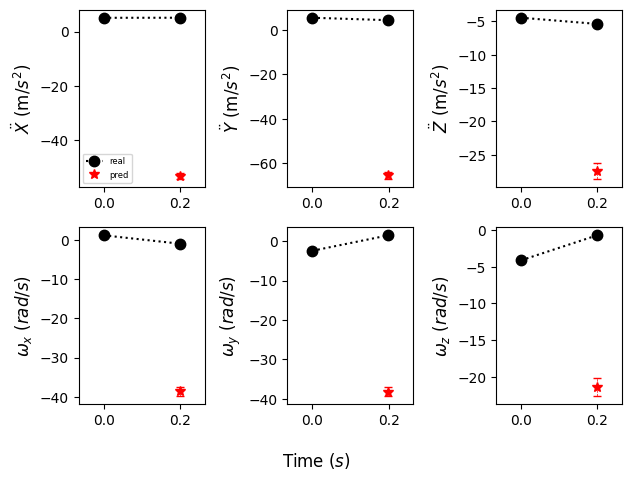

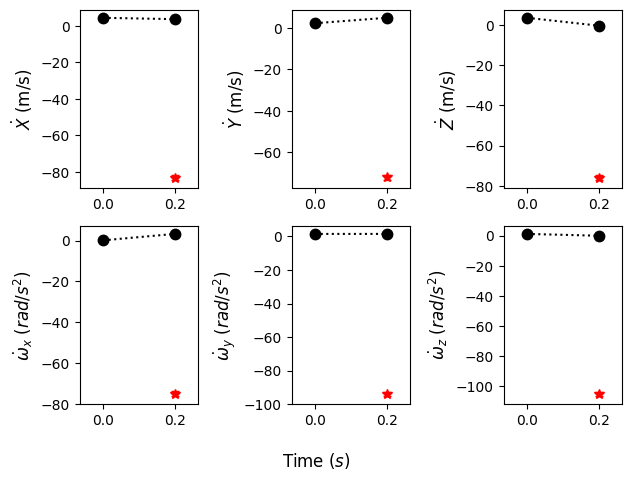

Current Batch Train Loss: 0.5117623805999756

Current Batch Train Loss: 0.19136987626552582

Current Batch Train Loss: 0.03253905847668648

Current Batch Train Loss: 0.022285480052232742

Current Batch Train Loss: 0.016383934766054153

Current Batch Train Loss: 0.015318489633500576

Current Batch Train Loss: 0.013622219674289227

Current Batch Train Loss: 0.01289063598960638

Current Batch Train Loss: 0.01268076803535223

Current Batch Train Loss: 0.011983159929513931

Current Batch Train Loss: 0.01206087414175272

Current Batch Train Loss: 0.011844114400446415

Current Batch Train Loss: 0.011966203339397907

Current Batch Train Loss: 0.01161203533411026

Current Batch Train Loss: 0.011773044243454933

Current Batch Train Loss: 0.0119940135627985

Current Batch Train Loss: 0.011896329000592232

Current Batch Train Loss: 0.012119567021727562

Current Batch Train Loss: 0.01196480542421341

Current Batch Train Loss: 0.011726965196430683

Current Batch Train Loss: 0.011551582254469395

Cur

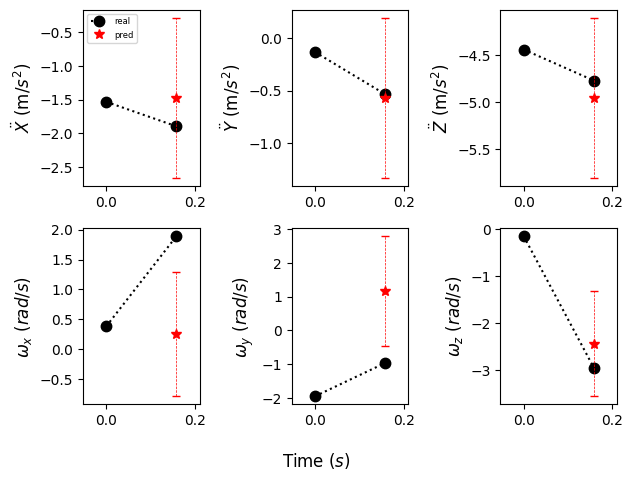

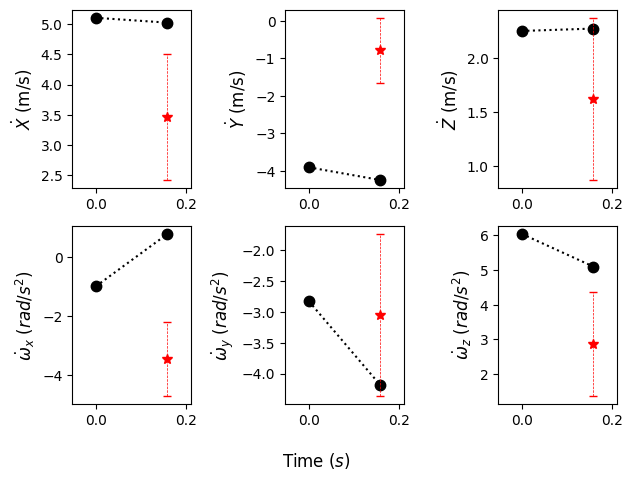

Current Batch Train Loss: 0.011218723841011524

Current Batch Train Loss: 0.011347444728016853

Current Batch Train Loss: 0.01097217109054327

Current Batch Train Loss: 0.011423840187489986

Current Batch Train Loss: 0.011374225839972496

Current Batch Train Loss: 0.011468429118394852

Current Batch Train Loss: 0.010982015170156956

Current Batch Train Loss: 0.011658498086035252

Current Batch Train Loss: 0.011529992334544659

Current Batch Train Loss: 0.011215630918741226

Current Batch Train Loss: 0.011384834535419941

Current Batch Train Loss: 0.011165591888129711

Current Batch Train Loss: 0.011309049092233181

Current Batch Train Loss: 0.011440768837928772

Current Batch Train Loss: 0.011356918141245842

Current Batch Train Loss: 0.010596890933811665

Current Batch Train Loss: 0.011555565521121025

Current Batch Train Loss: 0.011218980886042118

Current Batch Train Loss: 0.011305753141641617

Current Batch Train Loss: 0.011311417445540428

Current Batch Train Loss: 0.0109773520380

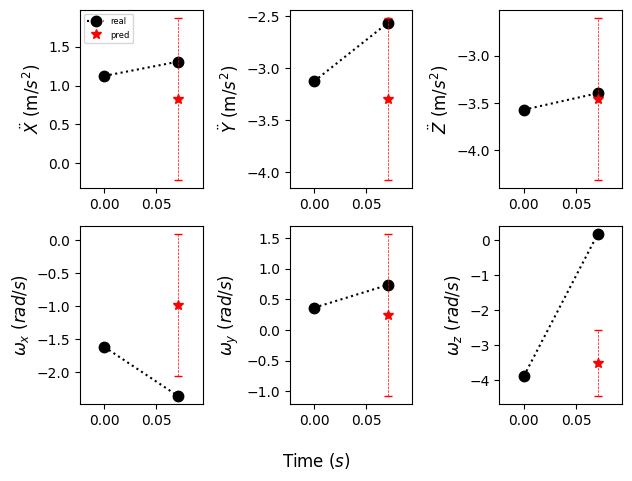

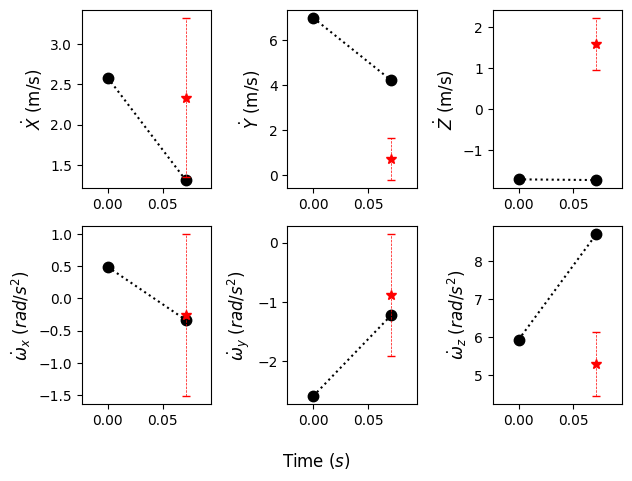

Current Batch Train Loss: 0.01109316572546959

Current Batch Train Loss: 0.010883253999054432

Current Batch Train Loss: 0.01035782415419817

Current Batch Train Loss: 0.011380803771317005

Current Batch Train Loss: 0.011323906481266022

Current Batch Train Loss: 0.011562027037143707

Current Batch Train Loss: 0.01145225204527378

Current Batch Train Loss: 0.01090389396995306

Current Batch Train Loss: 0.010935008525848389

Current Batch Train Loss: 0.010840957053005695

Current Batch Train Loss: 0.010812323540449142

Current Batch Train Loss: 0.011471087113022804

Current Batch Train Loss: 0.011183253489434719

Current Batch Train Loss: 0.01124858669936657

Current Batch Train Loss: 0.010906508192420006

Current Batch Train Loss: 0.010842975229024887

Current Batch Train Loss: 0.010950707830488682

Current Batch Train Loss: 0.011154006235301495

Current Batch Train Loss: 0.01102292537689209

Current Batch Train Loss: 0.011206703260540962

Current Batch Train Loss: 0.01073463261127472


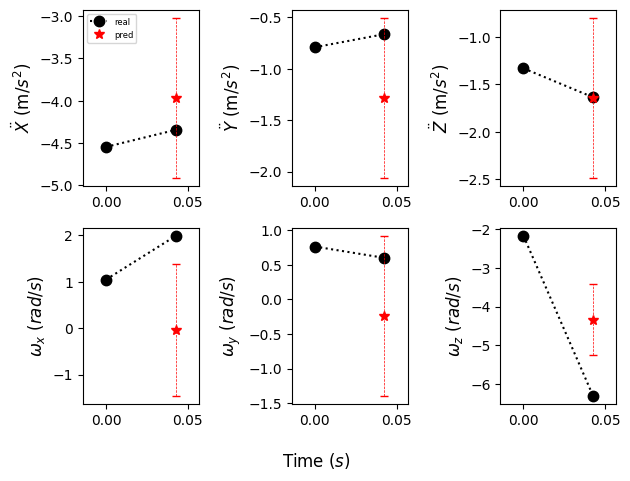

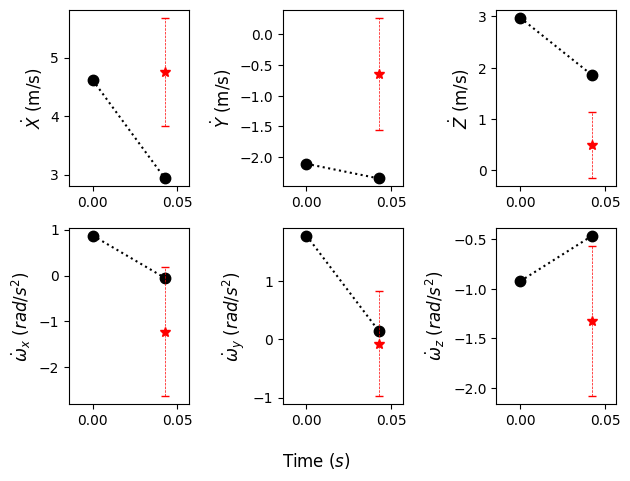

Current Batch Train Loss: 0.010900581255555153

Current Batch Train Loss: 0.011167229153215885

Current Batch Train Loss: 0.010478261858224869

Current Batch Train Loss: 0.011334748938679695

Current Batch Train Loss: 0.010895860381424427

Current Batch Train Loss: 0.010994534939527512

Current Batch Train Loss: 0.011088025756180286

Current Batch Train Loss: 0.010692335665225983

Current Batch Train Loss: 0.011548295617103577

Current Batch Train Loss: 0.010751353576779366

Current Batch Train Loss: 0.011076714843511581

Current Batch Train Loss: 0.011056416667997837

Current Batch Train Loss: 0.010830367915332317

Current Batch Train Loss: 0.010930120013654232

Current Batch Train Loss: 0.011015239171683788

Current Batch Train Loss: 0.010622739791870117

Current Batch Train Loss: 0.011049482971429825

Current Batch Train Loss: 0.010539747774600983

Current Batch Train Loss: 0.011134009808301926

Current Batch Train Loss: 0.010999239981174469

Current Batch Train Loss: 0.011223246343

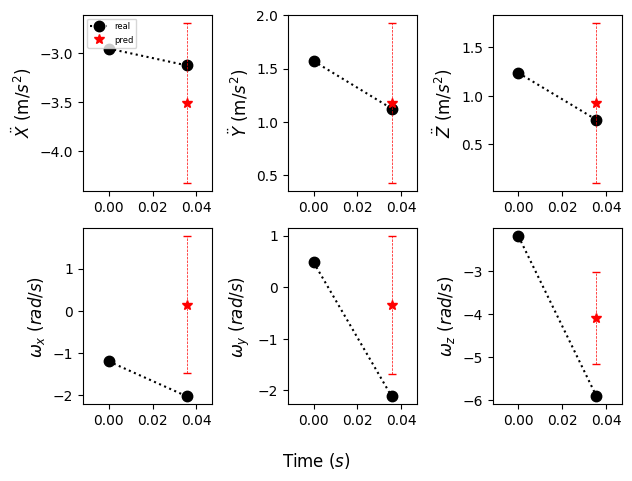

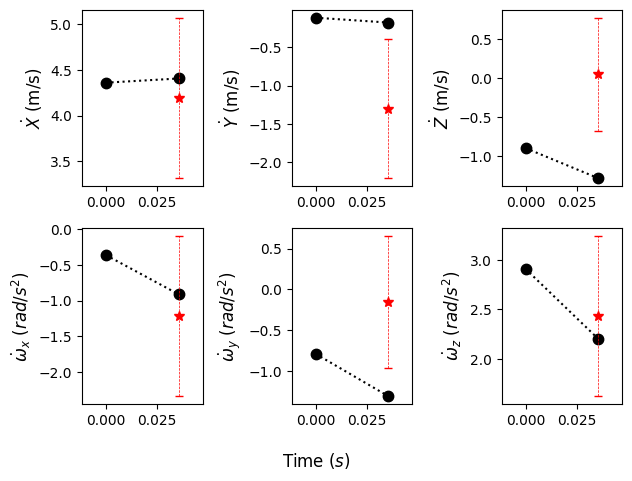

Current Batch Train Loss: 0.01060327235609293

Current Batch Train Loss: 0.010965955443680286

Current Batch Train Loss: 0.010625489056110382

Current Batch Train Loss: 0.01081809587776661

Current Batch Train Loss: 0.010783297941088676

Current Batch Train Loss: 0.01120501197874546

Current Batch Train Loss: 0.01077685784548521

Current Batch Train Loss: 0.010832365602254868

Current Batch Train Loss: 0.010698157362639904

Current Batch Train Loss: 0.01064024493098259

Current Batch Train Loss: 0.011150609701871872

Current Batch Train Loss: 0.01104951836168766

Current Batch Train Loss: 0.01135127991437912

Current Batch Train Loss: 0.010839351452887058

Current Batch Train Loss: 0.011191549710929394

Current Batch Train Loss: 0.010537047870457172

Current Batch Train Loss: 0.010934978723526001

Current Batch Train Loss: 0.010751676745712757

Current Batch Train Loss: 0.011415431275963783

Current Batch Train Loss: 0.010898053646087646

Current Batch Train Loss: 0.01082550548017025



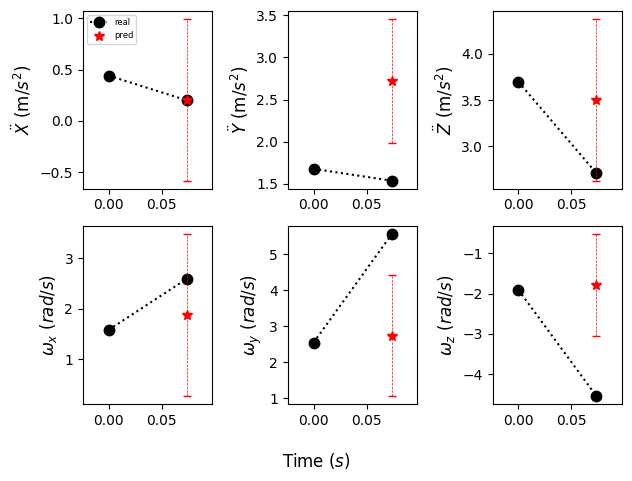

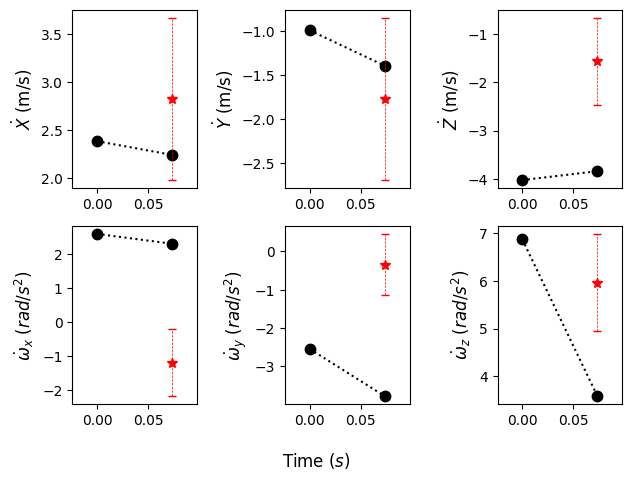

Current Batch Train Loss: 0.010763726197183132

Current Batch Train Loss: 0.010363140143454075

Current Batch Train Loss: 0.01079584565013647

Current Batch Train Loss: 0.010911666788160801

Current Batch Train Loss: 0.010819703340530396

Current Batch Train Loss: 0.010709007270634174

Current Batch Train Loss: 0.011028587818145752

Current Batch Train Loss: 0.011144918389618397

Current Batch Train Loss: 0.011119108647108078

Current Batch Train Loss: 0.010995445773005486

Current Batch Train Loss: 0.0107620470225811

Current Batch Train Loss: 0.010749554261565208

Current Batch Train Loss: 0.011289337649941444

Current Batch Train Loss: 0.010561361908912659

Current Batch Train Loss: 0.010476869530975819

Current Batch Train Loss: 0.01084577664732933

Current Batch Train Loss: 0.01069397572427988

Current Batch Train Loss: 0.01092142891138792

Current Batch Train Loss: 0.010267332196235657

Current Batch Train Loss: 0.011074750684201717

Current Batch Train Loss: 0.010737036354839802

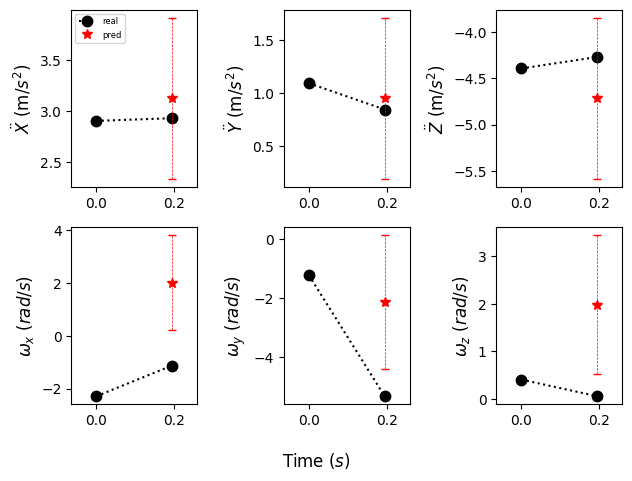

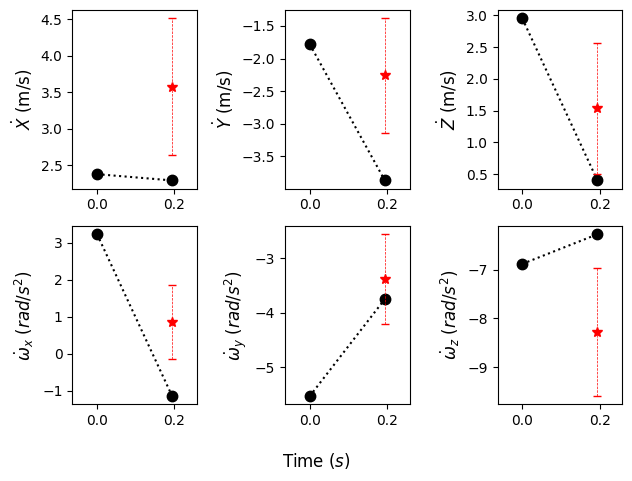

Current Batch Train Loss: 0.010485103353857994

Current Batch Train Loss: 0.0111216576769948

Current Batch Train Loss: 0.0110181774944067

Current Batch Train Loss: 0.010879996232688427

Current Batch Train Loss: 0.011133341118693352

Current Batch Train Loss: 0.01036414597183466

Current Batch Train Loss: 0.011048213578760624

Current Batch Train Loss: 0.010908016934990883

Current Batch Train Loss: 0.01076976303011179

Current Batch Train Loss: 0.011080610565841198

Current Batch Train Loss: 0.010935218073427677

Current Batch Train Loss: 0.010925043374300003

Current Batch Train Loss: 0.010663846507668495

Current Batch Train Loss: 0.010879808105528355

Current Batch Train Loss: 0.011235319077968597

Current Batch Train Loss: 0.01111355610191822

Current Batch Train Loss: 0.010237276554107666

Current Batch Train Loss: 0.01092696562409401

Current Batch Train Loss: 0.010622666217386723

Current Batch Train Loss: 0.010774324648082256

Current Batch Train Loss: 0.01098769810050726

C

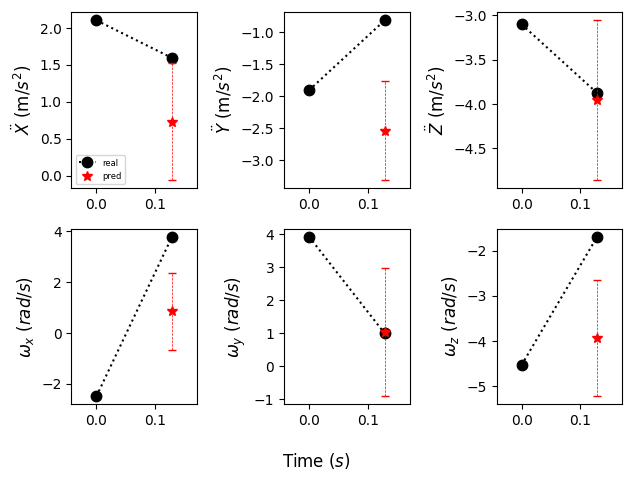

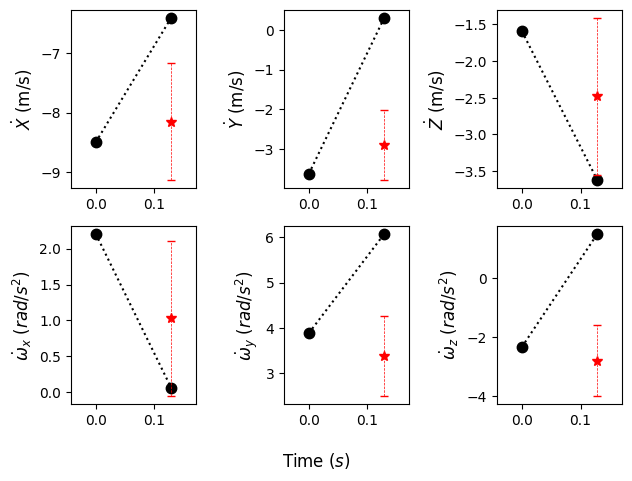

Current Batch Train Loss: 0.010559133253991604

Current Batch Train Loss: 0.011132407933473587

Current Batch Train Loss: 0.010724975727498531

Current Batch Train Loss: 0.010899115353822708

Current Batch Train Loss: 0.010908795520663261

Current Batch Train Loss: 0.010803090408444405

Current Batch Train Loss: 0.010797036811709404

Current Batch Train Loss: 0.01079849898815155

Current Batch Train Loss: 0.010798868723213673

Current Batch Train Loss: 0.010582922957837582

Current Batch Train Loss: 0.011070650070905685

Current Batch Train Loss: 0.011055350303649902

Current Batch Train Loss: 0.010840168222784996

Current Batch Train Loss: 0.010667149908840656

Current Batch Train Loss: 0.011187453754246235

Current Batch Train Loss: 0.01098889671266079

Current Batch Train Loss: 0.011067957617342472

Current Batch Train Loss: 0.01071220450103283

Current Batch Train Loss: 0.010722246952354908

Current Batch Train Loss: 0.01052134670317173

Current Batch Train Loss: 0.0109148016199469

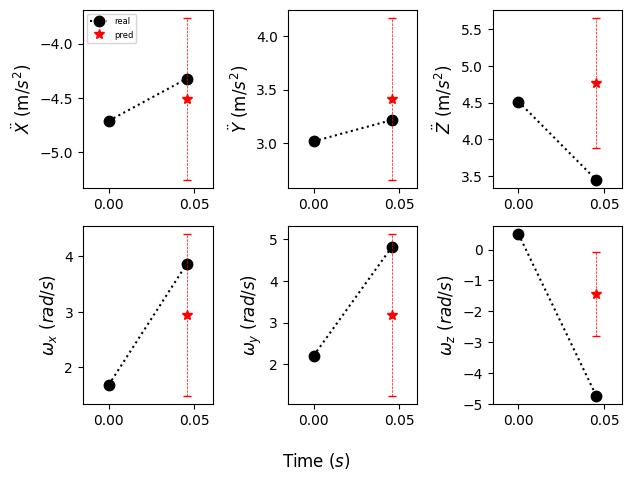

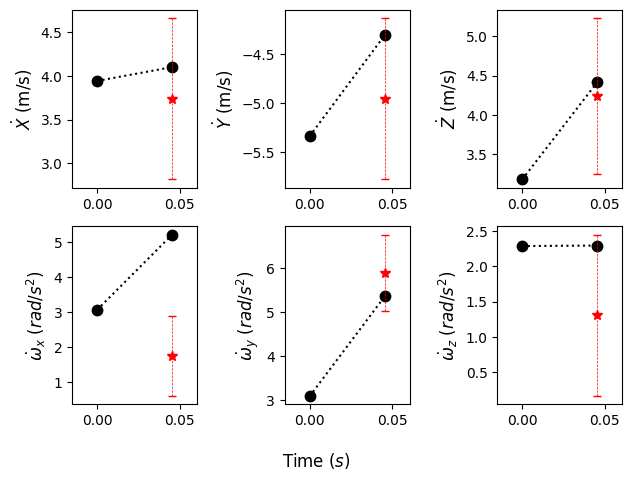

Current Batch Train Loss: 0.010507659986615181

Current Batch Train Loss: 0.010910898447036743

Current Batch Train Loss: 0.011105787940323353

Current Batch Train Loss: 0.010280798189342022

Current Batch Train Loss: 0.010781094431877136

Current Batch Train Loss: 0.010844371281564236

Current Batch Train Loss: 0.010569761507213116

Current Batch Train Loss: 0.011044012382626534

Current Batch Train Loss: 0.01047967467457056

Current Batch Train Loss: 0.010733661241829395

Current Batch Train Loss: 0.010789532214403152

Current Batch Train Loss: 0.011025674641132355

Current Batch Train Loss: 0.010828125290572643

Current Batch Train Loss: 0.01099876593798399

Current Batch Train Loss: 0.011206008493900299

Current Batch Train Loss: 0.010697578079998493

Current Batch Train Loss: 0.011211498640477657

Current Batch Train Loss: 0.010739835910499096

Current Batch Train Loss: 0.010794252157211304

Current Batch Train Loss: 0.01067427545785904

Current Batch Train Loss: 0.010907012969255

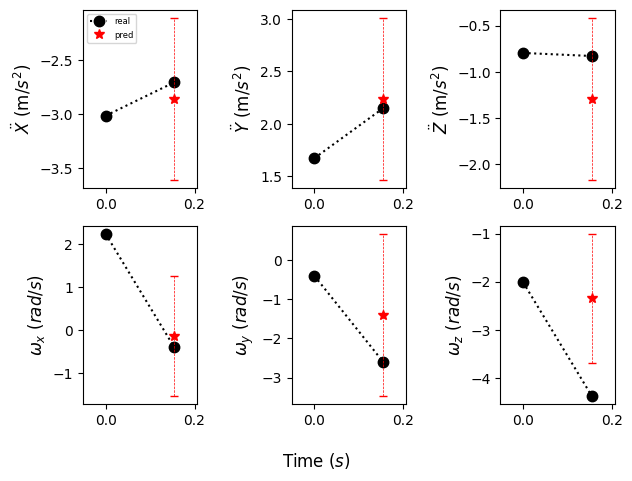

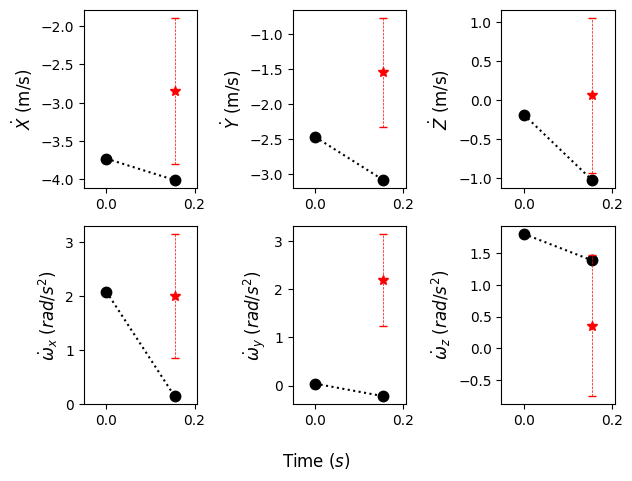

Current Batch Train Loss: 0.010506199672818184

Current Batch Train Loss: 0.011082109063863754

Current Batch Train Loss: 0.011292788200080395

Current Batch Train Loss: 0.010930604301393032

Current Batch Train Loss: 0.010489000007510185

Current Batch Train Loss: 0.01074336189776659

Current Batch Train Loss: 0.010986989364027977

Current Batch Train Loss: 0.010608610697090626

Current Batch Train Loss: 0.010699516162276268

Current Batch Train Loss: 0.010387214832007885

Current Batch Train Loss: 0.010180098935961723

Current Batch Train Loss: 0.011004237458109856

Current Batch Train Loss: 0.010807272046804428

Current Batch Train Loss: 0.010792064480483532

Current Batch Train Loss: 0.011147131212055683

Current Batch Train Loss: 0.010801916942000389

Current Batch Train Loss: 0.010692501440644264

Current Batch Train Loss: 0.01064479909837246

Current Batch Train Loss: 0.010557050816714764

Current Batch Train Loss: 0.01068094465881586

Current Batch Train Loss: 0.010961865074932

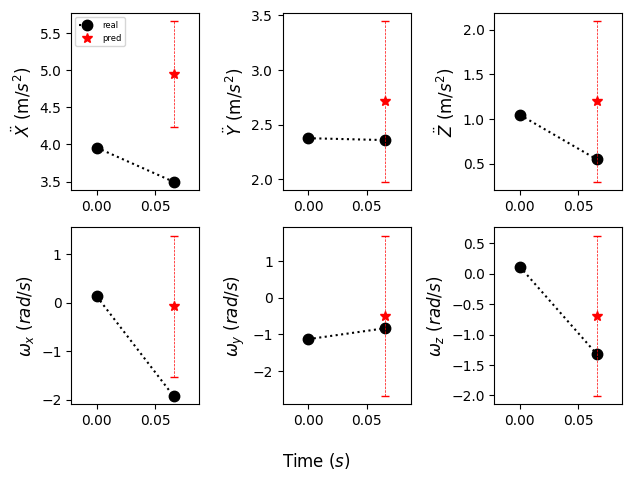

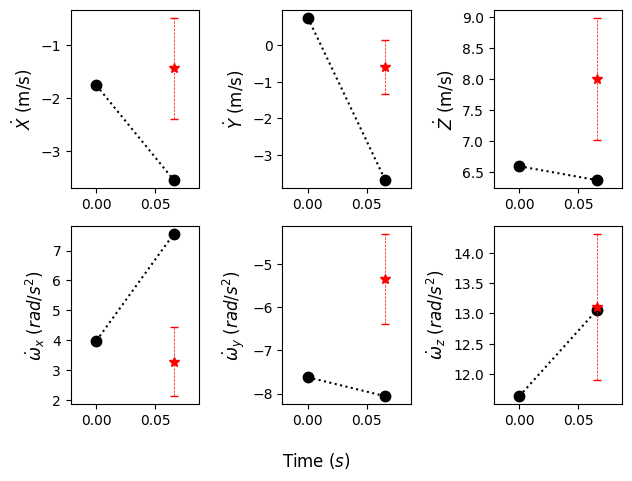

Current Batch Train Loss: 0.010984456166625023

Current Batch Train Loss: 0.010913792997598648

Current Batch Train Loss: 0.010539721697568893

Current Batch Train Loss: 0.01010389905422926

Current Batch Train Loss: 0.010810422711074352

Current Batch Train Loss: 0.01090188231319189

Current Batch Train Loss: 0.010661426931619644

Current Batch Train Loss: 0.010591319762170315

Current Batch Train Loss: 0.010829473845660686

Current Batch Train Loss: 0.010587677359580994

Current Batch Train Loss: 0.011041362769901752

Current Batch Train Loss: 0.01051069051027298

Current Batch Train Loss: 0.010646735318005085

Current Batch Train Loss: 0.010694301687180996

Current Batch Train Loss: 0.010587909258902073

Current Batch Train Loss: 0.01067272573709488

Current Batch Train Loss: 0.011070485226809978

Current Batch Train Loss: 0.010610253550112247

Current Batch Train Loss: 0.010758724063634872

Current Batch Train Loss: 0.010950176976621151

Current Batch Train Loss: 0.0104881701990962

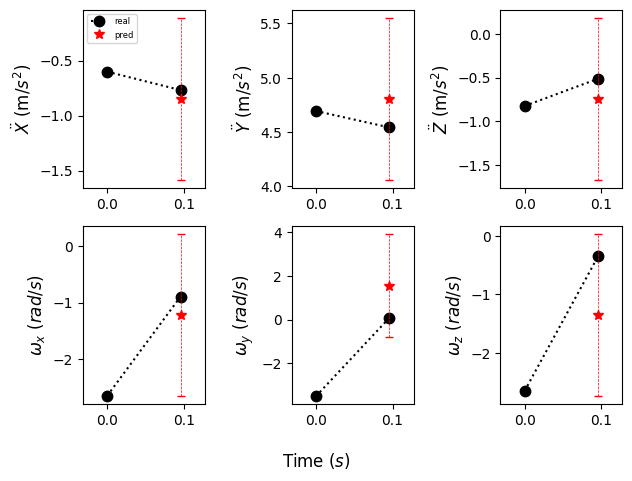

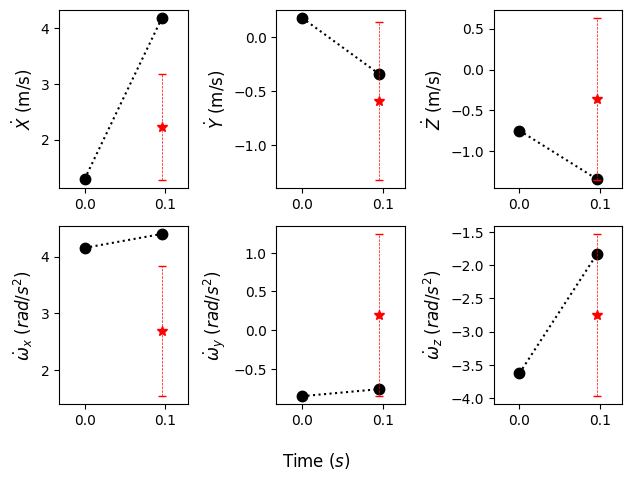

Current Batch Train Loss: 0.010786999017000198

Current Batch Train Loss: 0.010717026889324188

Current Batch Train Loss: 0.010788274928927422

Current Batch Train Loss: 0.010493919253349304

Current Batch Train Loss: 0.010787399485707283

Current Batch Train Loss: 0.010785147547721863

Current Batch Train Loss: 0.010952461510896683

Current Batch Train Loss: 0.010991117917001247

Current Batch Train Loss: 0.010790440253913403

Current Batch Train Loss: 0.010805023834109306

Current Batch Train Loss: 0.010773824527859688

Current Batch Train Loss: 0.011051774956285954

Current Batch Train Loss: 0.010711584240198135

Current Batch Train Loss: 0.010552851483225822

Current Batch Train Loss: 0.01082236971706152

Current Batch Train Loss: 0.010282464325428009

Current Batch Train Loss: 0.010599292814731598

Current Batch Train Loss: 0.010471643880009651

Current Batch Train Loss: 0.010623641312122345

Current Batch Train Loss: 0.010735326446592808

Current Batch Train Loss: 0.0108090918511

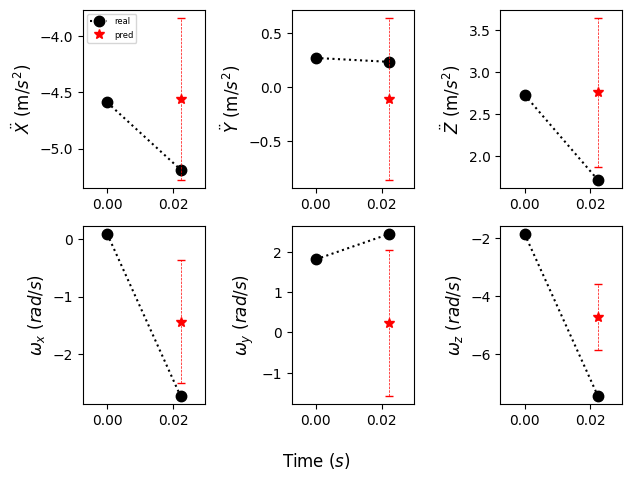

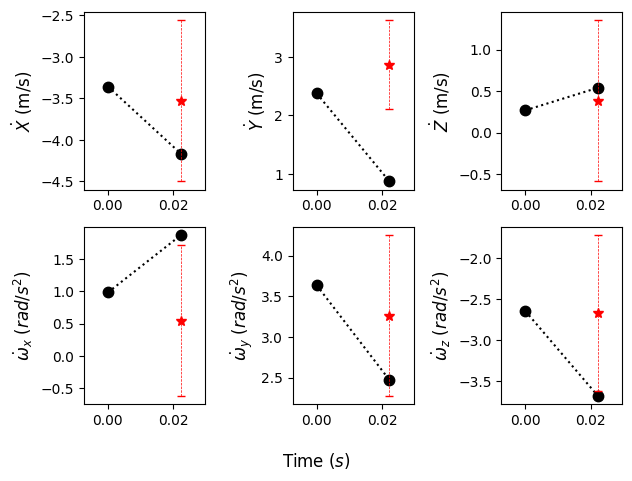

Current Batch Train Loss: 0.010686414316296577

Current Batch Train Loss: 0.010484185069799423

Current Batch Train Loss: 0.010940507054328918

Current Batch Train Loss: 0.010464292019605637

Current Batch Train Loss: 0.010904298163950443

Current Batch Train Loss: 0.01097981259226799

Current Batch Train Loss: 0.010782584547996521

Current Batch Train Loss: 0.011359615251421928

Current Batch Train Loss: 0.01114861574023962

Current Batch Train Loss: 0.010566414333879948

Current Batch Train Loss: 0.011263879016041756

Current Batch Train Loss: 0.01080914307385683

Current Batch Train Loss: 0.010993033647537231

Current Batch Train Loss: 0.01083045918494463

Current Batch Train Loss: 0.010923667810857296

Current Batch Train Loss: 0.010975494049489498

Current Batch Train Loss: 0.010783415287733078

Current Batch Train Loss: 0.010894508101046085

Current Batch Train Loss: 0.011077319271862507

Current Batch Train Loss: 0.010979064740240574

Current Batch Train Loss: 0.0105108311399817

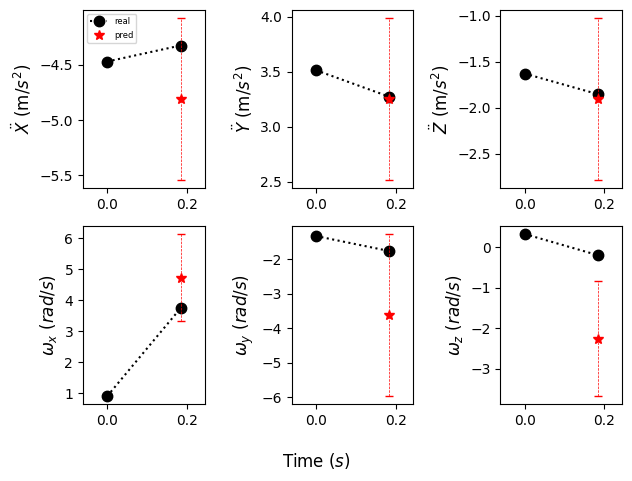

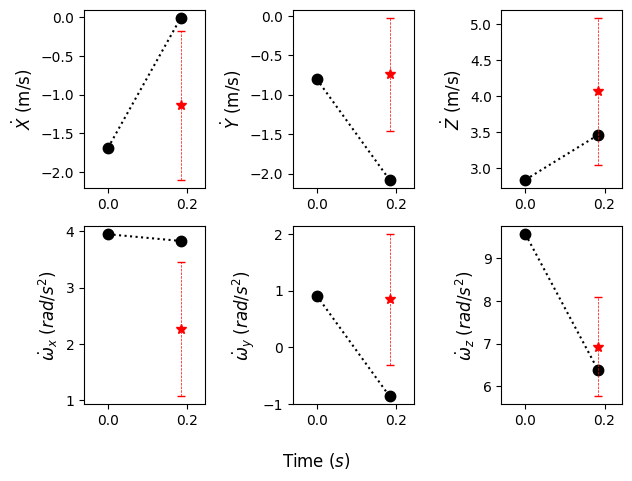

Current Batch Train Loss: 0.010822444222867489

Current Batch Train Loss: 0.010939926840364933

Current Batch Train Loss: 0.010785534046590328

Current Batch Train Loss: 0.011043068021535873

Current Batch Train Loss: 0.010972488671541214

Current Batch Train Loss: 0.010301150381565094

Current Batch Train Loss: 0.010374288074672222

Current Batch Train Loss: 0.010556291788816452

Current Batch Train Loss: 0.010842491872608662

Current Batch Train Loss: 0.010533764958381653

Current Batch Train Loss: 0.010535824112594128

Current Batch Train Loss: 0.01068672351539135

Current Batch Train Loss: 0.011130426079034805

Current Batch Train Loss: 0.010976176708936691

Current Batch Train Loss: 0.010471964254975319

Current Batch Train Loss: 0.01028955727815628

Current Batch Train Loss: 0.010723813436925411

Current Batch Train Loss: 0.010658934712409973

Current Batch Train Loss: 0.010903987102210522

Current Batch Train Loss: 0.010781075805425644

Current Batch Train Loss: 0.01125667337328

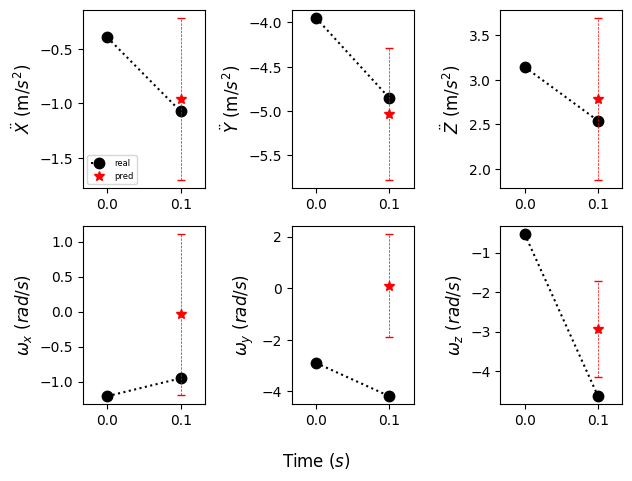

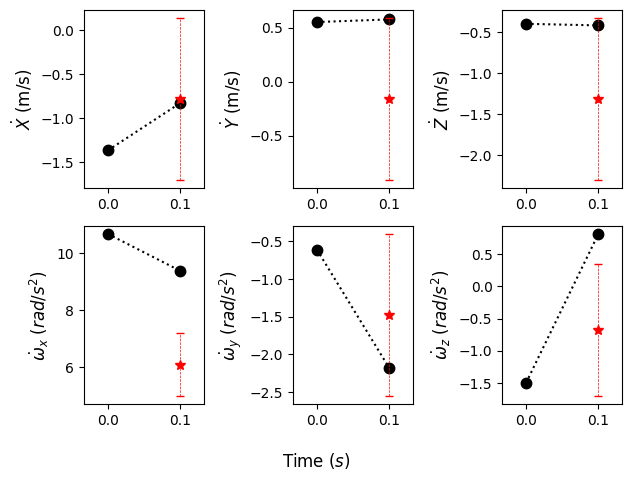

Current Batch Train Loss: 0.010390852577984333

Current Batch Train Loss: 0.010365192778408527

Current Batch Train Loss: 0.010898660868406296

Current Batch Train Loss: 0.010566865094006062

Current Batch Train Loss: 0.010644352994859219

Current Batch Train Loss: 0.011173185892403126

Current Batch Train Loss: 0.010768147185444832

Current Batch Train Loss: 0.010290530510246754

Current Batch Train Loss: 0.01071639358997345

Current Batch Train Loss: 0.010842835530638695

Current Batch Train Loss: 0.01111854799091816

Current Batch Train Loss: 0.010883506387472153

Current Batch Train Loss: 0.010528710670769215

Current Batch Train Loss: 0.01101976539939642

Current Batch Train Loss: 0.010659725405275822

Current Batch Train Loss: 0.010631201788783073

Current Batch Train Loss: 0.010611326433718204

Current Batch Train Loss: 0.010603204369544983

Current Batch Train Loss: 0.010647517628967762

Current Batch Train Loss: 0.01115403976291418

Current Batch Train Loss: 0.0107961175963282

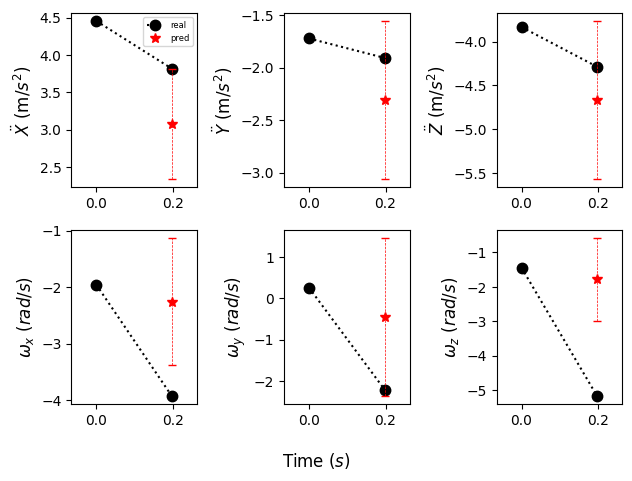

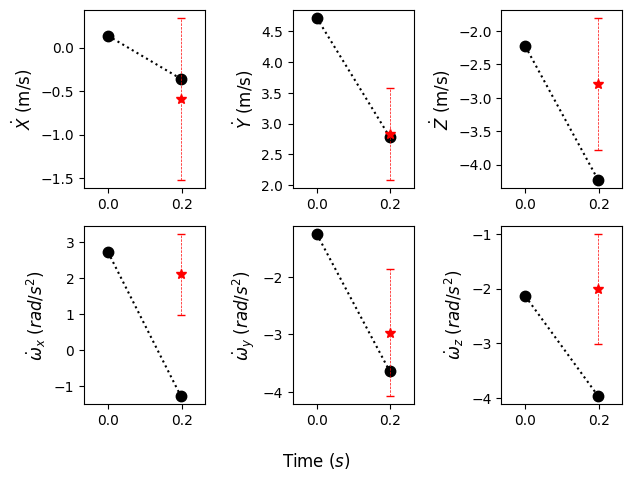

Current Batch Train Loss: 0.010515931993722916

Current Batch Train Loss: 0.010959183797240257

Current Batch Train Loss: 0.010553677566349506

Current Batch Train Loss: 0.01062606181949377

Current Batch Train Loss: 0.010843398049473763

Current Batch Train Loss: 0.010508815757930279

Current Batch Train Loss: 0.010646251030266285

Current Batch Train Loss: 0.010577584616839886

Current Batch Train Loss: 0.010839755646884441

Current Batch Train Loss: 0.010673299431800842

Current Batch Train Loss: 0.010731518268585205

Current Batch Train Loss: 0.010440059006214142

Current Batch Train Loss: 0.010947708040475845

Current Batch Train Loss: 0.010633177123963833

Current Batch Train Loss: 0.010513298213481903

Current Batch Train Loss: 0.010658948682248592

Current Batch Train Loss: 0.010936331935226917

Current Batch Train Loss: 0.010468630120158195

Current Batch Train Loss: 0.010946805588901043

Current Batch Train Loss: 0.010653718374669552

Current Batch Train Loss: 0.0102827269583

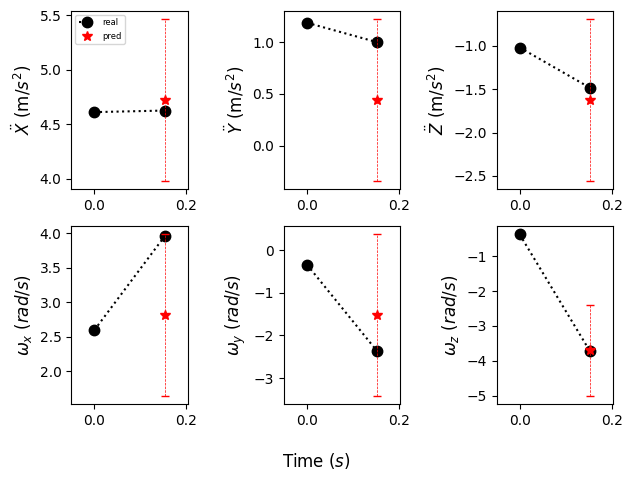

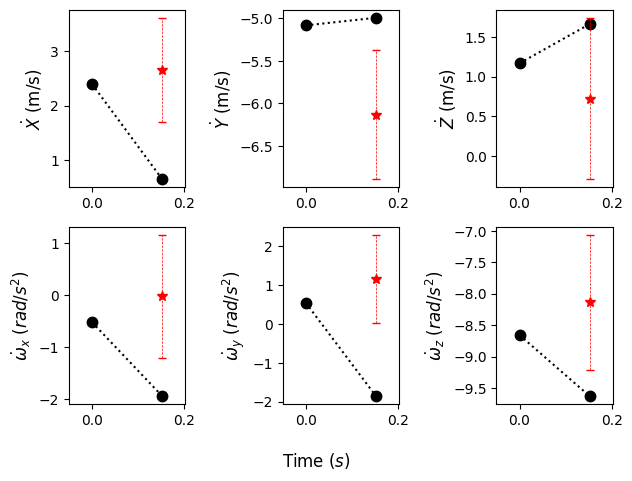

Current Batch Train Loss: 0.010485783219337463

Current Batch Train Loss: 0.010546315461397171

Current Batch Train Loss: 0.011233723722398281

Current Batch Train Loss: 0.010989552363753319

Current Batch Train Loss: 0.010271877981722355

Current Batch Train Loss: 0.010699974372982979

Current Batch Train Loss: 0.010892756283283234

Current Batch Train Loss: 0.010865379124879837

Current Batch Train Loss: 0.010910139419138432

Current Batch Train Loss: 0.010484252125024796

Current Batch Train Loss: 0.010824804194271564

Current Batch Train Loss: 0.010526048019528389

Current Batch Train Loss: 0.01103381346911192

Current Batch Train Loss: 0.011083902791142464

Current Batch Train Loss: 0.010928910225629807

Current Batch Train Loss: 0.010808715596795082

Current Batch Train Loss: 0.011028815060853958

Current Batch Train Loss: 0.010518660768866539

Current Batch Train Loss: 0.011048420332372189

Current Batch Train Loss: 0.010754933580756187

Current Batch Train Loss: 0.0109513178467

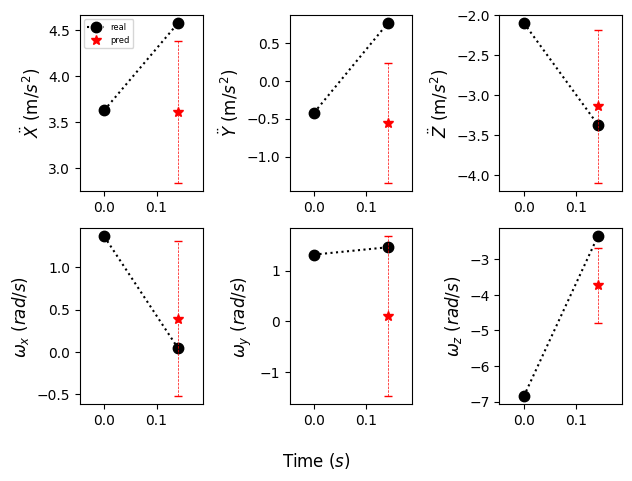

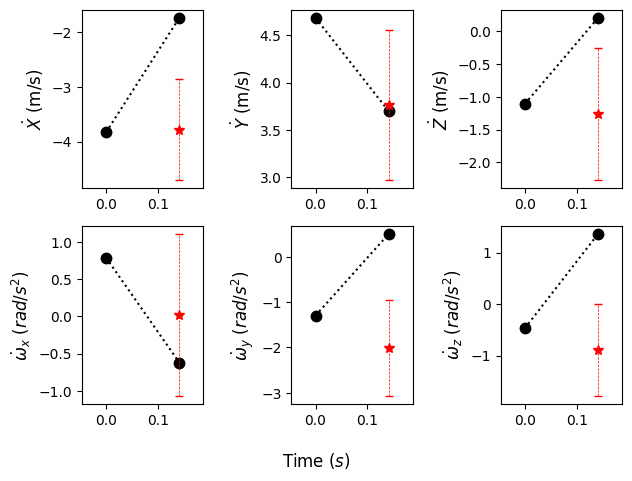

Current Batch Train Loss: 0.010659930296242237

Current Batch Train Loss: 0.011220377869904041

Current Batch Train Loss: 0.010924060828983784

Current Batch Train Loss: 0.01085173711180687

Current Batch Train Loss: 0.010655203834176064

Current Batch Train Loss: 0.010874584317207336

Current Batch Train Loss: 0.010934053920209408

Current Batch Train Loss: 0.01076291874051094

Current Batch Train Loss: 0.011299687437713146

Current Batch Train Loss: 0.011001829989254475

Current Batch Train Loss: 0.010632123798131943

Current Batch Train Loss: 0.010585562326014042

Current Batch Train Loss: 0.010899760760366917

Current Batch Train Loss: 0.0112159950658679

Current Batch Train Loss: 0.0107913538813591

Current Batch Train Loss: 0.010912737809121609

Current Batch Train Loss: 0.010685177519917488

Current Batch Train Loss: 0.010831360705196857

Current Batch Train Loss: 0.01073058694601059

Current Batch Train Loss: 0.01085694134235382

Current Batch Train Loss: 0.010901778005063534



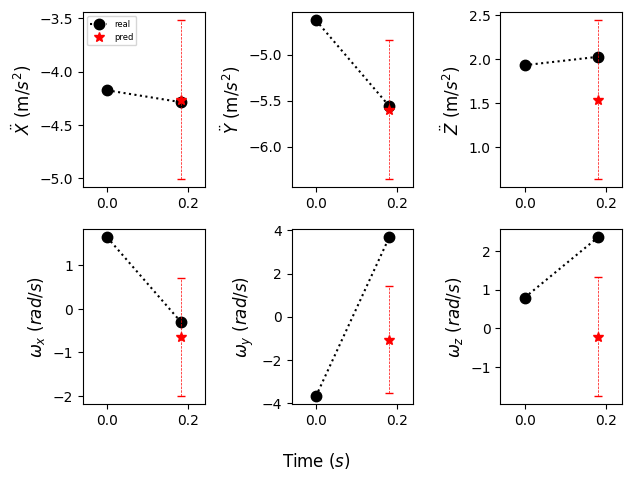

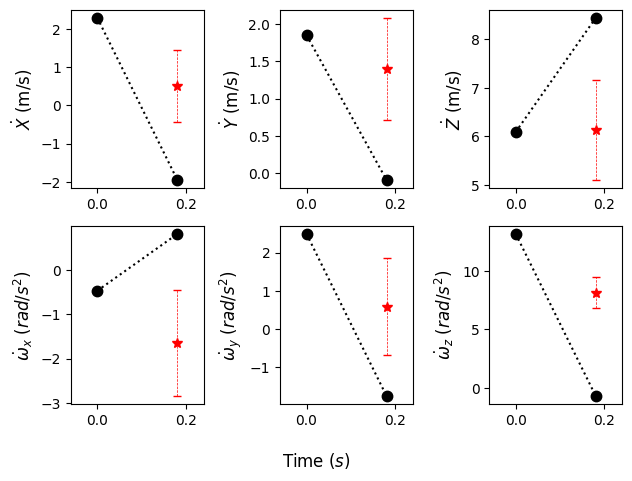

Current Batch Train Loss: 0.010853691026568413

Current Batch Train Loss: 0.010784723795950413

Current Batch Train Loss: 0.010786649771034718

Current Batch Train Loss: 0.010772705078125

Current Batch Train Loss: 0.01051092054694891

Current Batch Train Loss: 0.011123212985694408

Current Batch Train Loss: 0.010782508179545403

Current Batch Train Loss: 0.010793251916766167

Current Batch Train Loss: 0.010676447302103043

Current Batch Train Loss: 0.01070668175816536

Current Batch Train Loss: 0.01111523061990738

Current Batch Train Loss: 0.01069873571395874

Current Batch Train Loss: 0.010773326270282269

Current Batch Train Loss: 0.010659800842404366

Current Batch Train Loss: 0.010552110150456429

Current Batch Train Loss: 0.010805802419781685

Current Batch Train Loss: 0.010975719429552555

Current Batch Train Loss: 0.011042998172342777

Current Batch Train Loss: 0.010636729188263416

Current Batch Train Loss: 0.010748940519988537

Current Batch Train Loss: 0.010737171396613121


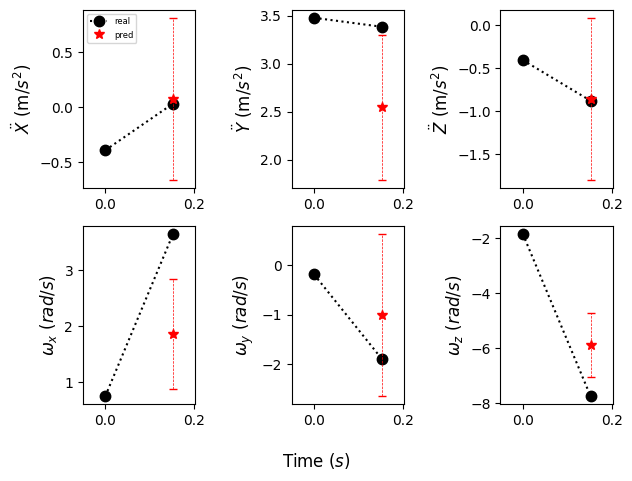

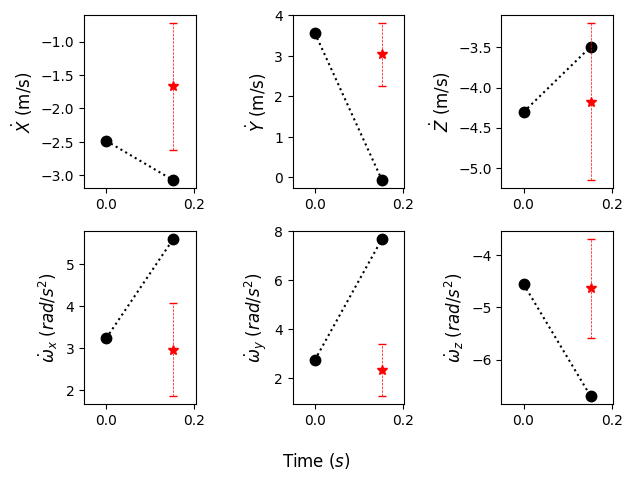

Current Batch Train Loss: 0.010598701424896717

Current Batch Train Loss: 0.010905992239713669

Current Batch Train Loss: 0.010809287428855896

Current Batch Train Loss: 0.010264442302286625

Current Batch Train Loss: 0.010976226069033146

Current Batch Train Loss: 0.011073606088757515

Current Batch Train Loss: 0.010748753324151039

Current Batch Train Loss: 0.01080878172069788

Current Batch Train Loss: 0.0108046168461442

Current Batch Train Loss: 0.010924333706498146

Current Batch Train Loss: 0.010654183104634285

Current Batch Train Loss: 0.011189395561814308

Current Batch Train Loss: 0.011236215010285378

Current Batch Train Loss: 0.010419202968478203

Current Batch Train Loss: 0.010391556657850742

Current Batch Train Loss: 0.010816369205713272

Current Batch Train Loss: 0.010860923677682877

Current Batch Train Loss: 0.0106205428019166

Current Batch Train Loss: 0.010653942823410034

Current Batch Train Loss: 0.010738723911345005

Current Batch Train Loss: 0.01098331436514854

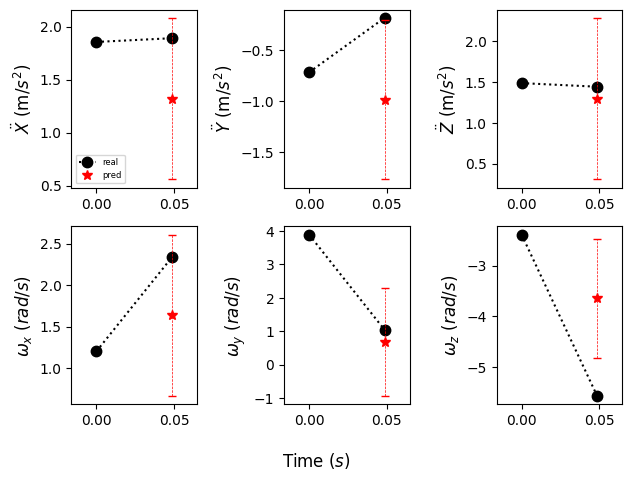

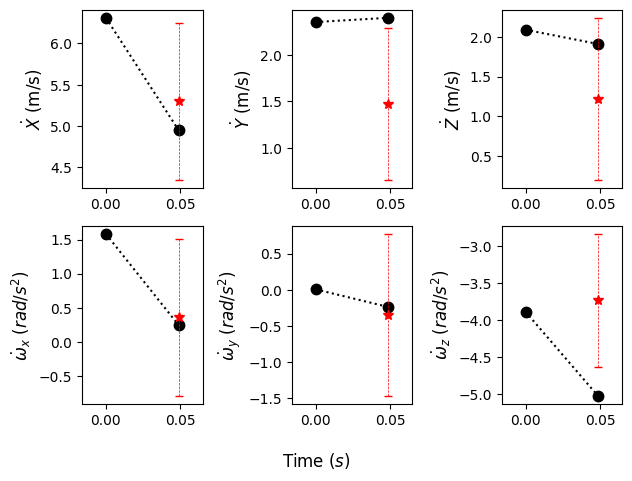

Current Batch Train Loss: 0.010568809695541859

Current Batch Train Loss: 0.010938219726085663

Current Batch Train Loss: 0.010909857228398323

Current Batch Train Loss: 0.01020217128098011

Current Batch Train Loss: 0.010987730696797371

Current Batch Train Loss: 0.01082606054842472

Current Batch Train Loss: 0.010865711607038975

Current Batch Train Loss: 0.011279980652034283

Current Batch Train Loss: 0.010670757852494717

Current Batch Train Loss: 0.01069142296910286

Current Batch Train Loss: 0.010606007650494576

Current Batch Train Loss: 0.010243129916489124

Current Batch Train Loss: 0.011336066760122776

Current Batch Train Loss: 0.010518312454223633

Current Batch Train Loss: 0.010382171720266342

Current Batch Train Loss: 0.010840100236237049

Current Batch Train Loss: 0.010638191364705563

Current Batch Train Loss: 0.010843014344573021

Current Batch Train Loss: 0.01090378500521183

Current Batch Train Loss: 0.010484809055924416

Current Batch Train Loss: 0.0106321778148412

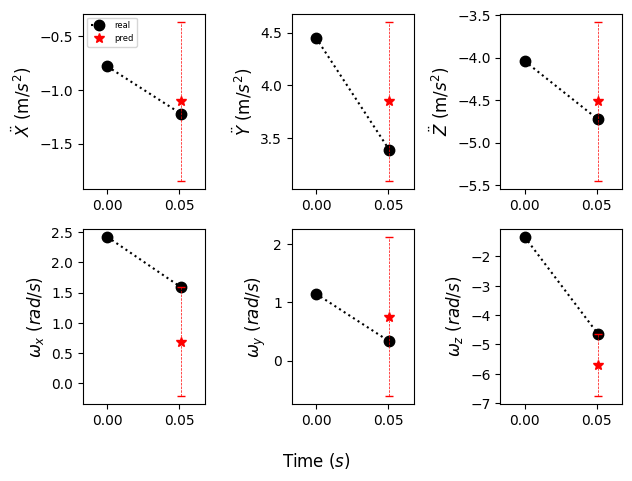

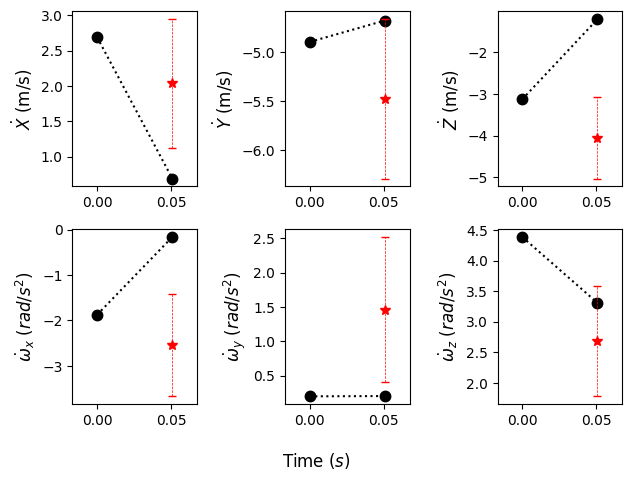

Current Batch Train Loss: 0.01106170192360878

Current Batch Train Loss: 0.010723716579377651

Current Batch Train Loss: 0.011119931004941463

Current Batch Train Loss: 0.010699394159018993

Current Batch Train Loss: 0.010526143014431

Current Batch Train Loss: 0.01085397694259882

Current Batch Train Loss: 0.010616828687489033

Current Batch Train Loss: 0.010586388409137726

Current Batch Train Loss: 0.01101955771446228

Current Batch Train Loss: 0.01103261299431324

Current Batch Train Loss: 0.011044502258300781

Current Batch Train Loss: 0.010310180485248566

Current Batch Train Loss: 0.010457232594490051

Current Batch Train Loss: 0.011105038225650787

Current Batch Train Loss: 0.010646025650203228

Current Batch Train Loss: 0.01075779926031828

Current Batch Train Loss: 0.01085706241428852

Current Batch Train Loss: 0.010702005587518215

Current Batch Train Loss: 0.010995947755873203

Current Batch Train Loss: 0.01087347511202097

Current Batch Train Loss: 0.010632116347551346

Cu

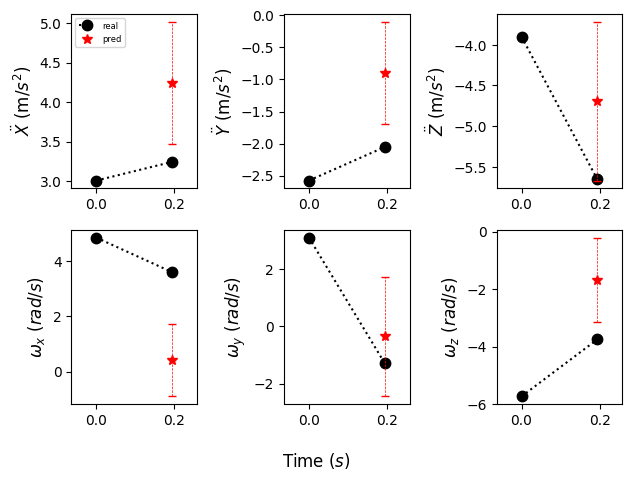

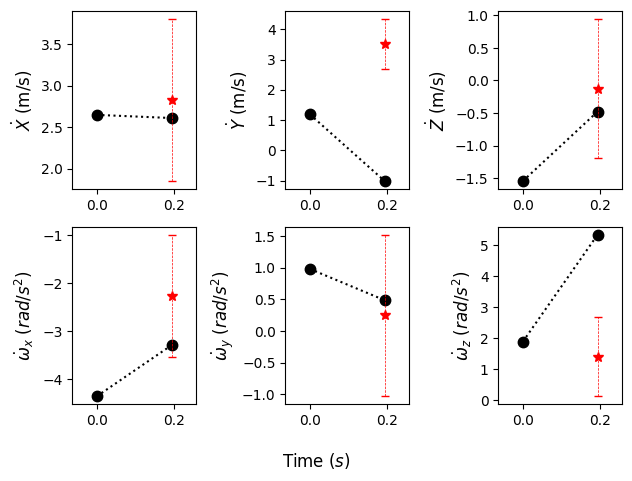

Current Batch Train Loss: 0.010842649266123772

Current Batch Train Loss: 0.010796371847391129

Current Batch Train Loss: 0.010691218078136444

Current Batch Train Loss: 0.010940144769847393

Current Batch Train Loss: 0.010576006025075912

Current Batch Train Loss: 0.01128373108804226

Current Batch Train Loss: 0.010694791562855244

Current Batch Train Loss: 0.01073165237903595

Current Batch Train Loss: 0.010751892812550068

Current Batch Train Loss: 0.01055882778018713

Current Batch Train Loss: 0.010857386514544487

Current Batch Train Loss: 0.010522417724132538

Current Batch Train Loss: 0.010606914758682251

Current Batch Train Loss: 0.011198952794075012

Current Batch Train Loss: 0.010970216244459152

Current Batch Train Loss: 0.010507305152714252

Current Batch Train Loss: 0.010780910961329937

Current Batch Train Loss: 0.01043141819536686

Current Batch Train Loss: 0.010811639949679375

Current Batch Train Loss: 0.011012078262865543

Current Batch Train Loss: 0.0106760226190090

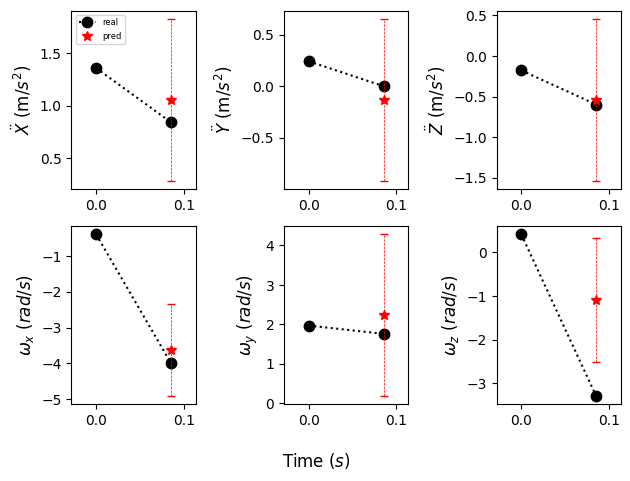

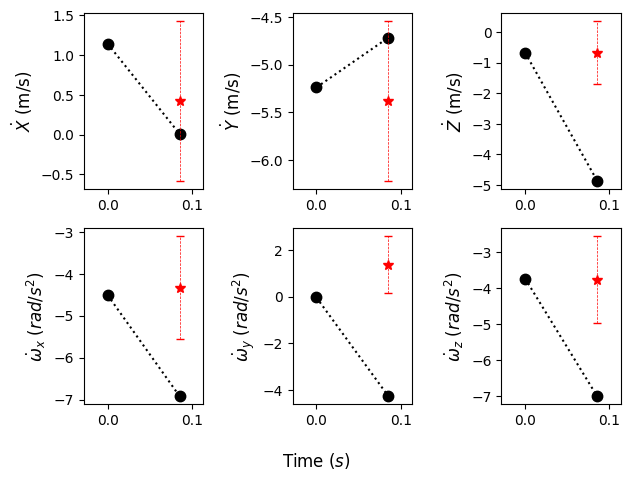

Current Batch Train Loss: 0.01064586453139782

Current Batch Train Loss: 0.010729590430855751

Current Batch Train Loss: 0.010743394494056702

Current Batch Train Loss: 0.010672018863260746

Current Batch Train Loss: 0.010572834871709347

Current Batch Train Loss: 0.010429807007312775

Current Batch Train Loss: 0.010676287114620209

Current Batch Train Loss: 0.010640926659107208

Current Batch Train Loss: 0.010462230071425438

Current Batch Train Loss: 0.010741720907390118

Current Batch Train Loss: 0.011131027713418007

Current Batch Train Loss: 0.01073638815432787

Current Batch Train Loss: 0.010607169941067696

Current Batch Train Loss: 0.010916868224740028

Current Batch Train Loss: 0.01076701283454895

Current Batch Train Loss: 0.010356545448303223

Current Batch Train Loss: 0.010690616443753242

Current Batch Train Loss: 0.01082452293485403

Current Batch Train Loss: 0.010905712842941284

Current Batch Train Loss: 0.01108804251998663

Current Batch Train Loss: 0.01065990421921014

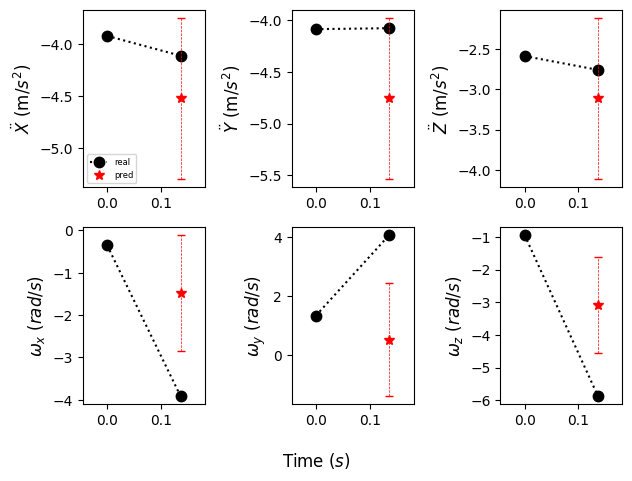

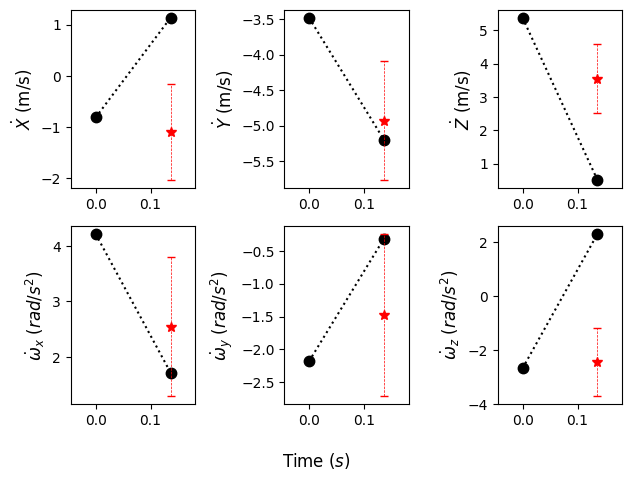

Current Batch Train Loss: 0.010546832345426083

Current Batch Train Loss: 0.010584930889308453

Current Batch Train Loss: 0.010815804824233055

Current Batch Train Loss: 0.01058829203248024

Current Batch Train Loss: 0.010672539472579956

Current Batch Train Loss: 0.010440841317176819

Current Batch Train Loss: 0.010697626508772373

Current Batch Train Loss: 0.010509289801120758

Current Batch Train Loss: 0.010954596102237701

Current Batch Train Loss: 0.011020432226359844

Current Batch Train Loss: 0.011111450381577015

Current Batch Train Loss: 0.010239189490675926

Current Batch Train Loss: 0.010745283216238022

Current Batch Train Loss: 0.011569362133741379

Current Batch Train Loss: 0.010738961398601532

Current Batch Train Loss: 0.010233600623905659

Current Batch Train Loss: 0.010390068404376507

Current Batch Train Loss: 0.010810240171849728

Current Batch Train Loss: 0.010637331753969193

Current Batch Train Loss: 0.010448402725160122

Current Batch Train Loss: 0.0107808262109

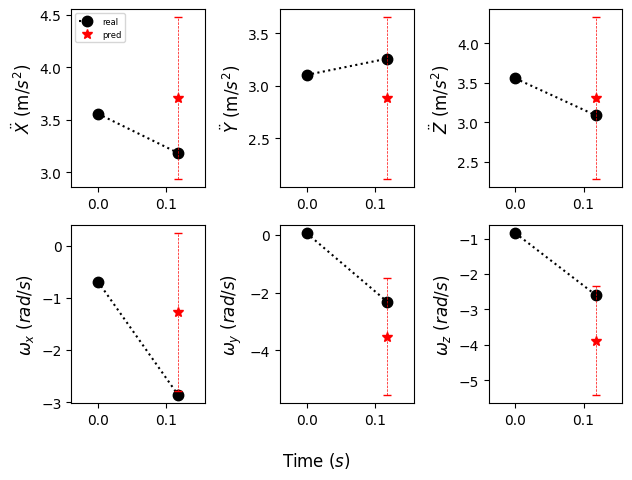

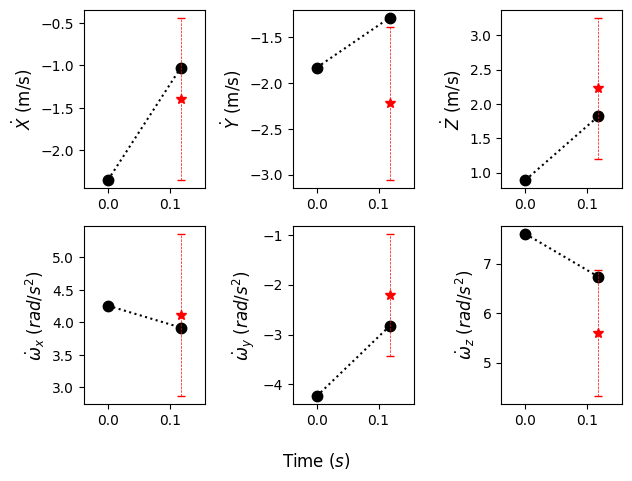

Current Batch Train Loss: 0.010455179959535599

Current Batch Train Loss: 0.01062854751944542

Current Batch Train Loss: 0.010358245112001896

Current Batch Train Loss: 0.010577235370874405

Current Batch Train Loss: 0.010477124713361263

Current Batch Train Loss: 0.010651687160134315

Current Batch Train Loss: 0.010610073804855347

Current Batch Train Loss: 0.010513164103031158

Current Batch Train Loss: 0.01058998890221119

Current Batch Train Loss: 0.010941311717033386

Current Batch Train Loss: 0.010788368992507458

Current Batch Train Loss: 0.010549616999924183

Current Batch Train Loss: 0.01050975639373064

Current Batch Train Loss: 0.010507079772651196

Current Batch Train Loss: 0.010935341939330101

Current Batch Train Loss: 0.011004000902175903

Current Batch Train Loss: 0.010815564543008804

Current Batch Train Loss: 0.010512728244066238

Current Batch Train Loss: 0.010677848011255264

Current Batch Train Loss: 0.01048346422612667

Current Batch Train Loss: 0.0104333786293864

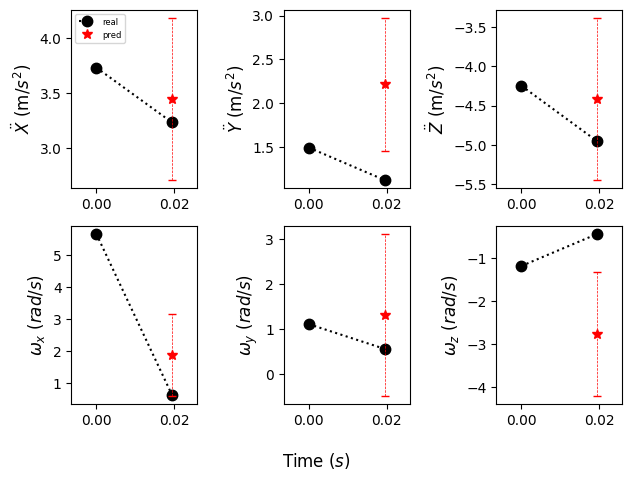

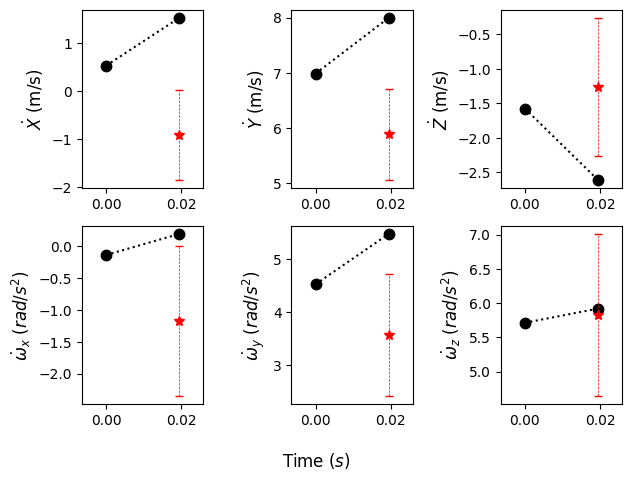

Current Batch Train Loss: 0.011113645508885384

Current Batch Train Loss: 0.010681702755391598

Current Batch Train Loss: 0.010603751987218857

Current Batch Train Loss: 0.010706469416618347

Current Batch Train Loss: 0.010997017845511436

Current Batch Train Loss: 0.011165100149810314

Current Batch Train Loss: 0.010661710053682327

Current Batch Train Loss: 0.010530460625886917

Current Batch Train Loss: 0.010667022317647934

Current Batch Train Loss: 0.010829226113855839

Current Batch Train Loss: 0.010566892102360725

Current Batch Train Loss: 0.010412599891424179

Current Batch Train Loss: 0.01088673248887062

Current Batch Train Loss: 0.010885939933359623

Current Batch Train Loss: 0.010595721192657948

Current Batch Train Loss: 0.010809591971337795

Current Batch Train Loss: 0.01087312400341034

Current Batch Train Loss: 0.010956691578030586

Current Batch Train Loss: 0.010620313696563244

Current Batch Train Loss: 0.010826170444488525

Current Batch Train Loss: 0.01013069786131

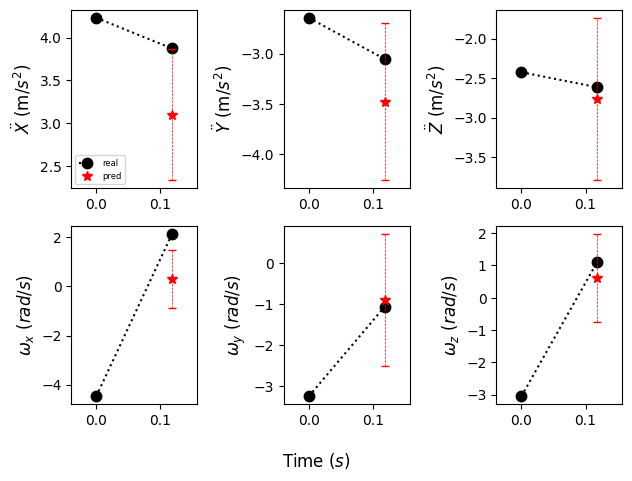

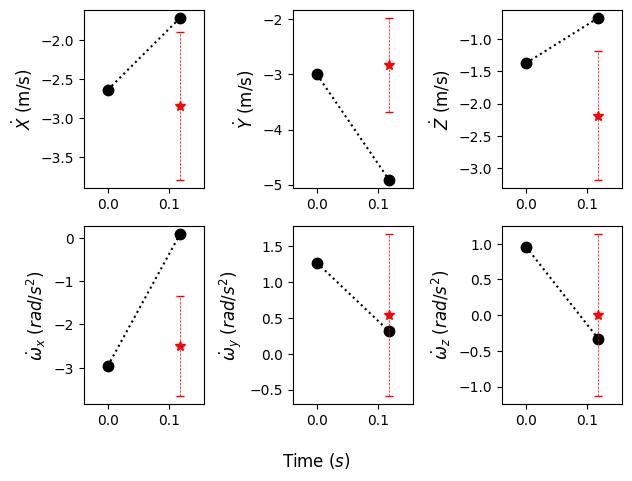

Current Batch Train Loss: 0.011180412955582142

Current Batch Train Loss: 0.01062393095344305

Current Batch Train Loss: 0.01032043993473053

Current Batch Train Loss: 0.010816045105457306

Current Batch Train Loss: 0.010700538754463196

Current Batch Train Loss: 0.010262244381010532

Current Batch Train Loss: 0.010811543092131615

Current Batch Train Loss: 0.010430115275084972

Current Batch Train Loss: 0.010646553710103035

Current Batch Train Loss: 0.010522739961743355

Current Batch Train Loss: 0.010393278673291206

Current Batch Train Loss: 0.010325083509087563

Current Batch Train Loss: 0.01040717028081417

Current Batch Train Loss: 0.010745391249656677

Current Batch Train Loss: 0.010866200551390648

Current Batch Train Loss: 0.010765875689685345

Current Batch Train Loss: 0.010751470923423767

Current Batch Train Loss: 0.011039851233363152

Current Batch Train Loss: 0.0108265932649374

Current Batch Train Loss: 0.010956657119095325

Current Batch Train Loss: 0.01056146621704101

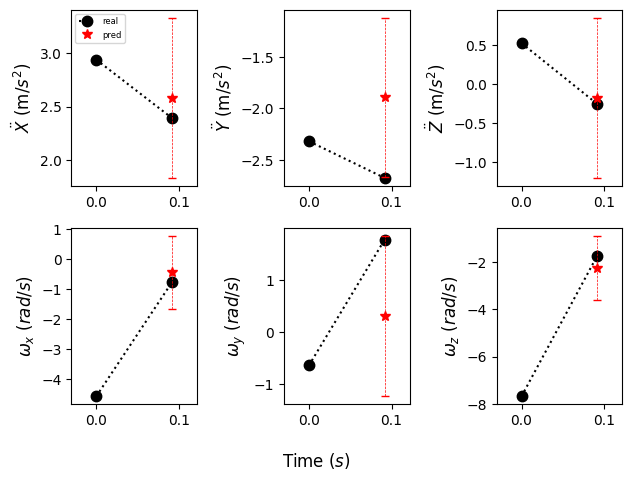

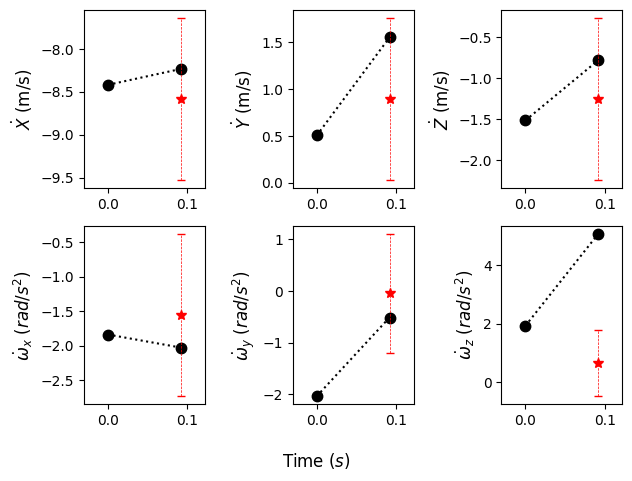

Current Batch Train Loss: 0.011140397749841213

Current Batch Train Loss: 0.010950830765068531

Current Batch Train Loss: 0.010794837959110737

Current Batch Train Loss: 0.010663550347089767

Current Batch Train Loss: 0.010731467045843601

Current Batch Train Loss: 0.01081820111721754

Current Batch Train Loss: 0.010808187536895275

Current Batch Train Loss: 0.010419783182442188

Current Batch Train Loss: 0.010506778955459595

Current Batch Train Loss: 0.01045247446745634

Current Batch Train Loss: 0.010853582993149757

Current Batch Train Loss: 0.010692824609577656

Current Batch Train Loss: 0.010662891902029514

Current Batch Train Loss: 0.010750350542366505

Current Batch Train Loss: 0.010597877204418182

Current Batch Train Loss: 0.010361039079725742

Current Batch Train Loss: 0.011240610852837563

Current Batch Train Loss: 0.01050499826669693

Current Batch Train Loss: 0.010379992425441742

Current Batch Train Loss: 0.010763950645923615

Current Batch Train Loss: 0.010468902066349

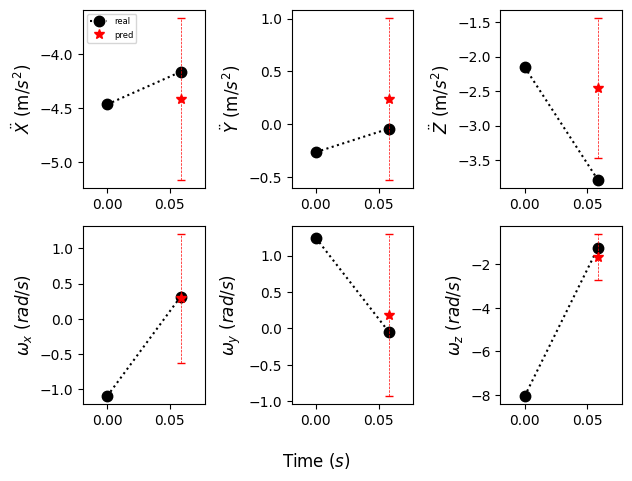

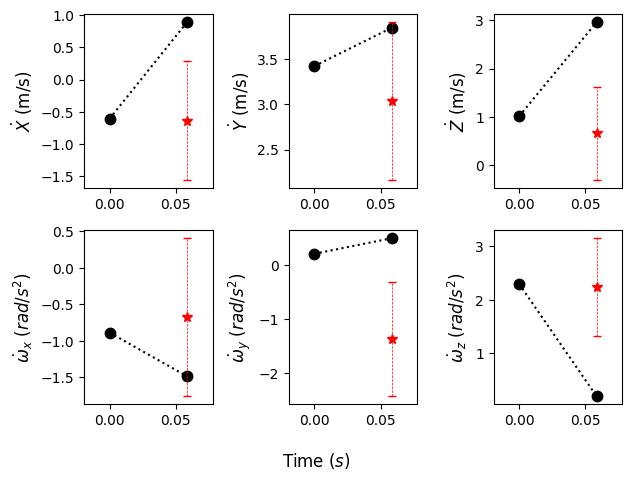

Current Batch Train Loss: 0.010538846254348755

Current Batch Train Loss: 0.010489048436284065

Current Batch Train Loss: 0.010714796371757984

Current Batch Train Loss: 0.01079061720520258

Current Batch Train Loss: 0.010516620241105556

Current Batch Train Loss: 0.010887634009122849

Current Batch Train Loss: 0.010379628278315067

Current Batch Train Loss: 0.010800853371620178

Current Batch Train Loss: 0.010873544961214066

Current Batch Train Loss: 0.010755396448075771

Current Batch Train Loss: 0.011182288639247417

Current Batch Train Loss: 0.010542219504714012

Current Batch Train Loss: 0.010337257757782936

Current Batch Train Loss: 0.010494371876120567

Current Batch Train Loss: 0.010845053941011429

Current Batch Train Loss: 0.011027413420379162

Current Batch Train Loss: 0.010688498616218567

Current Batch Train Loss: 0.010218831710517406

Current Batch Train Loss: 0.01066092774271965

Current Batch Train Loss: 0.010686401277780533

Current Batch Train Loss: 0.01080219820141

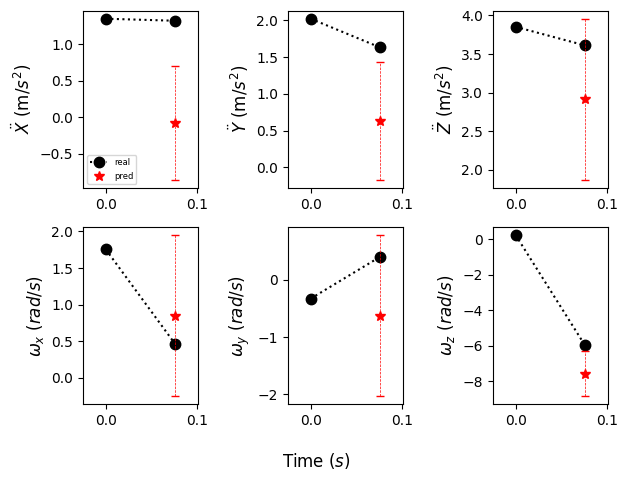

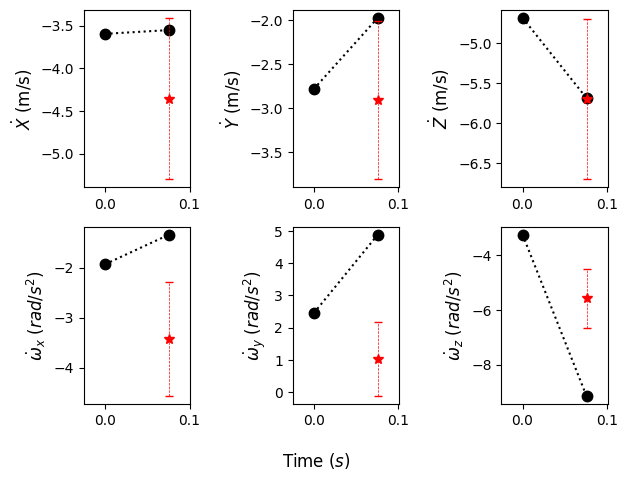

Current Batch Train Loss: 0.010521898977458477

Current Batch Train Loss: 0.010489696636795998

Current Batch Train Loss: 0.010685793124139309



KeyboardInterrupt: 

In [88]:
# Initializing DKF model
model = DeepKalmanFilter(
    hidden_size=128,
    observed_size=12,
    latent_size=12,
    control_size=4
)
#model = torch.load('vel+accel-high-disturbance-no-noise-dkf-40-epochs.pt')

# Initializing model's loss function and optimizer
criterion = DKFLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6, amsgrad=True)

# Initializing training + validation loss tracker
train_loss_array = np.array([])
train_iter_array = np.array([])
val_loss_array = np.array([])
val_latent_AAE_array = np.array([])
val_observed_AAE_array = np.array([])
val_epoch_array = np.array([])

# Defining indexes of sequence length
input_seq_idx = 20
output_seq_idx = 26
observed_seq_idx = 12
latent_seq_idx = 12

# Initializing training loop
i = 0
for epoch in range(NUM_EPOCHS+1):
  if epoch % PLOT_AFTER == 0:
    with torch.no_grad():

      # Sampling random validation batch
      idx = random.randint(0, test_dataset.shape[0]-BATCH_SIZE)
      batch_latent_transitions = torch.concat([test_dataset[idx:idx+BATCH_SIZE,:input_seq_idx], test_dataset[idx:idx+BATCH_SIZE,output_seq_idx:]], dim=-1)
      batch_observed_transitions = torch.concat([test_dataset[idx:idx+BATCH_SIZE,:input_seq_idx], test_dataset[idx:idx+BATCH_SIZE,output_seq_idx:]], dim=-1)
      batch_sensor_noise = test_noise_array[idx:idx+BATCH_SIZE,:]
      next_x_states = batch_observed_transitions[:,input_seq_idx:]
      next_z_states = batch_latent_transitions[:,input_seq_idx:]
      prev_x_states = test_dataset_unnorm[idx:idx+BATCH_SIZE, :observed_seq_idx]
      prev_z_states = test_dataset_unnorm[idx:idx+BATCH_SIZE, :latent_seq_idx]      
      input_unnorm = torch.concat([prev_x_states,
                                   prev_z_states,
                                   test_dataset_unnorm[idx:idx+BATCH_SIZE, latent_seq_idx+1:output_seq_idx]], dim=-1)

      dt_array = batch_observed_transitions[:,12]

    # Collecting predicted outputs + their associated variances + loss info
    # from comparing to ground-truth dynamical data
    z_pred, P_z, x_pred, R_x = model(batch_latent_transitions, batch_observed_transitions, batch_sensor_noise, is_testing=True)

    # Collecting loss from prediction
    #residual_loss = compute_batch_residuals(batch_latent_transitions, batch_observed_transitions, input_unnorm, dt_array)
    loss_test = criterion(x_pred, next_x_states, z_pred, next_z_states)

    # Unnormalizing data for plotting and computing AAE
    next_x_states, x_pred = db.minmax_unnorm(next_x_states, x_pred)
    next_z_states, z_pred = db.minmax_unnorm(next_z_states, z_pred)

    # Computing average absolute error (AAE) over current testing batch
    latent_AE_array, observed_AE_array = compute_AE(next_z_states.detach().numpy(), 
                                                    z_pred.detach().numpy(), 
                                                    next_x_states.detach().numpy(), 
                                                    x_pred.detach().numpy())
    
    latent_test_batch_AAE = np.mean(latent_AE_array)
    latent_test_batch_AAE_std = np.std(latent_AE_array)
    observed_test_batch_AAE = np.mean(observed_AE_array)
    observed_test_batch_AAE_std = np.std(observed_AE_array)
    val_latent_AAE_array = np.concatenate([val_latent_AAE_array, np.array([latent_test_batch_AAE])], axis=0)
    val_observed_AAE_array = np.concatenate([val_observed_AAE_array, np.array([observed_test_batch_AAE])], axis=0)
    # Recording performance after every 'PLOT_AFTER' iterations
    print(f"Epoch: {epoch}, Batch Testing Loss: {loss_test},\nBatch Latent Average AE: {latent_test_batch_AAE} w/ StdDev: {latent_test_batch_AAE_std}, Batch Observed Average AE: {observed_test_batch_AAE} w/ StdDev: {observed_test_batch_AAE_std}\n")

    # Plotting testing GP sample vs the corresponding LNP prediction
    plot_all_functions(prev_x_states, x_pred, next_x_states, prev_z_states, z_pred, next_z_states, P_z, dt_array)
    
    # Collecting validation loss history
    val_loss_array = np.concatenate([val_loss_array, np.array([loss_test.detach().numpy()])], axis=0)
    val_epoch_array = np.concatenate([val_epoch_array, np.array([epoch])], axis=0)

  # Executing training loop
  for batch in range(0, train_dataset.shape[0], BATCH_SIZE):

    # Parsing batch datasets
    batch_latent_transitions = torch.concat([train_dataset[batch:batch+BATCH_SIZE,:input_seq_idx], train_dataset[batch:batch+BATCH_SIZE,output_seq_idx:]], dim=-1)
    batch_observed_transitions = torch.concat([train_dataset[batch:batch+BATCH_SIZE,:input_seq_idx], train_dataset[batch:batch+BATCH_SIZE,output_seq_idx:]], dim=-1)
    batch_sensor_noise = train_noise_array[batch:batch+BATCH_SIZE,:]
    next_x_states = batch_observed_transitions[:, input_seq_idx:]
    next_z_states = batch_latent_transitions[:, input_seq_idx:]
    prev_x_states = train_dataset_unnorm[batch:batch+BATCH_SIZE, :observed_seq_idx]
    prev_z_states = train_dataset_unnorm[batch:batch+BATCH_SIZE, :latent_seq_idx]      
    input_unnorm = torch.concat([prev_x_states,
                                 prev_z_states,
                                 train_dataset_unnorm[batch:batch+BATCH_SIZE, latent_seq_idx+1:output_seq_idx]], dim=-1)

    dt_array = batch_observed_transitions[:,12]

    # zero the parameter gradients for each batch
    optimizer.zero_grad()

    # forward + back propogation + optimizer step
    z_pred, P_z, x_pred, R_x  = model(batch_latent_transitions, batch_observed_transitions, batch_sensor_noise)
    #residual_loss = compute_batch_residuals(batch_latent_transitions, batch_observed_transitions, input_unnorm, dt_array)
    loss_train = criterion(x_pred, next_x_states, z_pred, next_z_states)
    loss_train.backward()
    optimizer.step()

    # Collecting training loss history after every 'COLLECT_LOSS_AFTER' iters
    if i % COLLECT_TRAINING_LOSS_AFTER == 1:
      print(f"Current Batch Train Loss: {loss_train.item()}\n")
      train_loss_array = np.concatenate([train_loss_array, np.array([loss_train.detach()])], axis=0)
      train_iter_array = np.concatenate([train_iter_array, np.array([i])], axis=0)
    i += 1

  train_dataset, train_dataset_unnorm, train_noise_array = shuffle_data(train_dataset, train_dataset_unnorm, train_noise_array)

In [92]:
torch.save(model, 'vel+accel-high-disturbance-mm-noise-30-epochs-DKF.pt')

In [106]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"name: {name}, param.data, {param.data}")

name: transition_net.fc1.weight, param.data, tensor([[ 0.1414,  0.0111,  0.0729,  ..., -0.0536, -0.1102,  0.0638],
        [ 0.1624,  0.1570,  0.0785,  ..., -0.0955, -0.1637,  0.1397],
        [ 0.1103, -0.0084,  0.1730,  ..., -0.0312,  0.2248,  0.2403],
        ...,
        [-0.0095, -0.2224, -0.1573,  ...,  0.2363, -0.1486,  0.1123],
        [-0.1210,  0.1155,  0.0410,  ..., -0.2029, -0.1103, -0.2118],
        [ 0.1611, -0.0295,  0.1402,  ..., -0.1571, -0.1733, -0.1505]])
name: transition_net.fc1.bias, param.data, tensor([-0.1603, -0.1760, -0.0655, -0.2225, -0.1513, -0.0351, -0.0576, -0.0400,
         0.0406,  0.0490, -0.0530, -0.1977,  0.0481, -0.1724,  0.1031, -0.0627,
        -0.1535,  0.1568, -0.0690,  0.0289,  0.1070,  0.1082, -0.2108, -0.1198,
         0.1069,  0.0325, -0.2491,  0.1250, -0.1626,  0.1599,  0.1113, -0.1894,
        -0.2336,  0.0168, -0.1073,  0.1381,  0.0517,  0.1250, -0.2082, -0.1206,
        -0.2451,  0.1422,  0.0635,  0.1131,  0.0073, -0.0851, -0.0469,  0.2391

In [15]:
def compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  state_diff = np.abs(state_vec - pred_state_vec)
  AE_array = np.sum(state_diff, axis=1)
  
  return AE_array

def scaled_compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  scaled_state_diff = np.abs((state_vec - pred_state_vec) / state_vec) * 100
  scaled_AE_array = np.mean(scaled_state_diff)

  return scaled_AE_array

In [32]:
# Initializing model
model = torch.load('vel+accel-high-disturbance-mm-noise-30-epochs-DKF.pt')

# Initializing quadrotor sensor noise/disturbance parameters
test_db = Quadrotor_Dynamics_Generator(normalize=True)
num_perturb_profiles = 100
perturb_params = torch.zeros([num_perturb_profiles,2])
rotor_spike_profile = torch.linspace(1, 100, num_perturb_profiles)
bias_vector = torch.linspace(5e-5, 2e-1, 100)
wind_vel_array = torch.linspace(0, 20, 100)
perturb_params[:,0] = rotor_spike_profile
perturb_params[:,1] = wind_vel_array

# Sampling random trajectory data 
sample_length = 10
num_trajs = 20

#test_traj = test_traj.unsqueeze(dim=0)
test_AAE_array = np.zeros([num_perturb_profiles, sample_length*num_trajs])

# Defining test trajectory time array
time_array = np.zeros([sample_length,])

# Looping through entire test trajectory
for profile in range(num_perturb_profiles):
    
    params = perturb_params[profile,:]
    
    count = 0
    for traj in range(num_trajs):
        
        # Sampling random trajectory data 
        test_traj = test_db.generate_test_traj(seq_length=sample_length, perturb_params=params, gaussian_noise=True)
        test_traj = test_db.minmax_norm(test_traj)
        test_traj = test_db.sequential_split(test_traj)
        #test_traj = test_db.minmax_norm(test_traj)
        
        # Resetting time counter
        curr_time = 0
        
        for i in range(sample_length):

            curr_sample = test_traj[i:i+1,:]
            #curr_sample[:,0:1,8:] = next_context
            batch_latent_transitions = torch.concat([curr_sample[:,:20], curr_sample[:,26:]], dim=-1)
            batch_observed_transitions = torch.concat([curr_sample[:,:20], curr_sample[:,26:]], dim=-1)
            next_z_states = batch_latent_transitions[:,20:]

            curr_dt = curr_sample[:,12]
            curr_time += curr_dt 
            time_array[i] = curr_time.detach().numpy()
            
            # Perturbing next observed states via sensor noise injection
            bias = bias_vector[profile]
            sensor_noise = torch.normal(mean=bias, std=5e-2, size=[1, 12])

            # Forward pass of DKF
            z_pred, P_z, _, _ = model(batch_latent_transitions, batch_observed_transitions, sensor_noise, is_testing=True)

            # Unnormalizing data for plotting and computing AAE
            next_z_states, z_pred = test_db.minmax_unnorm(next_z_states, z_pred)
            
            # Computing average absolute error (AAE) over current testing batch
            AE_array = compute_AE(next_z_states.detach().numpy(), z_pred.detach().numpy())
            test_AAE_array[profile, count] = AE_array
            count += 1

/tmp/ipykernel_5409/2353636703.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_array[i] = curr_time.detach().numpy()
/tmp/ipykernel_5409/2353636703.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_AAE_array[profile, count] = AE_array


In [33]:
perturb_AAE_array = np.mean(test_AAE_array, axis=1)

perturb_AAE_array

array([22.13620676, 23.769402  , 23.63036782, 22.71582714, 23.66985703,
       23.82808537, 23.37871408, 23.07573633, 22.91595482, 22.72398641,
       22.99087914, 23.18372612, 22.81385638, 22.69435465, 23.19317225,
       23.03479529, 23.63586501, 21.81366858, 22.17517832, 22.43706484,
       22.53524498, 23.19712907, 22.08516503, 21.84211993, 22.42237615,
       23.07836021, 22.79892559, 23.6552187 , 22.92561167, 22.49431026,
       21.78373392, 22.47769854, 21.90707139, 22.28436467, 22.80986368,
       22.75016598, 22.6498686 , 22.31246858, 22.16611133, 22.33384346,
       22.62761333, 22.75707201, 22.28711473, 23.14436708, 22.46430159,
       23.19347787, 22.14482004, 22.45536226, 21.63619283, 22.36843255,
       21.79770811, 23.05853562, 22.60203958, 22.17911918, 22.27651339,
       22.70000297, 21.5221455 , 22.29678914, 22.22536285, 22.00417482,
       22.21736307, 22.01986839, 22.32131053, 22.01129658, 21.76512546,
       21.85398004, 22.28272293, 21.73207202, 22.30176171, 22.06

In [34]:
np.save('DKF-AAE-Perturb-array.npy', perturb_AAE_array)